### Project 4 - Mobile Robotics - MO651
#### __Professor:__ _Esther Luna Columbini_ <br>
__Students:__ <br>
<table style="margin:0; padding:3px;">
    <tr><td><em>Tito Barbosa Rezende </td><td><strong>RA:</strong> 025327</td></tr>
<tr><td><em>João Paulo Franco Assumpção </td><td><strong>RA:</strong> 229322</td></tr>
<tr><td><em>Elcio Pereira de Souza Junior </td><td><strong>RA:</strong> 262952</td></tr></table>

### Pre-requisites

Necessary libraries:

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install scikit-fuzzy
%pip install sklearn

Import libraries:

In [1]:
import sys, time
sys.path.insert(0, '../src')
from IPython.display import clear_output
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import random
import collections
from datetime import datetime
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import lidar_to_grid_map as lg
import grid_map_lib as gm
import operator
from enum import IntEnum
from skimage.feature import corner_harris, corner_peaks, canny
from skimage.measure import find_contours
from skimage.morphology import remove_small_objects, skeletonize

### 1.1 Laser Sensor

In [2]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

    def plot_laser_robot_frame(self):
        ox = self.laser_x
        oy = self.laser_y
        plt.figure(figsize=(6,10))
        plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
        plt.axis("equal")
        bottom, top = plt.ylim()  # return the current ylim
        plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
        plt.grid(True)
        plt.show()

### 1.2 Sonar Sensors

In [3]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
        
    def get_left_distance(self):
        self.update_raw_reading()
        return np.min(np.array(self.data["raw_reading"][0]))
    
    def get_front_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][3:5]]))        
    
    def get_right_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][7:9]]))
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(self.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

We defined __toGlobal__ function to enable a later using. The function transform any _(x,y)_ point of robot reference into a global reference.

In [4]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]
def fromGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,-robot_x],[0,1,-robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),math.sin(robot_ang),0],[-math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_rot,T_trans)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    ang = np.arctan2(res[1],res[0])
    return res[0],res[1], ang

### 1.3 Kinematic Model

In [5]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_streaming)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_streaming)
       
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_buffer)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_buffer)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        
        #Without gyroscope
        #self.enc_Theta = self.enc_Theta + qsi[2]
        #with gyroscope
        self.enc_Theta = self.robot.read_gyroAngle()[2]
        
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def turnGlobal(self, input_ang):
        orientation = self.robot.get_current_orientation()[2]
        ang = input_ang
        if (orientation < -math.pi):
            orientation = orientation + 2*math.pi
        if (orientation > math.pi) :
            orientation = orientation - 2*math.pi
        if (ang < -math.pi):
            ang = ang + 2*math.pi
        if (ang > math.pi) :
            ang = ang - 2*math.pi
            
        vel = 1
        new_orientation = ang - orientation
        if (new_orientation > math.pi):
            new_orientation = new_orientation -2*math.pi
        if (new_orientation < -math.pi):
            new_orientation = new_orientation +2*math.pi
        if (new_orientation > 0) :
            vel=-vel
        self.robot.set_right_velocity(vel)
        self.robot.set_left_velocity(-vel)
        tolerance = math.pi/90
        if ((ang - orientation) > tolerance) or ((ang - orientation) < -tolerance):
            orientation = self.robot.get_current_orientation()[2]
            if (orientation < 0):
                orientation = orientation + 2*math.pi
            #sys.stdout.write("\r" + "Diff " + str((ang - orientation)) + " orientation " + str(orientation))
            #sys.stdout.flush()
        return vel, -vel
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
        
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(enc_path[:,0], enc_path[:,1], 1, c='b', label='odometry')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax.plot(true_path[:,0], true_path[:,1], 1, c='r', label='true path')
        ax.legend()

In [6]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.grid_map = None
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        self.res = 0.05
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
        
        self.gridMapPosPoints = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[0].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[1].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()
          
    def set_resolution(self, resolution):
        self.res = resolution
        
    def compute_grid_ocupation(self):
        xyreso = self.res  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        #ang, dist = file_read("lidar01.csv")
        laser_point_array = np.array(self.laser_points)
        ox = laser_point_array[:,0]
        oy = laser_point_array[:,1]
        self.pmap, self.minx, self.maxx, self.miny, self.maxy, self.xyreso, self.centix, self.centiy = \
        lg.generate_ray_casting_grid_map(ox, oy, xyreso, True)
        self.gridwidth = np.array(self.pmap).shape[0]
        self.gridheight = np.array(self.pmap).shape[1]
        self.grid_map = gm.GridMap( self.gridwidth, self.gridheight, self.res,
                 self.centix, self.centiy, init_val= self.pmap)
        
    def get_idx_from_pos(self, x, y):
        ix = int(round((x - self.minx) / self.xyreso)) # x coordinate of the the occupied area
        iy = int(round((y - self.miny) / self.xyreso)) # y coordinate of the the occupied area
        return ix, iy
    
    def get_pos_from_idx(self, idx, idy):
        x = round((idx*self.xyreso) + self.minx, 2)
        y = round((idy*self.xyreso) + self.miny, 2)
        return x, y
            
    def plot_grid_ocupation(self):
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(self.pmap.T, cmap = "PiYG_r") 
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, self.gridwidth, 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, self.gridheight, 1), minor = True)
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()
    
    def update_grid_map_pos_points(self):
        self.gridMapPosPoints = []
        indexes = np.where(self.pmap == 1)
        for index in range(len(indexes[0])):
            idx_x = indexes[0][index]
            idx_y = indexes[1][index]
            self.gridMapPosPoints.append(self.get_pos_from_idx(idx_x, idx_y))
    
    def plot_grid_map_pos_points(self):
        point_array = np.array(self.gridMapPosPoints)
        plt.scatter(point_array[:,0],point_array[:,1], 10, c='r', marker='.')
        plt.axis('equal')
        plt.show()
        
    def compute_room_countour(self):
        a = self.pmap == 1
        a = skeletonize(a)
        remove_small_objects(a, 80, connectivity=2, in_place=True)
        #a = canny(a, sigma=2)
        coords = corner_peaks(corner_harris(a), min_distance=10)
        pp = list(map(tuple, coords))
        cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
        # sort by polar angle
        pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
        b = np.array(pp)
        return a, b
    
    def get_room_countour(self):
        _, b = self.compute_room_countour()
        return np.array([ self.get_pos_from_idx(p[0], p[1]) for p in b]).T
    
    def plot_countour(self):
        a, b = self.compute_room_countour()
        fig, ax = plt.subplots()
        ax.imshow(a.T, cmap=plt.cm.gray)
        ax.plot(b[:, 0], b[:, 1], color='cyan', marker='o', linestyle='None', markersize=6)
        #ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
        for i, p in enumerate(b):
            ax.annotate(i, (b[i, 0], b[i, 1]), color='red')
        ax.axis((0, a.T.shape[0], a.T.shape[1], 0))
        ax.invert_yaxis()
        plt.show()

## 2 - Code of Project 2

The general objective of this work is to build, on the V-REP robotic simulator, a set of behaviors to control a Pioneer P3-DX robot.
3 Behaviours were developed:<br>
    <blockquote>2.1 AvoidObstacle<br>
    2.2 WallFollow<br>
    2.3 GoToGoal</blockquote>

### 2.1 - AvoidObstacle

This behaviour was implemented using Fuzzy logic. In other to correctlly demonstrate the behaviour, a simple wandering algorithim is simulated bellow

First, bellow Fuzzyfication function was implemented, receiving as its input the reading of the sonar sensors. The eight frontal sonar sensors was classified into 3 groups: left sensors (__x_l:__ 1 to 3 sensors); forward (__x_f:__ 3 to 6 sensors) and; right (__x_r:__ 6 to 8 sensors). For fuzzification we adopted the minimal value each one.

We choose 0.1m as __near__ and values between 0.1 and 0.4m as __almost near__. Far value was considered irrelevant in results.

The function print a graphic result if you set the __\_print__ value to __1__.

In [7]:
def sensor_fuzzyfication(frontal_sensors,_print=0, _near=0.1, _almost_near=0.4) :
    x_v = np.arange(-0.1, 5.1, 0.01)
    t_close = [-0.1, -0.1, _near, _almost_near]
    mfx_close = fuzz.trapmf(x_v, t_close)
    #t_far = [0.3, .55, 5, 5]                /// Results are irrelevant
    #mfx_far = fuzz.trapmf(x_v, t_far)       /// Results are irrelevant
    x_l = np.array([round(min(frontal_sensors[:2]))])    # Left sensors
    x_f = np.array([min(frontal_sensors[3:5])])          # Forward Sensors
    x_r = np.array([round(min(frontal_sensors[6:8]),1)]) # Right sensors
    y_l = np.array([-1]) # Null value
    y_f = np.array([-1]) # Null value
    y_r = np.array([-1]) # Null value
    if(x_l[0] < _almost_near) :
        y_l = fuzz.trapmf(x_l, t_close) # Return fuzzy value for left sensors
    if(x_f[0] < _almost_near) :
        y_f = fuzz.trapmf(x_f, t_close) # Return fuzzy value for forward sensors
    if(x_r[0] < _almost_near) :
        y_r = fuzz.trapmf(x_r, t_close) # Return fuzzy value for right sensors
    
    # Just for print mode
    if (_print > 0) : 
        plt.plot(x_v, mfx_close,label="Near")
        colors = ['tab:black','tab:cyan','tab:purple','tab:green','tab:red','tab:brown','tab:olive','tab:gray','tab:pink']
        if(x_l[0] < 1) : plt.vlines(x_l, 0, y_l, label="min_left",color=colors[1]); print("Left sensors fuzzyfication: "+str(y_l[0]))
        if(x_f[0] < 1) : plt.vlines(x_f, 0, y_f, label="min_forward",color=colors[2]); print("Forward sensors fuzzyfication: "+str(y_f[0]))
        if(x_r[0] < 1) : plt.vlines(x_r[0], 0, y_r, label="min_right",color=colors[3]); print("Right sensors fuzzyfication: "+str(y_r[0]))
        plt.ylabel('Fuzzy value')
        plt.xlabel('Proximity (m)')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc=1)
        plt.draw()
        plt.pause(0.05)
    
    # Return useful value: used X range; Y result values and; near trapezoidal.
    return x_v, y_l, y_f, y_r, t_close

Then, the object avoidance will be given by the defuzzyfication function bellow, acting in oposition to the proximitiy sensor. The function starts an initial verification if the frontal sensors minimal value is grater than 0.4m (our almost near value). In this case it returns the angular velocity equal 2 to both wheels. Else, it goes to defuzzification angular velocity.

In [8]:
def avoidByDefuzzyfication(frontal_sensors,fuzzy_results, _print=0) :
    if (min(frontal_sensors) > fuzzy_results[4][3]) : # in case all frontal sensor is grater than almost near
        velL = 2
        velR = 2
        return velL, velR           # Stop function and return equal values. 
                                    # This condition avoid a defuzzy error obtaining a null crisp value
    y_v = np.arange(-95, 95, 1)
    x_v = fuzzy_results[0]

    mfy_left = fuzz.trimf(y_v, [-95, -95,-10])       # Values to get  a left collision probabillity
    mfy_forward = fuzz.trapmf(y_v, [-60,-30, 30,60]) # Values to get  a forward collision probabillity
    mfy_right = fuzz.trimf(y_v, [10,95,95])          # Values to get  a right collision probabillity

    proximityL = ctrl.Antecedent(x_v, 'proximityL')
    proximityR = ctrl.Antecedent(x_v, 'proximityR')
    proximityF = ctrl.Antecedent(x_v, 'proximityF')
    prob = ctrl.Consequent(y_v, 'Collision')         # Collision probabillity

    proximity = fuzz.trapmf(x_v,[-0.1, -0.1, fuzzy_results[4][2], fuzzy_results[4][3]])
    proximityL['near'] = proximity
    proximityR['near'] = proximity
    proximityF['near'] = proximity
    prob['Left'] = mfy_left
    prob['Forward'] = mfy_forward
    prob['Right'] = mfy_right


    # This method define 3 rules to get our fuzzy set
    rule1 = ctrl.Rule(proximityL['near'] , prob['Left'])
    rule2 = ctrl.Rule(proximityF['near'] , prob['Forward'])
    rule3 = ctrl.Rule(proximityR['near'], prob['Right'])

    vel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3]) # Defuzzy rules for collision possibility
    vel = ctrl.ControlSystemSimulation(vel_ctrl)

    vel.input['proximityL'] = min(frontal_sensors[:3])
    vel.input['proximityR'] = min(frontal_sensors[5:8])
    vel.input['proximityF'] = min(frontal_sensors[2:6])

    if (_print > 0) :
        # Print minimal sensor distances
        print("Distance Left: "+str(min(frontal[:3])))
        print("Distance Forward: "+str(min(frontal[2:6])))
        print("Distance Right: "+str(min(frontal[5:8])))

    vel_output = 1

    if (min(frontal_sensors) <= 1):
        vel.compute()
        # Using Mamdani's method we output a fuzzy set 
        # and obtain a crisp value from centroid
        
        vel_output = round(vel.output['Collision'])   # Collision angle probabillity crisp value
        Collision = "Collision: "+str(vel_output)+"°"
    else: Collision = "No collision"
    if (_print > 0) :
        print(Collision)
        prob.view(sim=vel)
    
    x_w = np.arange(-100,100,0.1)
    wlv = [-100, -100,0,50]    # Fuzzify crisp value to obtain left wheel angular velocity
    wrv = [0,10,100,100]       # Fuzzify crisp value to obtain right wheel angular velocity
    # We use diferent trapezoidal graphics for the wheels to avoid equal speed in frontal collision possibility
    
    x = np.array([vel_output])
    y_l=fuzz.trapmf(x, wlv)    # Fuzzy value for left wheel
    y_r=fuzz.trapmf(x, wrv)    # Fuzzy value for right wheel
    if (_print > 0) :
        #Print graphics
        WheelL = fuzz.trapmf(x_w, wlv)
        WheelR = fuzz.trapmf(x_w, wrv)
        plt.plot(x_w, WheelL,label="Wheel Left")
        plt.plot(x_w, WheelR,label="Wheel Right")
        plt.vlines(x, 0, y_l, label="Collision")
        plt.vlines(x, 0, y_r)
        plt.legend()
        plt.draw()
        plt.pause(0.05)
        print("Wheel left angular velocity: "+str((y_l[0]-0.5)/0.25))
        print("Wheel right angular velocity: "+str((y_r[0]-0.5)/0.25))
    
    velL = (y_l[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for left wheel
    velR = (y_r[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for right wheel

    return velL, velR

Our mobile robot class, implementing the fuzzy controller will be given by:

### 2.3 Go To Go

Instead of moving forward on robot current direction, we could implement a behaviour to Go to a specific point on the global reference.
The implementation is given by the following function

In [9]:
def give_diretion(robot, us_sensors, go_point_x, go_point_y, _print=0):
    
    # global position of robot
    robot_x = robot.get_current_position()[0]
    robot_y = robot.get_current_position()[1]
    robot_ang = robot.get_current_orientation()[2]
    
    # relative vector to goal
    vec_x_go = go_point_x - robot_x
    vec_y_go = go_point_y - robot_y
    
    # angle between position and goal vector
    # vector origin
    
    ang = math.acos( vec_x_go / ( math.sqrt(math.pow(vec_x_go,2)+math.pow(vec_y_go,2)) ) )

    if (_print==0):
        print("ang:")
        print(ang)
        print("ang robot:")
        print(robot_ang)
    
    if robot_y > 0:
        ang = -ang

    if (_print==0):
        print("After:")
        print(robot.get_current_orientation()[2])

        # plot
        plt.plot([0,0],[-7.5,7.5], color='g')
        plt.plot([-7.5,7.5], [0,0], color='r')
        origin = [robot_x, robot_y]
        plt.quiver(*origin, vec_x_go, vec_y_go, color=['b'])

        plt.axis([-7.5,7.5,-7.5,7.5])
        plt.show()
        
    return ang

Start GotoGoal without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

# Planing

In [11]:
do_animation = False
class SweepSearcher:
    class SweepDirection(IntEnum):
        UP = 1
        DOWN = -1

    class MovingDirection(IntEnum):
        RIGHT = 1
        LEFT = -1

    def __init__(self, mdirection, sdirection, xinds_goaly, goaly):
        self.moving_direction = mdirection
        self.sweep_direction = sdirection
        self.turing_window = []
        self.update_turning_window()
        self.xinds_goaly = xinds_goaly
        self.goaly = goaly

    def move_target_grid(self, cxind, cyind, gmap):
        nxind = self.moving_direction + cxind
        nyind = cyind

        # found safe grid
        if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
            return nxind, nyind
        else:  # occupided
            ncxind, ncyind = self.find_safe_turning_grid(cxind, cyind, gmap)
            if (ncxind is None) and (ncyind is None):
                # moving backward
                ncxind = -self.moving_direction + cxind
                ncyind = cyind
                if gmap.check_occupied_from_xy_index(ncxind, ncyind):
                    # moved backward, but the grid is occupied by obstacle
                    return None, None
            else:
                # keep moving until end
                while not gmap.check_occupied_from_xy_index(ncxind + self.moving_direction, ncyind, occupied_val=0.5):
                    ncxind += self.moving_direction
                self.swap_moving_direction()
            return ncxind, ncyind

    def find_safe_turning_grid(self, cxind, cyind, gmap):

        for (dxind, dyind) in self.turing_window:

            nxind = dxind + cxind
            nyind = dyind + cyind

            # found safe grid
            if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
                return nxind, nyind

        return None, None

    def is_search_done(self, gmap):
        for ix in self.xinds_goaly:
            if not gmap.check_occupied_from_xy_index(ix, self.goaly, occupied_val=0.5):
                return False

        # all lower grid is occupied
        return True

    def update_turning_window(self):
        self.turing_window = [
            (self.moving_direction, 0.0),
            (self.moving_direction, self.sweep_direction),
            (0, self.sweep_direction),
            (-self.moving_direction, self.sweep_direction),
        ]

    def swap_moving_direction(self):
        self.moving_direction *= -1
        self.update_turning_window()

    def search_start_grid(self, grid_map):
        xinds = []
        y_ind = 0
        if self.sweep_direction == self.SweepDirection.DOWN:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
        elif self.sweep_direction == self.SweepDirection.UP:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

        if self.moving_direction == self.MovingDirection.RIGHT:
            return min(xinds), y_ind
        elif self.moving_direction == self.MovingDirection.LEFT:
            return max(xinds), y_ind

        raise ValueError("self.moving direction is invalid ")


def find_sweep_direction_and_start_posi(ox, oy):
    # find sweep_direction
    max_dist = 0.0
    vec = [0.0, 0.0]
    sweep_start_pos = [0.0, 0.0]
    for i in range(len(ox) - 1):
        dx = ox[i + 1] - ox[i]
        dy = oy[i + 1] - oy[i]
        d = np.sqrt(dx ** 2 + dy ** 2)

        if d > max_dist:
            max_dist = d
            vec = [dx, dy]
            sweep_start_pos = [ox[i], oy[i]]

    return vec, sweep_start_pos


def convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi):
    tx = [ix - sweep_start_posi[0] for ix in ox]
    ty = [iy - sweep_start_posi[1] for iy in oy]

    th = math.atan2(sweep_vec[1], sweep_vec[0])

    c = np.cos(-th)
    s = np.sin(-th)

    rx = [ix * c - iy * s for (ix, iy) in zip(tx, ty)]
    ry = [ix * s + iy * c for (ix, iy) in zip(tx, ty)]

    return rx, ry


def convert_global_coordinate(x, y, sweep_vec, sweep_start_posi):
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    c = np.cos(th)
    s = np.sin(th)

    tx = [ix * c - iy * s for (ix, iy) in zip(x, y)]
    ty = [ix * s + iy * c for (ix, iy) in zip(x, y)]

    rx = [ix + sweep_start_posi[0] for ix in tx]
    ry = [iy + sweep_start_posi[1] for iy in ty]

    return rx, ry


def search_free_grid_index_at_edge_y(grid_map, from_upper=False):
    yind = None
    xinds = []

    if from_upper:
        xrange = range(grid_map.height)[::-1]
        yrange = range(grid_map.width)[::-1]
    else:
        xrange = range(grid_map.height)
        yrange = range(grid_map.width)

    for iy in xrange:
        for ix in yrange:
            if not grid_map.check_occupied_from_xy_index(ix, iy):
                yind = iy
                xinds.append(ix)
        if yind:
            break

    return xinds, yind


def setup_grid_map(ox, oy, reso, sweep_direction, offset_grid=10):
    width = math.ceil((max(ox) - min(ox)) / reso) + offset_grid
    height = math.ceil((max(oy) - min(oy)) / reso) + offset_grid
    center_x = np.mean(ox)
    center_y = np.mean(oy)

    grid_map = gm.GridMap(width, height, reso, center_x, center_y)

    grid_map.set_value_from_polygon(ox, oy, 1.0, inside=False)

    grid_map.expand_grid()

    xinds_goaly = []
    goaly = 0
    if sweep_direction == SweepSearcher.SweepDirection.UP:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
    elif sweep_direction == SweepSearcher.SweepDirection.DOWN:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

    return grid_map, xinds_goaly, goaly


def sweep_path_search(sweep_searcher, gmap, grid_search_animation=False):
    # search start grid
    cxind, cyind = sweep_searcher.search_start_grid(gmap)
    if not gmap.set_value_from_xy_index(cxind, cyind, 0.5):
        print("Cannot find start grid")
        return [], []

    x, y = gmap.calc_grid_central_xy_position_from_xy_index(cxind, cyind)
    px, py = [x], [y]

    if grid_search_animation:
        fig, ax = plt.subplots()

    while True:
        cxind, cyind = sweep_searcher.move_target_grid(cxind, cyind, gmap)

        if sweep_searcher.is_search_done(gmap) or (cxind is None or cyind is None):
            print("Done")
            break

        x, y = gmap.calc_grid_central_xy_position_from_xy_index(
            cxind, cyind)

        px.append(x)
        py.append(y)

        gmap.set_value_from_xy_index(cxind, cyind, 0.5)

        if grid_search_animation:
            gmap.plot_grid_map(ax=ax)
            plt.pause(1.0)

    gmap.plot_grid_map()

    return px, py


def planning(ox, oy, reso,
             moving_direction=SweepSearcher.MovingDirection.RIGHT,
             sweeping_direction=SweepSearcher.SweepDirection.UP,
             ):
    sweep_vec, sweep_start_posi = find_sweep_direction_and_start_posi(ox, oy)

    rox, roy = convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi)

    gmap, xinds_goaly, goaly = setup_grid_map(rox, roy, reso, sweeping_direction)

    sweep_searcher = SweepSearcher(moving_direction, sweeping_direction, xinds_goaly, goaly)

    px, py = sweep_path_search(sweep_searcher, gmap)

    rx, ry = convert_global_coordinate(px, py, sweep_vec, sweep_start_posi)

    print("Path length:", len(rx))

    return rx, ry

def plot_planning(px, py, reso):
    plt.cla()
    plt.plot(px, py, ".r")
    plt.axis("equal")
    plt.invert_yaxis()
    plt.grid(True)
    plt.pause(0.1)
    print("px ", px)
    print("py ", py)


def planning_animation(ox, oy, reso):  # pragma: no cover
    px, py = planning(ox, oy, reso)

    # animation
    if do_animation:
        for ipx, ipy in zip(px, py):
            plt.cla()
            plt.plot(ox, oy, "-xb")
            plt.plot(px, py, "-r")
            plt.plot(ipx, ipy, "or")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.1)

    plt.cla()
    plt.plot(ox, oy, "-xb")
    plt.plot(px[:2], py[:2], "-r")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)
    print("px ", px)
    print("py ", py)

### 2.4 Behaviour Coordenation

In [14]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.point_cloud = PointCloud(self.robot, self.us_sensors, self.laser_sensors)
        self.point_cloud.update()
        self.compute_interval = 0.5
        
        self.px = [] 
        self.py = []
        self.plannedStep = 0
        self.planning_reso = 0.4
   
        self.go_x = 0
        self.go_y = 0
    
    # Find direction for the destination point
    def direction(self):
        return give_diretion(self.robot, self.us_sensors, self.go_x, self.go_y, 1)
        
    # Set destination point
    def setGoal(self, x, y):
        self.go_x = x
        self.go_y = y
        
    # Check if the robot has reached destination
    def checkFinal(self):
        curr_x, curr_y = self.kinematicModel.true_global_position()
        return (abs(curr_x - self.go_x) < 0.1) and (abs(curr_y - self.go_y) < 0.1)
    
    def checkCorrectDirection(self):
        go_direction = self.direction()
        robot_direction = self.robot.get_current_orientation()[2]
        return (abs(go_direction - robot_direction) < 0.1)
    
    # Avoid obstacles using fuzzy logic
    def fuzzyControl(self):
        frontal = self.robot.read_ultrassonic_sensors()[:8]
        fuzzy = sensor_fuzzyfication(frontal,0,0.05,0.2) # Call function fuzzy and set near=0.05 and almost_near=0.1
        avoid = avoidByDefuzzyfication(frontal,fuzzy)
        return avoid[0], avoid[1]
    
    # Subsumption behavior controller
    def control(self):
        vel_l = 0
        vel_r = 0
    
        
        min_frontal = np.min(np.array(self.robot.read_ultrassonic_sensors()[:8]))
        min_rear = np.min(np.array(self.robot.read_ultrassonic_sensors()[9:15]))
        
        #1st Priority: React rear collision possibility
        if (min_rear < 0.1) :
            vel_l, vel_r = [2.0,2.0]
            pText = "React rear collision"
        #2nd Priority: Avoid Obstacle
        elif (min_frontal <= 0.18 and min_rear > 0.1):
            vel_l, vel_r = self.fuzzyControl()
            pText = "Avoid Obstacle"
        #3th Priority: Turn to destination direction
        elif (not self.checkCorrectDirection()):
            direct = self.direction()
            vel_l, vel_r = self.kinematicModel.turnGlobal(direct)
            vel_l = vel_l + 0.2
            vel_r = vel_r + 0.2
            pText = "Turn {}".format(direct)
        #4th Priority: Go Forward
        else:
            vel_l = 2
            vel_r = 2
            pText = "Go Forward"
        #print(pText)
        sys.stdout.write("\r" + pText + " pos " + str(self.kinematicModel.true_global_position()) + " goal " + \
                str(self.go_x) + " " + str(self.go_y))
        sys.stdout.flush()
        return vel_l, vel_r

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.control()
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            if (self.checkFinal()):
                self.next_planned_step()
                if (self.plannedStep == len(self.px) - 1):
                    self.robot.stop()
                    print("You have reached your destination!")
                    self.kinematicModel.plot_paths()
                    break
    
    def wandering_control(self, frontal):
        fuzzy = sensor_fuzzyfication(frontal)
        avoid = avoidByDefuzzyfication(frontal,fuzzy)    # Defuzzyfication
        return avoid[0], avoid[1]    
    
    def start_wander(self, seconds):
        for step in range(int(seconds/self.compute_interval)): # Repeat avoidance each 0.2s (self.compute_interval)
            Phi_l, Phi_r = self.wandering_control(self.robot.read_ultrassonic_sensors()[:8]) # Get angular speed from avoidance function
            self.kinematicModel.move(Phi_r*3, Phi_l*3,self.compute_interval)           # Apply angular speed to kinematic model
            self.point_cloud.update()
    
    def next_planned_step(self):
        self.setGoal(self.px[self.plannedStep], self.py[self.plannedStep])
        print("Next Planned step ", self.plannedStep, "/", len(self.px), self.px[self.plannedStep], self.py[self.plannedStep])
        ++self.plannedStep
        
    def plot_planning(self):
        plot_planning(self.px, self.py, self.planning_reso)
    
    def do_planing(self):
        room_countour = self.point_cloud.get_room_countour()
        self.px, self.py = planning(room_countour[0], room_countour[1], self.planning_reso)
        #planning_animation(room_countour[0], room_countour[1], reso)

mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Gyro connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [15]:
mr.start_wander(100)

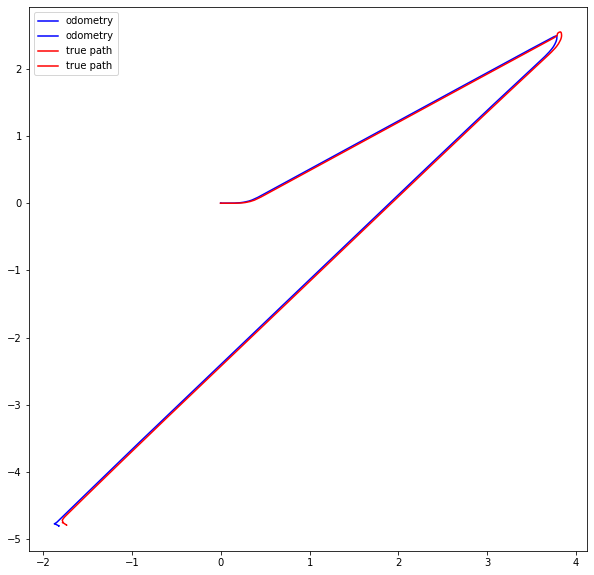

In [16]:
mr.kinematicModel.plot_paths()

The grid map is  340 x 240 .


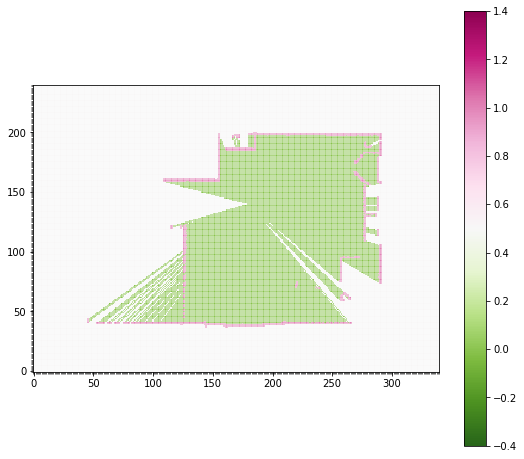

In [17]:
mr.point_cloud.compute_grid_ocupation()
mr.point_cloud.plot_grid_ocupation()

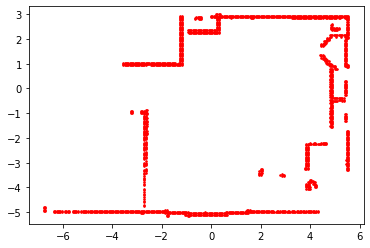

In [18]:
mr.point_cloud.update_grid_map_pos_points()
mr.point_cloud.plot_grid_map_pos_points()

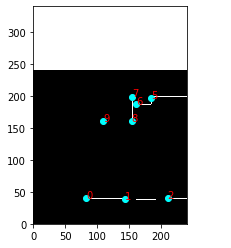

In [19]:
#Tem um bug nesse plot que nao mostra a figura toda
#quando a simulação é re-iniciada várias vezes
mr.point_cloud.plot_countour()

Done
Path length: 321


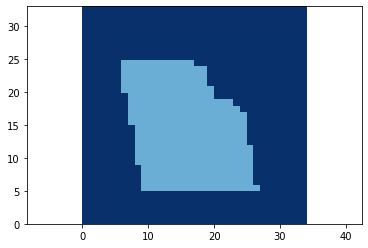

In [20]:
mr.do_planing()

AttributeError: module 'matplotlib.pyplot' has no attribute 'invert_yaxis'

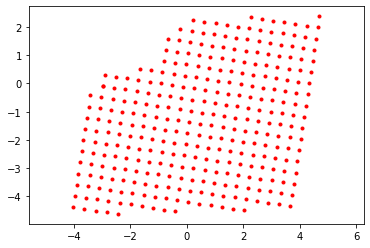

In [21]:
mr.plot_planning()

Avoid Obstacle pos (-1.7735952138900757, -4.75160551071167) goal 0 0oal 0 0ang:
1.2100740310974054
ang robot:
2.608220338821411
After:
2.608220338821411


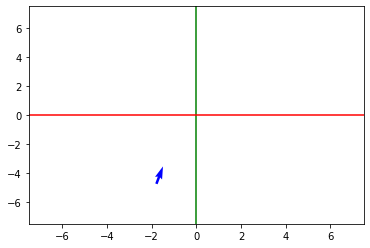

ang:
1.2097330012879013
ang robot:
2.592905282974243
After:
2.592905282974243


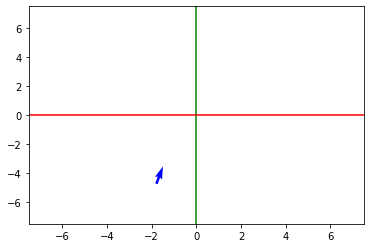

React rear collision pos (-1.7944629192352295, -4.743475437164307) goal 0 00 0ang:
1.2038306264705516
ang robot:
2.511949300765991
After:
2.511949300765991


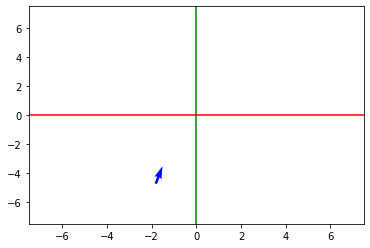

ang:
1.202245151098507
ang robot:
2.513240098953247
After:
2.513240098953247


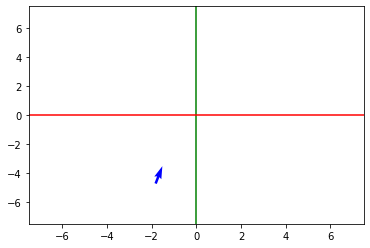

React rear collision pos (-1.87734854221344, -4.681982517242432) goal 0 00 00ang:
1.1812390249344802
ang robot:
2.3412089347839355
After:
2.3412089347839355


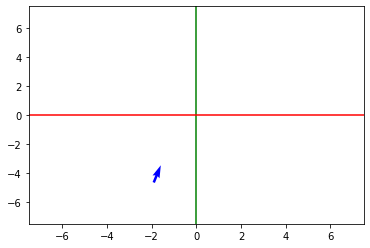

ang:
1.1779788700427334
ang robot:
2.341094493865967
After:
2.341094493865967


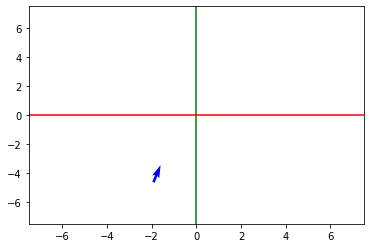

Turn 1.1779788700427334 pos (-1.924234390258789, -4.633423805236816) goal 0 0ang:
1.1768313223299862
ang robot:
2.295438051223755
After:
2.295438051223755


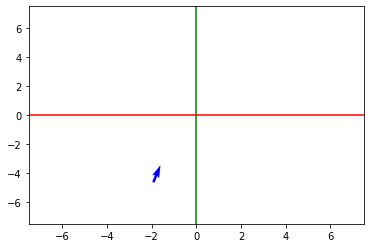

ang:
1.1763499533869057
ang robot:
2.2452564239501953
After:
2.2452564239501953


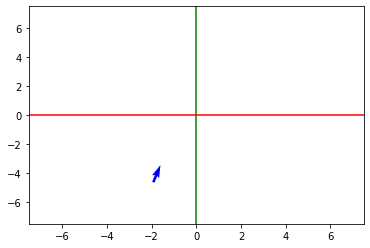

Turn 1.1763499533869057 pos (-1.9297975301742554, -4.634524345397949) goal 0 0ang:
1.1756515600957405
ang robot:
2.153313398361206
After:
2.153313398361206


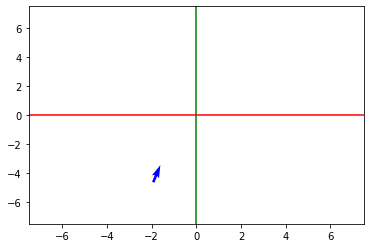

ang:
1.175375297968919
ang robot:
2.12974214553833
After:
2.12974214553833


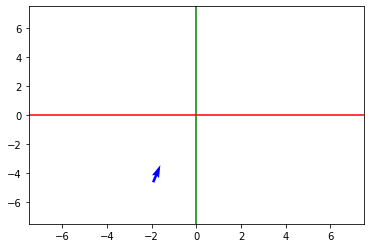

Turn 1.175375297968919 pos (-1.9355779886245728, -4.634856224060059) goal 0 0ang:
1.1746892974200709
ang robot:
2.070805549621582
After:
2.070805549621582


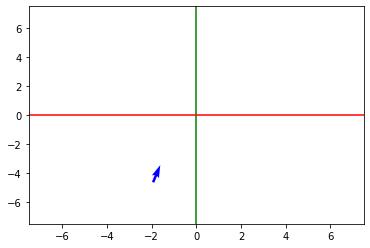

ang:
1.1740878567415787
ang robot:
2.0212879180908203
After:
2.0212879180908203


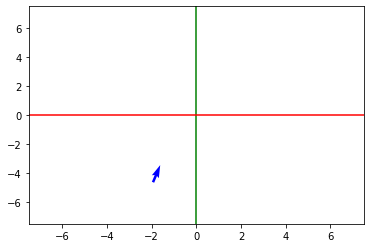

Turn 1.1740878567415787 pos (-1.942022681236267, -4.632994174957275) goal 0 0ang:
1.1733523209101904
ang robot:
1.9638112783432007
After:
1.9638112783432007


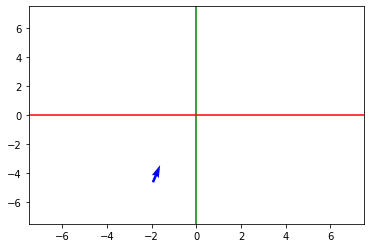

ang:
1.1727842223479565
ang robot:
1.9134820699691772
After:
1.9134820699691772


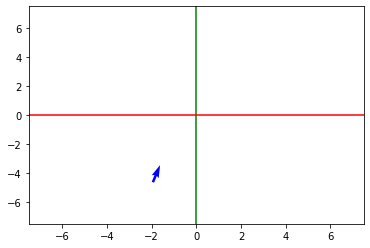

Turn 1.1727842223479565 pos (-1.9481405019760132, -4.63053035736084) goal 0 0ang:
1.1716770138093076
ang robot:
1.8261245489120483
After:
1.8261245489120483


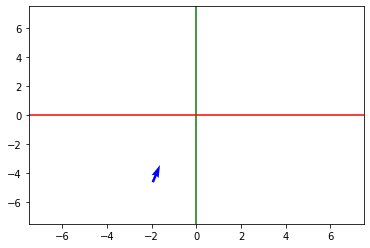

ang:
1.1713566978314522
ang robot:
1.80302894115448
After:
1.80302894115448


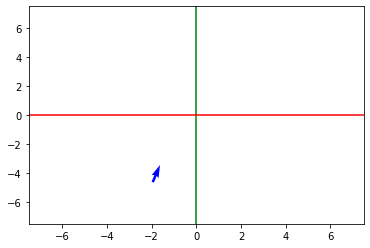

Turn 1.1713566978314522 pos (-1.9543092250823975, -4.626745700836182) goal 0 0ang:
1.1707532284883022
ang robot:
1.769533395767212
After:
1.769533395767212


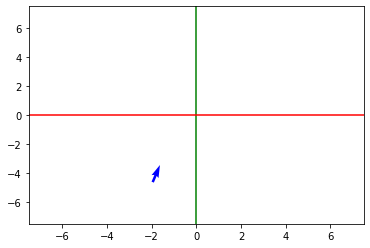

ang:
1.1706016851435903
ang robot:
1.7553246021270752
After:
1.7553246021270752


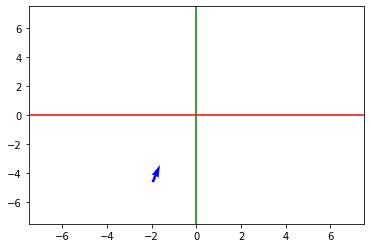

Turn 1.1706016851435903 pos (-1.9565904140472412, -4.624403476715088) goal 0 0ang:
1.1704075003298189
ang robot:
1.7350366115570068
After:
1.715328574180603


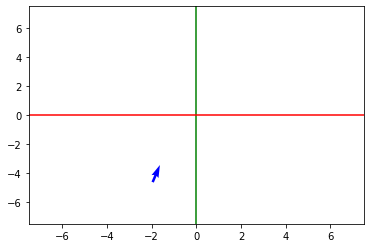

ang:
1.1700689351441071
ang robot:
1.695890188217163
After:
1.695890188217163


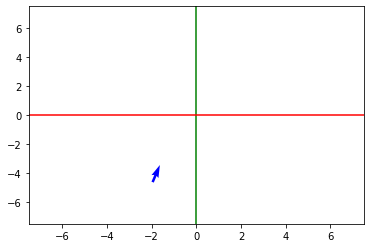

Turn 1.1700689351441071 pos (-1.959533452987671, -4.624108791351318) goal 0 0ang:
1.1696359376171659
ang robot:
1.6450872421264648
After:
1.6450872421264648


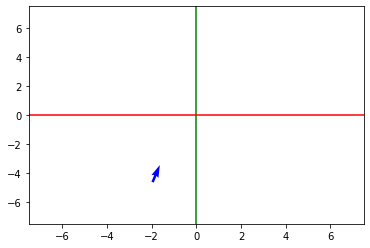

ang:
1.1690875619779155
ang robot:
1.5972824096679688
After:
1.5972824096679688


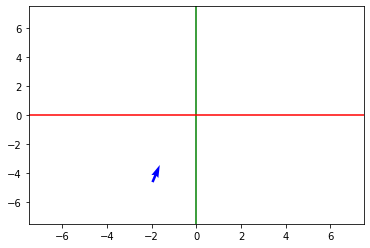

Turn 1.1690875619779155 pos (-1.964188575744629, -4.6213059425354) goal 0 0ang:
1.1684347206156014
ang robot:
1.5399771928787231
After:
1.5399771928787231


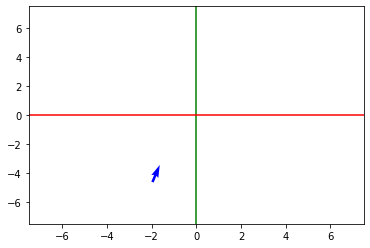

ang:
1.1678811395136977
ang robot:
1.4902517795562744
After:
1.4902517795562744


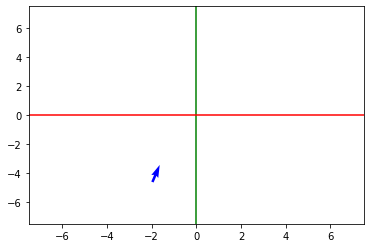

Turn 1.1678811395136977 pos (-1.9687639474868774, -4.616734027862549) goal 0 0ang:
1.166920375898044
ang robot:
1.4035935401916504
After:
1.4035935401916504


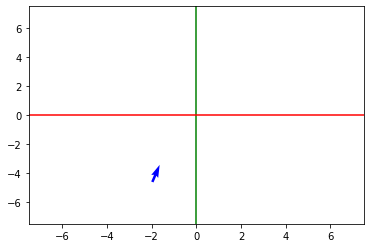

ang:
1.1666625205934569
ang robot:
1.3798013925552368
After:
1.3798013925552368


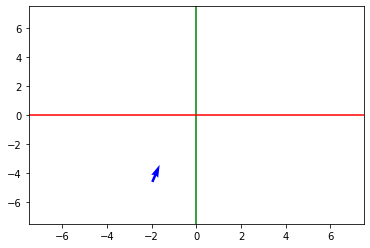

Turn 1.1666625205934569 pos (-1.9728797674179077, -4.610852241516113) goal 0 0ang:
1.165703909704963
ang robot:
1.2890832424163818
After:
1.2890832424163818


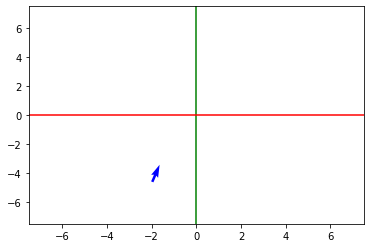

Go Forward pos (-1.9760650396347046, -4.605235576629639) goal 0 0ang:
1.1649005644903876
ang robot:
1.2243090867996216
After:
1.2243090867996216


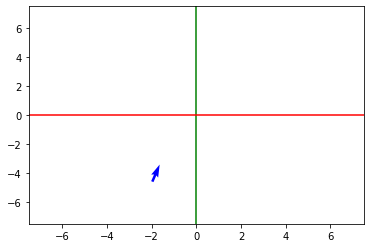

Go Forward pos (-1.9705591201782227, -4.583317756652832) goal 0 0ang:
1.1643722196753343
ang robot:
1.21742844581604
After:
1.21742844581604


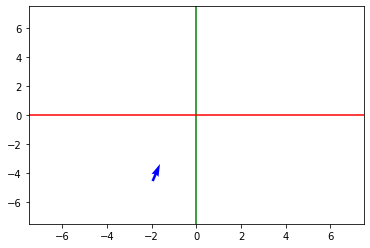

Go Forward pos (-1.9549528360366821, -4.541020393371582) goal 0 0ang:
1.164042417757761
ang robot:
1.2216551303863525
After:
1.2216551303863525


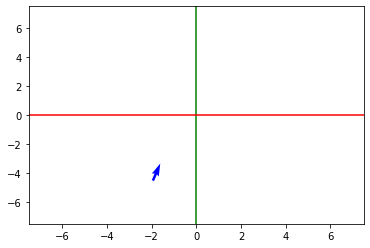

Go Forward pos (-1.940517783164978, -4.502104759216309) goal 0 0ang:
1.1636485423063254
ang robot:
1.2221765518188477
After:
1.2221765518188477


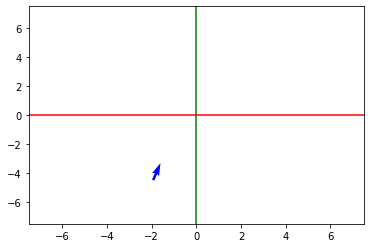

Go Forward pos (-1.9290428161621094, -4.470560550689697) goal 0 0ang:
1.1630066854069387
ang robot:
1.2222603559494019
After:
1.2222603559494019


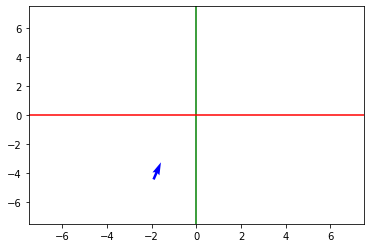

Go Forward pos (-1.9142745733261108, -4.4299421310424805) goal 0 0ang:
1.162473022453049
ang robot:
1.2222596406936646
After:
1.2222596406936646


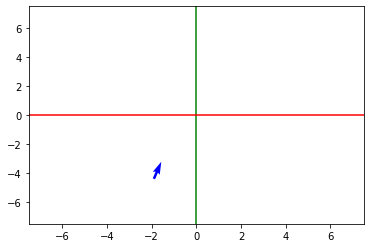

Go Forward pos (-1.8995044231414795, -4.389284133911133) goal 0 0ang:
1.1619858527659725
ang robot:
1.221850037574768
After:
1.221850037574768


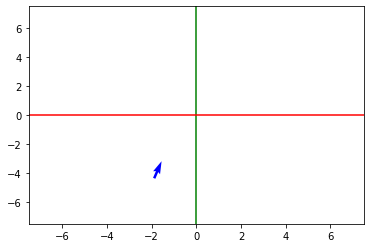

Go Forward pos (-1.8863277435302734, -4.353025913238525) goal 0 0ang:
1.1617349771463465
ang robot:
1.2215758562088013
After:
1.2215758562088013


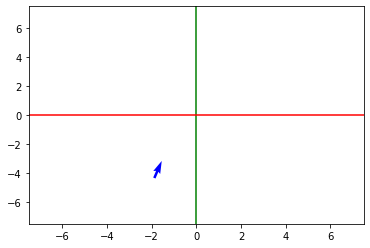

Go Forward pos (-1.8792307376861572, -4.333512783050537) goal 0 0ang:
1.161045140661146
ang robot:
1.2221492528915405
After:
1.2221492528915405


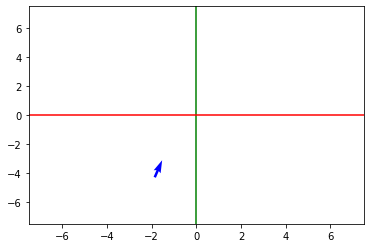

Go Forward pos (-1.8577840328216553, -4.274590492248535) goal 0 0ang:
1.1604073970303608
ang robot:
1.2222747802734375
After:
1.2222747802734375


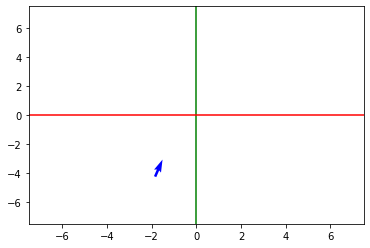

Go Forward pos (-1.8445708751678467, -4.238218307495117) goal 0 0ang:
1.159824308928444
ang robot:
1.2216966152191162
After:
1.2216966152191162


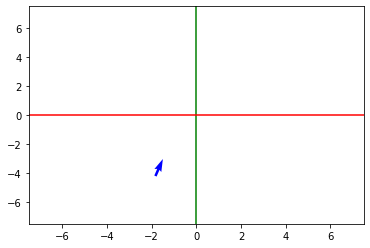

Go Forward pos (-1.8264665603637695, -4.188460826873779) goal 0 0ang:
1.1591025663870864
ang robot:
1.221537470817566
After:
1.221537470817566


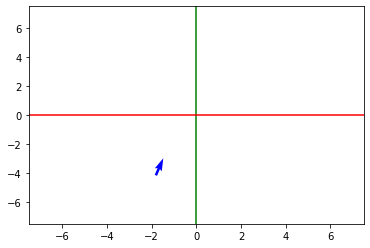

Go Forward pos (-1.811714768409729, -4.147898197174072) goal 0 0ang:
1.1586396483382992
ang robot:
1.2217828035354614
After:
1.2217828035354614


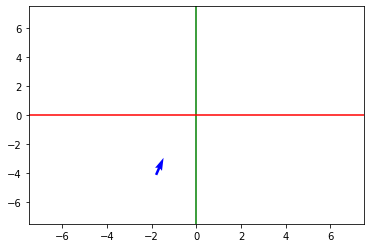

Go Forward pos (-1.7969812154769897, -4.10740327835083) goal 0 0ang:
1.1578861366993043
ang robot:
1.2209078073501587
After:
1.2209078073501587


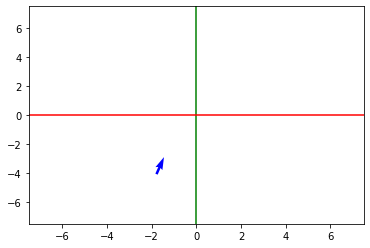

Go Forward pos (-1.7807782888412476, -4.062863349914551) goal 0 0ang:
1.1573319410485017
ang robot:
1.2206424474716187
After:
1.2206424474716187


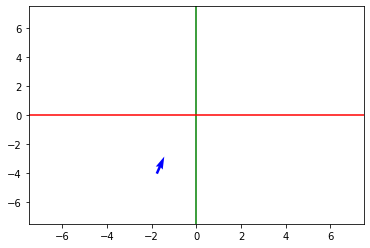

Go Forward pos (-1.7689316272735596, -4.030453681945801) goal 0 0ang:
1.156711811938135
ang robot:
1.220719575881958
After:
1.220719575881958


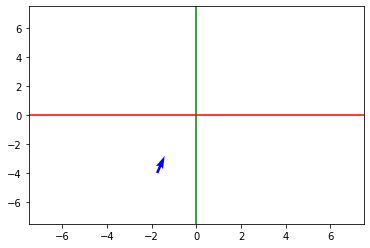

Go Forward pos (-1.7507673501968384, -3.9807465076446533) goal 0 0ang:
1.1559262457042359
ang robot:
1.2209423780441284
After:
1.2209423780441284


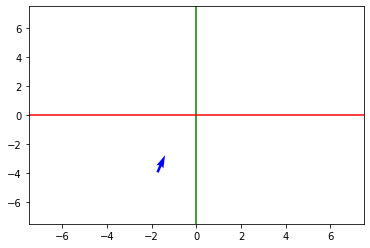

Go Forward pos (-1.7358858585357666, -3.9399917125701904) goal 0 0ang:
1.1552663691813536
ang robot:
1.2214021682739258
After:
1.2214021682739258


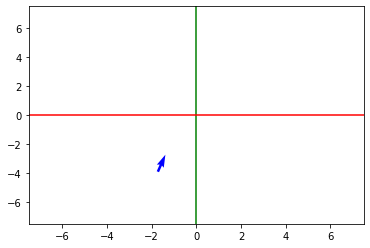

Go Forward pos (-1.7176501750946045, -3.890033721923828) goal 0 0ang:
1.154434231602013
ang robot:
1.2217682600021362
After:
1.2217682600021362


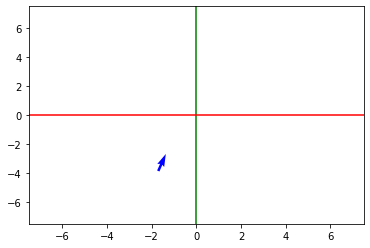

Go Forward pos (-1.7027753591537476, -3.849196195602417) goal 0 0ang:
1.153967627915878
ang robot:
1.2217402458190918
After:
1.2217402458190918


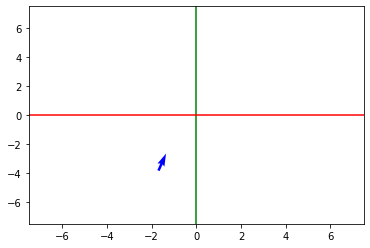

Go Forward pos (-1.6928431987762451, -3.8219223022460938) goal 0 0ang:
1.153256110928564
ang robot:
1.2216012477874756
After:
1.2216012477874756


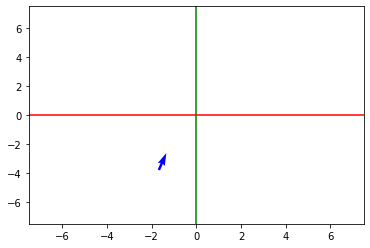

Go Forward pos (-1.6746807098388672, -3.7719757556915283) goal 0 0ang:
1.1525308067489957
ang robot:
1.2212443351745605
After:
1.2212443351745605


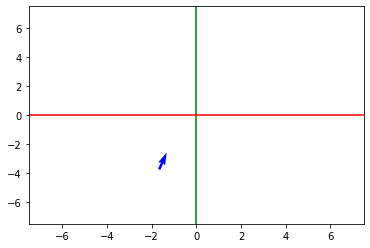

Go Forward pos (-1.65985107421875, -3.7312347888946533) goal 0 0ang:
1.151791737987201
ang robot:
1.2210946083068848
After:
1.2210946083068848


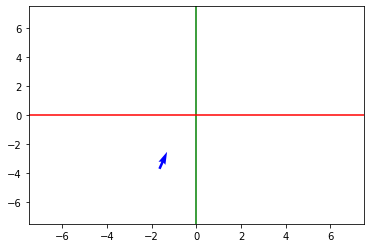

Go Forward pos (-1.6476863622665405, -3.6978797912597656) goal 0 0ang:
1.1510442000168455
ang robot:
1.2213505506515503
After:
1.2213505506515503


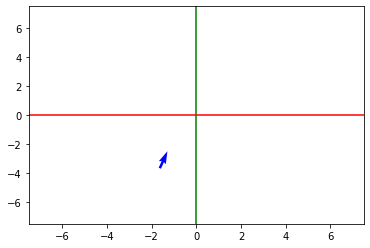

Go Forward pos (-1.631922721862793, -3.654613971710205) goal 0 0ang:
1.1503583498055907
ang robot:
1.2211761474609375
After:
1.2211761474609375


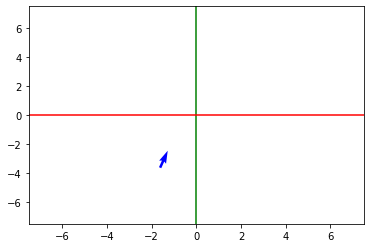

Go Forward pos (-1.6185762882232666, -3.617961883544922) goal 0 0ang:
1.149652343559097
ang robot:
1.2202244997024536
After:
1.2202244997024536


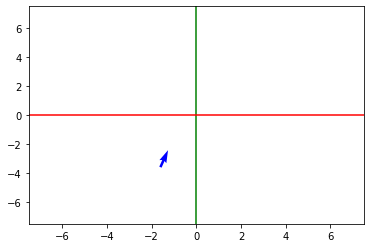

Go Forward pos (-1.6051915884017944, -3.5812480449676514) goal 0 0ang:
1.1491171236657272
ang robot:
1.2193257808685303
After:
1.2193257808685303


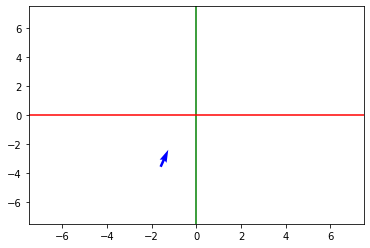

Go Forward pos (-1.5932538509368896, -3.5486412048339844) goal 0 0ang:
1.148138047935716
ang robot:
1.2180027961730957
After:
1.2180027961730957


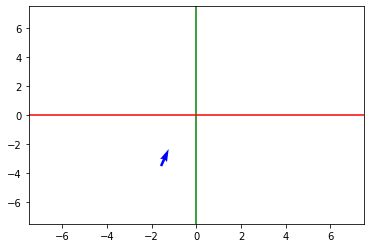

Go Forward pos (-1.5781787633895874, -3.5075175762176514) goal 0 0ang:
1.1476037256296574
ang robot:
1.2175981998443604
After:
1.2175981998443604


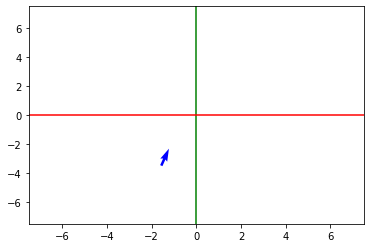

Go Forward pos (-1.567511796951294, -3.4785308837890625) goal 0 0ang:
1.1467833139935808
ang robot:
1.216958999633789
After:
1.216958999633789


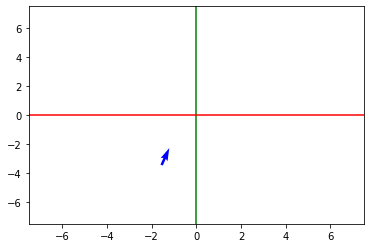

Go Forward pos (-1.5495511293411255, -3.4297263622283936) goal 0 0ang:
1.1458544396621884
ang robot:
1.2164413928985596
After:
1.2164413928985596


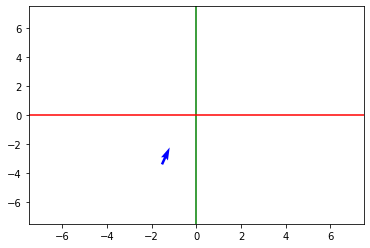

Go Forward pos (-1.5344352722167969, -3.388789653778076) goal 0 0ang:
1.1450984547631464
ang robot:
1.2153313159942627
After:
1.2153313159942627


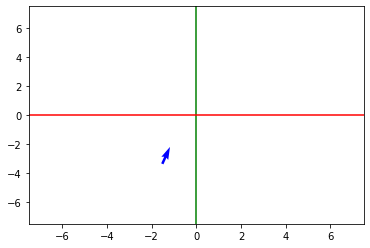

Go Forward pos (-1.5223724842071533, -3.3561458587646484) goal 0 0ang:
1.1442538619057383
ang robot:
1.2153068780899048
After:
1.2153068780899048


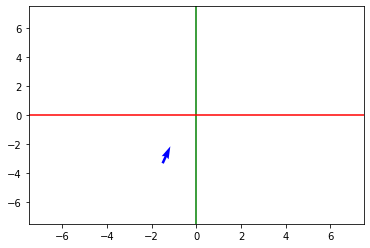

Go Forward pos (-1.5037286281585693, -3.3058979511260986) goal 0 0ang:
1.143191958897535
ang robot:
1.2157537937164307
After:
1.2157537937164307


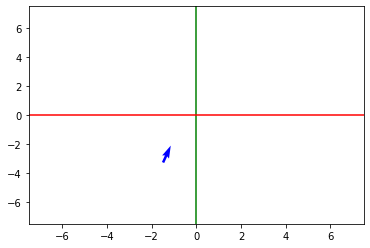

Go Forward pos (-1.485060453414917, -3.2555694580078125) goal 0 0ang:
1.1420955050813295
ang robot:
1.2158530950546265
After:
1.2158530950546265


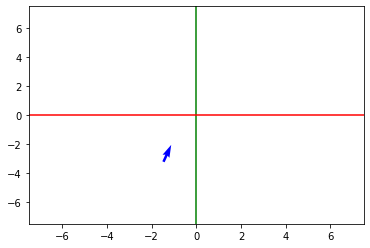

Go Forward pos (-1.4697544574737549, -3.2143492698669434) goal 0 0ang:
1.1412652860887145
ang robot:
1.2157151699066162
After:
1.2157151699066162


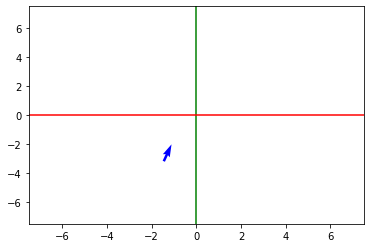

Go Forward pos (-1.456082820892334, -3.177391529083252) goal 0 0ang:
1.1403084799785905
ang robot:
1.2149173021316528
After:
1.2149173021316528


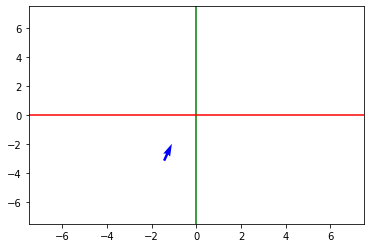

Go Forward pos (-1.4407157897949219, -3.135948896408081) goal 0 0ang:
1.139866979078743
ang robot:
1.2147775888442993
After:
1.2147775888442993


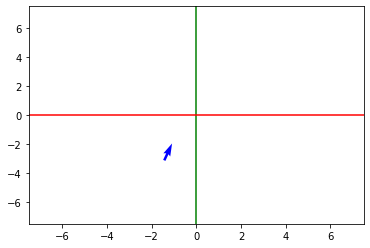

Go Forward pos (-1.4304661750793457, -3.1083364486694336) goal 0 0ang:
1.1386931807482366
ang robot:
1.2144516706466675
After:
1.2144516706466675


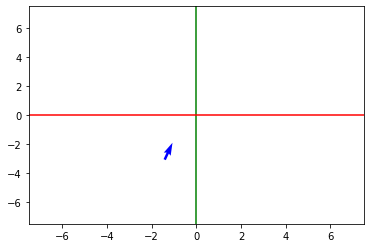

Go Forward pos (-1.4135162830352783, -3.062931776046753) goal 0 0ang:
1.1378066985522612
ang robot:
1.214428186416626
After:
1.214428186416626


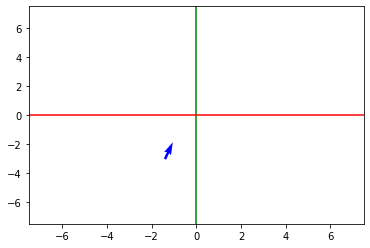

Go Forward pos (-1.4013307094573975, -3.0301270484924316) goal 0 0ang:
1.1367854057694027
ang robot:
1.2148494720458984
After:
1.2148494720458984


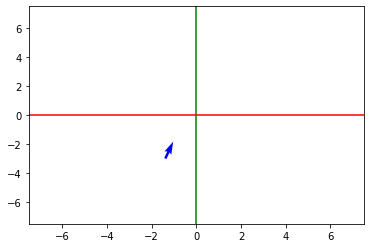

Go Forward pos (-1.3825128078460693, -2.9795522689819336) goal 0 0ang:
1.1354863575614935
ang robot:
1.214728593826294
After:
1.214728593826294


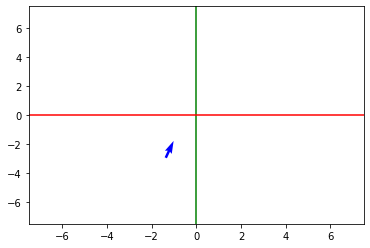

Go Forward pos (-1.3670203685760498, -2.937941789627075) goal 0 0ang:
1.1344049439345598
ang robot:
1.2153456211090088
After:
1.2153456211090088


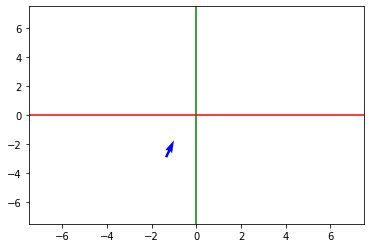

Go Forward pos (-1.351672649383545, -2.8966474533081055) goal 0 0ang:
1.1332607692627665
ang robot:
1.2148689031600952
After:
1.2148689031600952


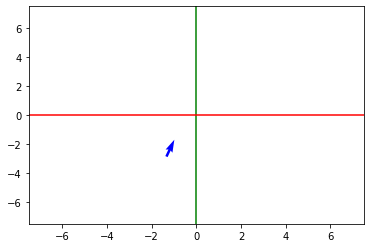

Go Forward pos (-1.336289644241333, -2.8551735877990723) goal 0 0ang:
1.1321112322586746
ang robot:
1.2153348922729492
After:
1.2153348922729492


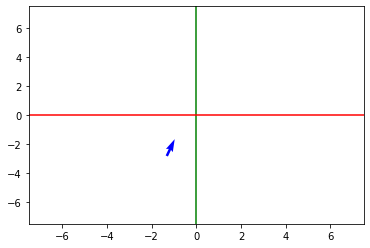

Go Forward pos (-1.317531704902649, -2.8046956062316895) goal 0 0ang:
1.1306537386275266
ang robot:
1.2162470817565918
After:
1.2162470817565918


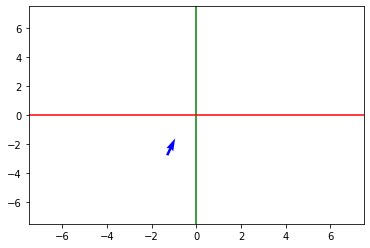

Go Forward pos (-1.3006455898284912, -2.7591700553894043) goal 0 0ang:
1.1300472348935804
ang robot:
1.2145352363586426
After:
1.2145352363586426


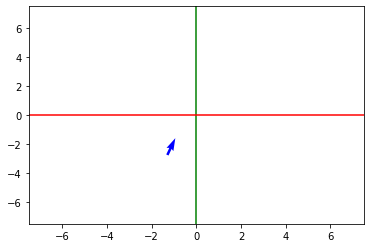

Go Forward pos (-1.291929006576538, -2.7354841232299805) goal 0 0ang:
1.128829091505337
ang robot:
1.2147527933120728
After:
1.2147527933120728


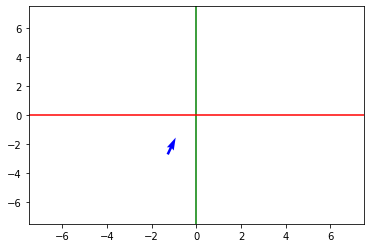

Go Forward pos (-1.2764580249786377, -2.694047451019287) goal 0 0ang:
1.1272631364292616
ang robot:
1.2151844501495361
After:
1.2151844501495361


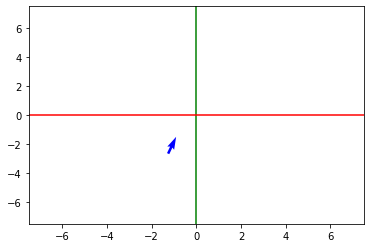

Go Forward pos (-1.2610523700714111, -2.652600049972534) goal 0 0ang:
1.1266385909098113
ang robot:
1.2151414155960083
After:
1.2151414155960083


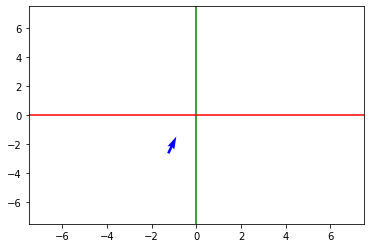

Go Forward pos (-1.250716209411621, -2.6247854232788086) goal 0 0ang:
1.125011923154765
ang robot:
1.215650200843811
After:
1.215650200843811


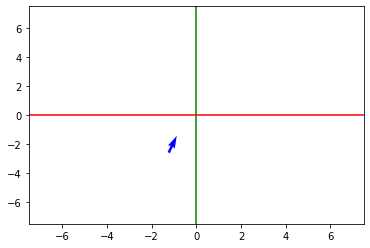

Go Forward pos (-1.2319045066833496, -2.574152708053589) goal 0 0ang:
1.1232946720051462
ang robot:
1.214402675628662
After:
1.214402675628662


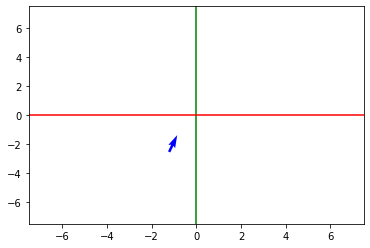

Go Forward pos (-1.2161189317703247, -2.531683921813965) goal 0 0ang:
1.1221731486772801
ang robot:
1.212835431098938
After:
1.212835431098938


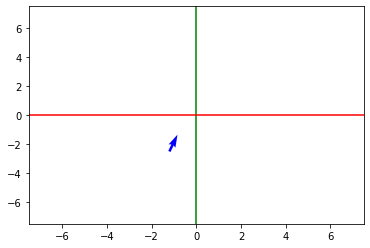

Go Forward pos (-1.2005951404571533, -2.4893131256103516) goal 0 0ang:
1.1206040314403063
ang robot:
1.212251901626587
After:
1.212251901626587


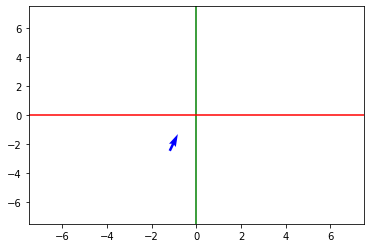

Go Forward pos (-1.1869667768478394, -2.4533703327178955) goal 0 0ang:
1.119283535699227
ang robot:
1.2118935585021973
After:
1.2118935585021973


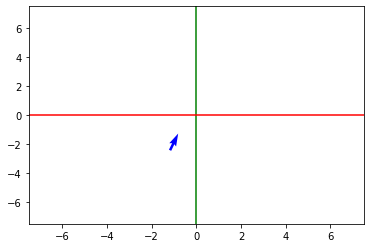

Go Forward pos (-1.1748355627059937, -2.421013355255127) goal 0 0ang:
1.1182785624816582
ang robot:
1.2114784717559814
After:
1.2114784717559814


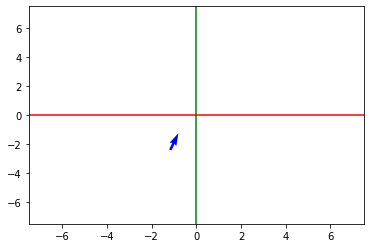

Go Forward pos (-1.1612458229064941, -2.3848016262054443) goal 0 0ang:
1.116394159380665
ang robot:
1.210707664489746
After:
1.210707664489746


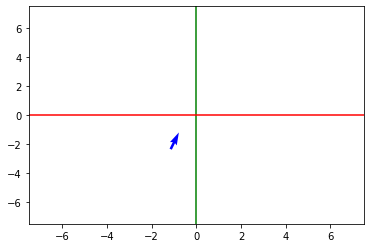

Go Forward pos (-1.1460751295089722, -2.344395160675049) goal 0 0ang:
1.115164051390508
ang robot:
1.2099697589874268
After:
1.2099697589874268


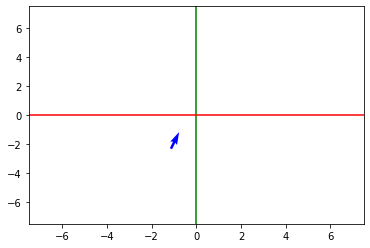

Go Forward pos (-1.1327707767486572, -2.3090286254882812) goal 0 0ang:
1.1140929688978072
ang robot:
1.20961594581604
After:
1.20961594581604


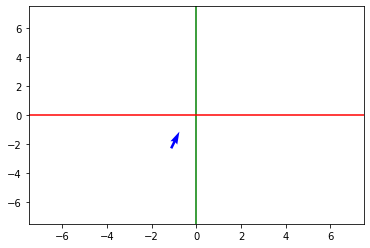

Go Forward pos (-1.120591640472412, -2.2767748832702637) goal 0 0ang:
1.112074420836551
ang robot:
1.2093424797058105
After:
1.2093424797058105


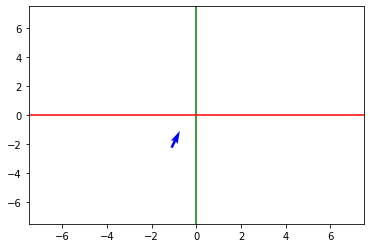

Go Forward pos (-1.1053472757339478, -2.2363905906677246) goal 0 0ang:
1.1105462717234043
ang robot:
1.2086660861968994
After:
1.2086660861968994


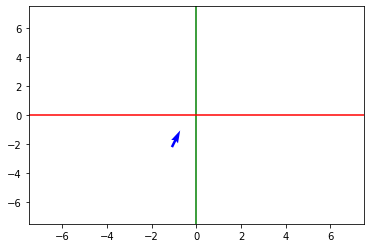

Go Forward pos (-1.0901596546173096, -2.196244478225708) goal 0 0ang:
1.1093763565779282
ang robot:
1.208538293838501
After:
1.208538293838501


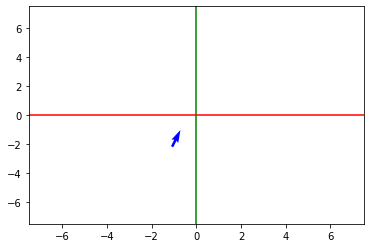

Go Forward pos (-1.0807894468307495, -2.171496868133545) goal 0 0ang:
1.1071688102435198
ang robot:
1.207413673400879
After:
1.207413673400879


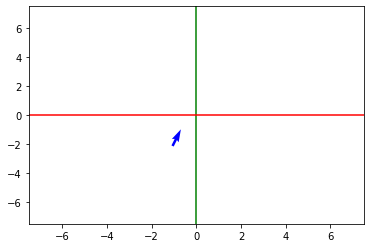

ang:
1.106830422734938
ang robot:
1.207357406616211
After:
1.207357406616211


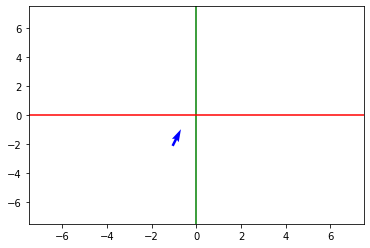

Turn 1.106830422734938 pos (-1.0611774921417236, -2.1196863651275635) goal 0 0ang:
1.105835150452988
ang robot:
1.1658384799957275
After:
1.1658384799957275


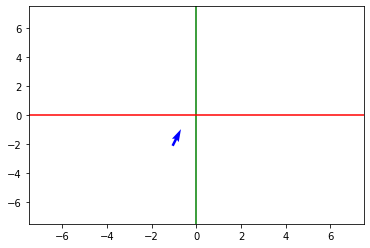

Go Forward pos (-1.063369870185852, -2.1179707050323486) goal 0 0ang:
1.1045164897954534
ang robot:
1.096696376800537
After:
1.096696376800537


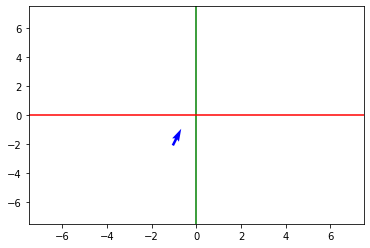

Go Forward pos (-1.0493676662445068, -2.0852227210998535) goal 0 0ang:
1.1047370347538485
ang robot:
1.1067321300506592
After:
1.1067321300506592


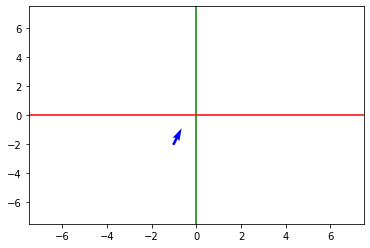

Go Forward pos (-1.0248644351959229, -2.03737735748291) goal 0 0ang:
1.1046969764873862
ang robot:
1.107513666152954
After:
1.107513666152954


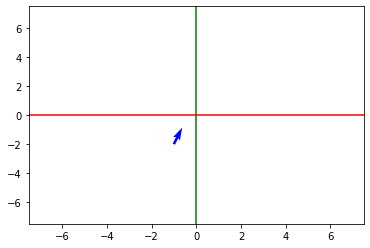

Go Forward pos (-1.0011193752288818, -1.9899237155914307) goal 0 0ang:
1.1046327992921159
ang robot:
1.107894778251648
After:
1.107894778251648


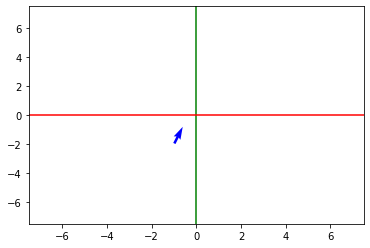

Go Forward pos (-0.977410614490509, -1.9424560070037842) goal 0 0ang:
1.1045456618125347
ang robot:
1.1072006225585938
After:
1.1072006225585938


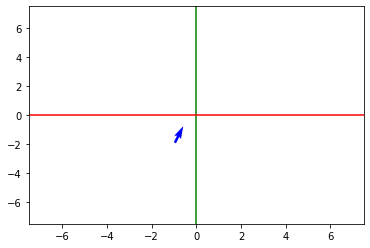

Go Forward pos (-0.9573623538017273, -1.9022705554962158) goal 0 0ang:
1.1044790136592053
ang robot:
1.1068451404571533
After:
1.1068451404571533


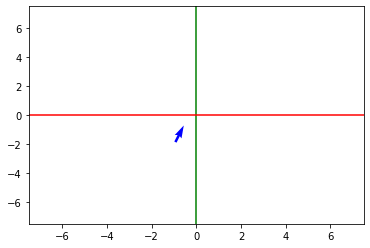

Go Forward pos (-0.9343368411064148, -1.8562068939208984) goal 0 0ang:
1.1044260854677235
ang robot:
1.1064324378967285
After:
1.1064324378967285


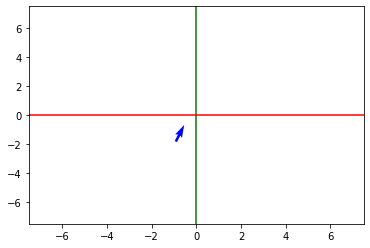

Go Forward pos (-0.9105961918830872, -1.8087583780288696) goal 0 0ang:
1.104364254152306
ang robot:
1.1059579849243164
After:
1.1059579849243164


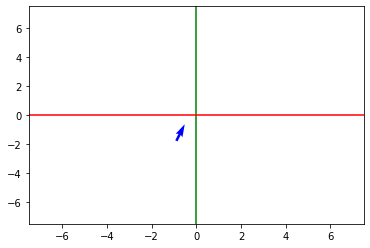

Go Forward pos (-0.8911978602409363, -1.7700283527374268) goal 0 0ang:
1.1043353507790072
ang robot:
1.1058522462844849
After:
1.1058522462844849


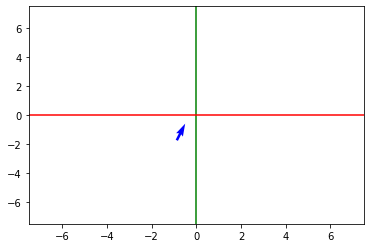

Go Forward pos (-0.8673769235610962, -1.7225725650787354) goal 0 0ang:
1.1042909438949795
ang robot:
1.105541467666626
After:
1.105541467666626


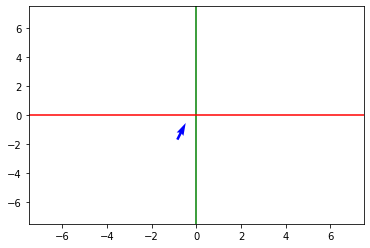

Go Forward pos (-0.843529224395752, -1.6749935150146484) goal 0 0ang:
1.1042327250126567
ang robot:
1.1045870780944824
After:
1.1045870780944824


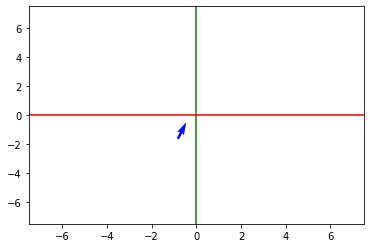

Go Forward pos (-0.8261489868164062, -1.6403337717056274) goal 0 0ang:
1.104226124450799
ang robot:
1.1046619415283203
After:
1.1046619415283203


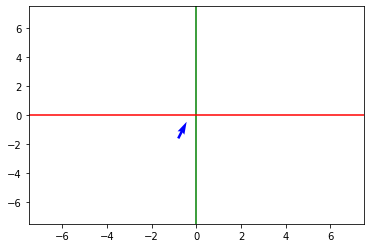

Go Forward pos (-0.8066708445549011, -1.6016120910644531) goal 0 0ang:
1.1042098393053918
ang robot:
1.1041909456253052
After:
1.1041909456253052


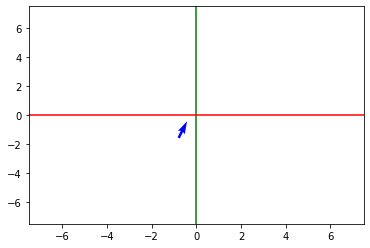

Go Forward pos (-0.7892419695854187, -1.5669571161270142) goal 0 0ang:
1.1042225958496277
ang robot:
1.1035528182983398
After:
1.1035528182983398


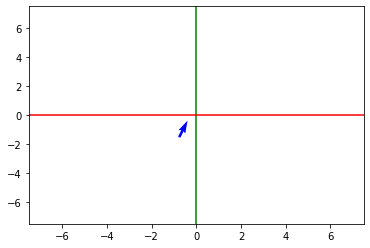

Go Forward pos (-0.765368640422821, -1.5196301937103271) goal 0 0ang:
1.1042442648582693
ang robot:
1.1034857034683228
After:
1.1034857034683228


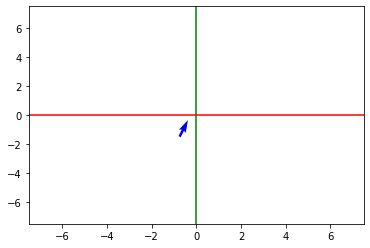

Go Forward pos (-0.7458342909812927, -1.4809067249298096) goal 0 0ang:
1.104271406138418
ang robot:
1.1046158075332642
After:
1.1046158075332642


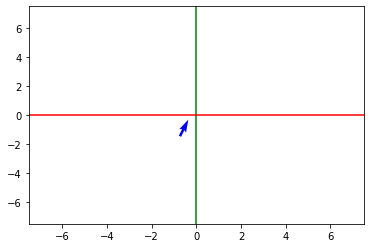

Go Forward pos (-0.7262712717056274, -1.442155361175537) goal 0 0ang:
1.1042700039279998
ang robot:
1.104742407798767
After:
1.104742407798767


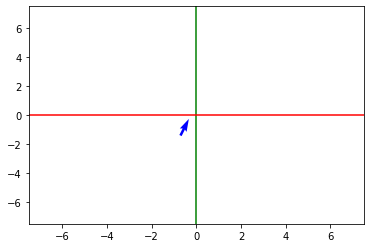

Go Forward pos (-0.7067710161209106, -1.4034059047698975) goal 0 0ang:
1.1042596625079268
ang robot:
1.104758858680725
After:
1.104758858680725


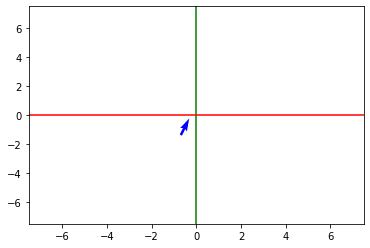

Go Forward pos (-0.6908954381942749, -1.3718576431274414) goal 0 0ang:
1.1042422376837577
ang robot:
1.1045926809310913
After:
1.1045926809310913


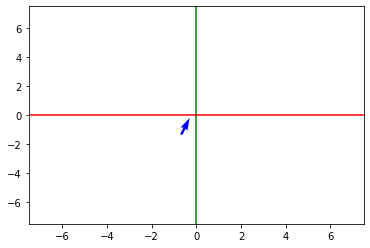

Go Forward pos (-0.6721339821815491, -1.3345520496368408) goal 0 0ang:
1.1042071033859917
ang robot:
1.1035723686218262
After:
1.1035723686218262


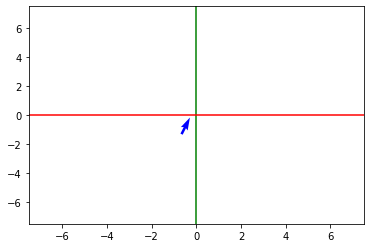

Go Forward pos (-0.6591086387634277, -1.3086049556732178) goal 0 0ang:
1.104226641349903
ang robot:
1.1039716005325317
After:
1.1039716005325317


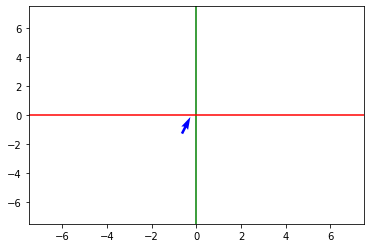

Go Forward pos (-0.6396370530128479, -1.270006775856018) goal 0 0ang:
1.1042110752545704
ang robot:
1.1029980182647705
After:
1.1029980182647705


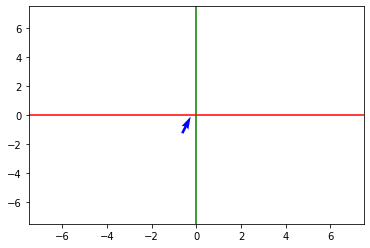

Go Forward pos (-0.6258548498153687, -1.2425905466079712) goal 0 0ang:
1.1042447137657654
ang robot:
1.1023378372192383
After:
1.1023378372192383


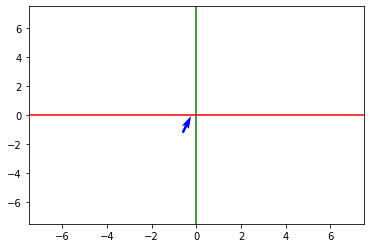

Go Forward pos (-0.6027973890304565, -1.1969670057296753) goal 0 0ang:
1.104333570257412
ang robot:
1.102663278579712
After:
1.102663278579712


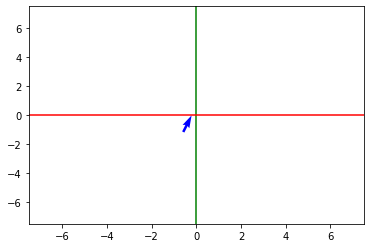

Go Forward pos (-0.578880250453949, -1.1497671604156494) goal 0 0ang:
1.104410224455373
ang robot:
1.1030093431472778
After:
1.1030093431472778


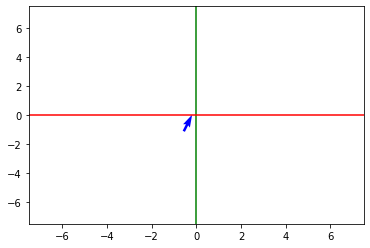

Go Forward pos (-0.5550222992897034, -1.1025378704071045) goal 0 0ang:
1.1044585742610478
ang robot:
1.1033904552459717
After:
1.1033904552459717


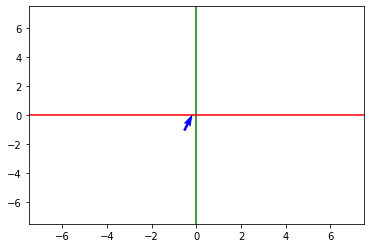

Go Forward pos (-0.5357646346092224, -1.0643876791000366) goal 0 0ang:
1.1044608053189
ang robot:
1.1027450561523438
After:
1.1027450561523438


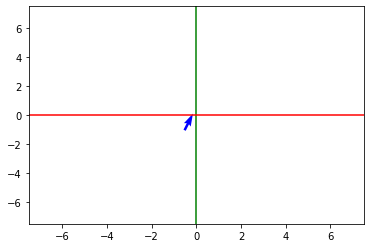

Go Forward pos (-0.5219627618789673, -1.036972999572754) goal 0 0ang:
1.1045502694425968
ang robot:
1.1036477088928223
After:
1.1036477088928223


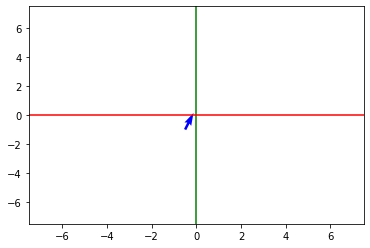

Go Forward pos (-0.49891573190689087, -0.9913982152938843) goal 0 0ang:
1.1045769905896945
ang robot:
1.1034411191940308
After:
1.1034411191940308


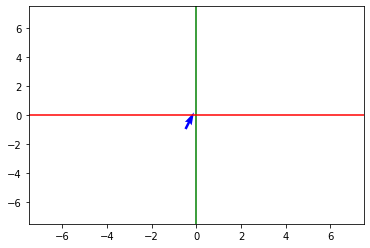

Go Forward pos (-0.4794541299343109, -0.9528009295463562) goal 0 0ang:
1.1046235380107734
ang robot:
1.1038333177566528
After:
1.1038333177566528


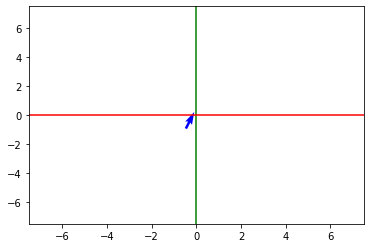

Go Forward pos (-0.45991095900535583, -0.9141073226928711) goal 0 0ang:
1.10465380608936
ang robot:
1.103453516960144
After:
1.103453516960144


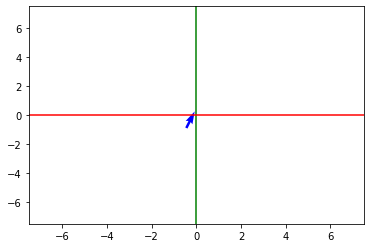

Go Forward pos (-0.44045406579971313, -0.8754808306694031) goal 0 0ang:
1.1047050330040988
ang robot:
1.103295087814331
After:
1.103295087814331


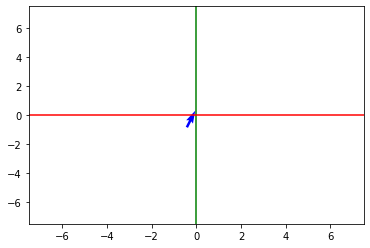

Go Forward pos (-0.4190038740634918, -0.832976222038269) goal 0 0ang:
1.1047235983665813
ang robot:
1.1027119159698486
After:
1.1027119159698486


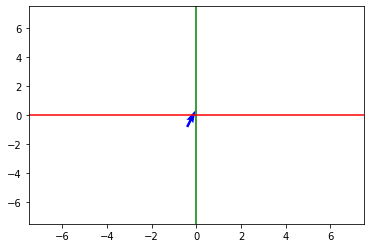

Go Forward pos (-0.407867968082428, -0.8108536005020142) goal 0 0ang:
1.1047373506364397
ang robot:
1.101876139640808
After:
1.101876139640808


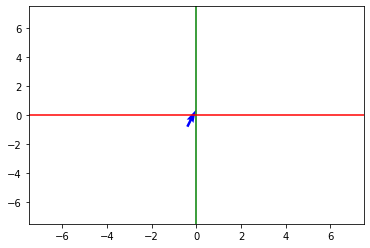

Go Forward pos (-0.39474326372146606, -0.7848635911941528) goal 0 0ang:
1.104901976381925
ang robot:
1.1021541357040405
After:
1.1021541357040405


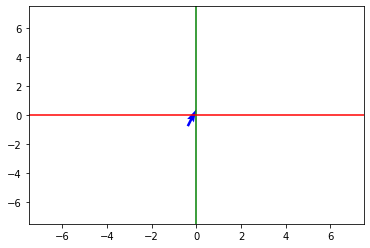

Go Forward pos (-0.37872618436813354, -0.7532635927200317) goal 0 0ang:
1.1050413298305894
ang robot:
1.102475643157959
After:
1.102475643157959


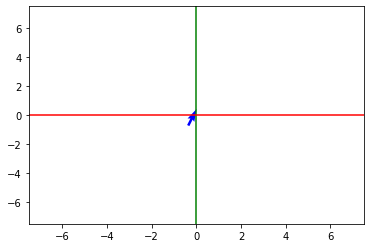

Go Forward pos (-0.35980814695358276, -0.7159095406532288) goal 0 0ang:
1.1051968646858497
ang robot:
1.1033263206481934
After:
1.1033263206481934


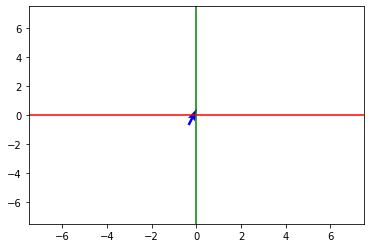

Go Forward pos (-0.3400358557701111, -0.6768096685409546) goal 0 0ang:
1.1052590751725255
ang robot:
1.1027344465255737
After:
1.1027344465255737


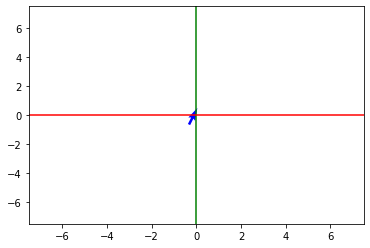

Go Forward pos (-0.3203834593296051, -0.6378545165061951) goal 0 0ang:
1.1054489859358787
ang robot:
1.1028172969818115
After:
1.1028172969818115


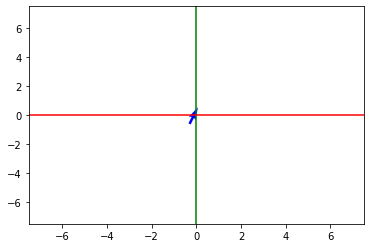

Go Forward pos (-0.300664484500885, -0.5988332033157349) goal 0 0ang:
1.1056304864357853
ang robot:
1.1029490232467651
After:
1.1029490232467651


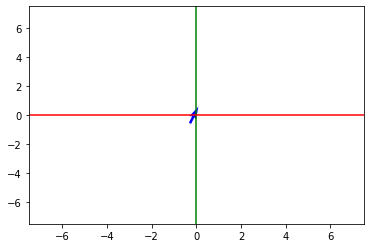

Go Forward pos (-0.28106462955474854, -0.5600556135177612) goal 0 0ang:
1.1057621852834956
ang robot:
1.1027694940567017
After:
1.1027694940567017


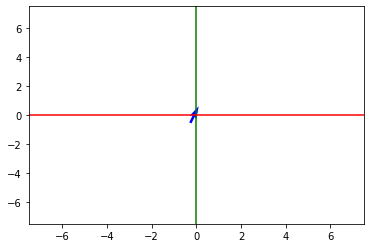

Go Forward pos (-0.2615468502044678, -0.521415114402771) goal 0 0ang:
1.1060581999307089
ang robot:
1.103190302848816
After:
1.103190302848816


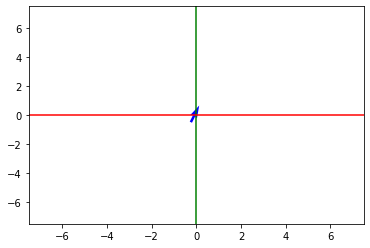

Go Forward pos (-0.24200794100761414, -0.48277610540390015) goal 0 0ang:
1.10633744716544
ang robot:
1.1048740148544312
After:
1.1048740148544312


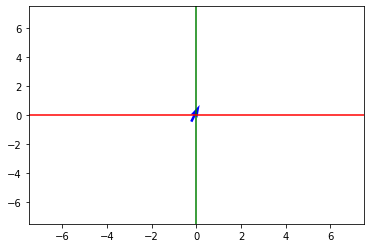

Go Forward pos (-0.2181623876094818, -0.4355086386203766) goal 0 0ang:
1.1065166863871148
ang robot:
1.1057237386703491
After:
1.1057237386703491


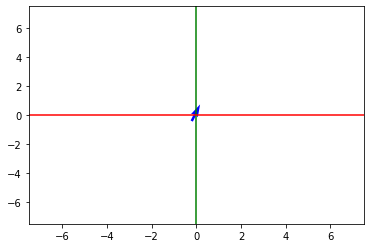

Go Forward pos (-0.19864338636398315, -0.3967125117778778) goal 0 0ang:
1.1066133271600047
ang robot:
1.10624098777771
After:
1.10624098777771


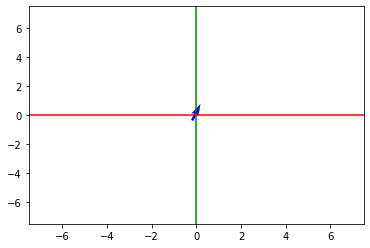

Go Forward pos (-0.18359652161598206, -0.36672812700271606) goal 0 0ang:
1.1066569149480638
ang robot:
1.1068111658096313
After:
1.1068111658096313


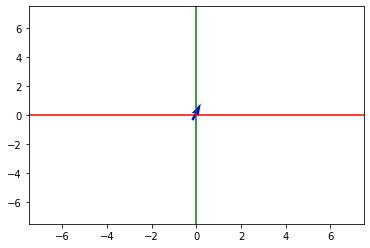

Go Forward pos (-0.1686815470457077, -0.3369982838630676) goal 0 0ang:
1.106563227041485
ang robot:
1.1062618494033813
After:
1.1062618494033813


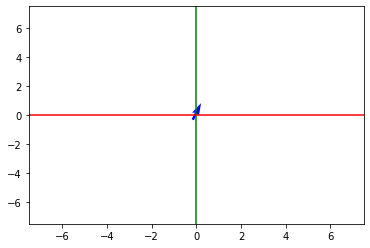

Go Forward pos (-0.15760135650634766, -0.3147802948951721) goal 0 0ang:
1.106665720691021
ang robot:
1.1075652837753296
After:
1.1075652837753296


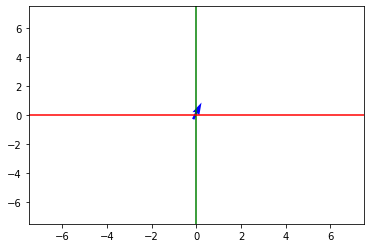

Go Forward pos (-0.13809964060783386, -0.2758702337741852) goal 0 0ang:
1.106663743645893
ang robot:
1.1091539859771729
After:
1.1091539859771729


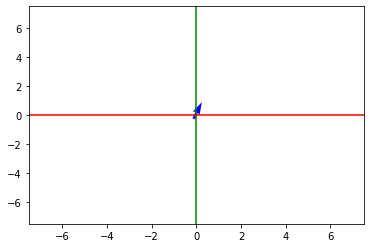

Go Forward pos (-0.11870323121547699, -0.2370438128709793) goal 0 0ang:
1.106198119653691
ang robot:
1.1098484992980957
After:
1.1098484992980957


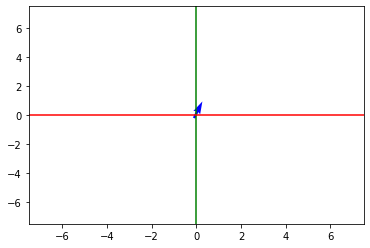

Go Forward pos (-0.09938688576221466, -0.19826720654964447) goal 0 0ang:
1.1058205191209207
ang robot:
1.1116902828216553
After:
1.1116902828216553


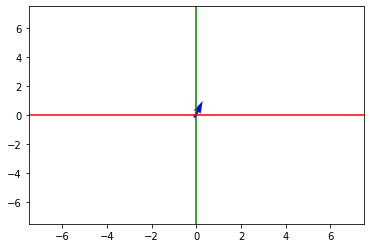

Go Forward pos (-0.08002589643001556, -0.1593295931816101) goal 0 0ang:
1.1043855595965213
ang robot:
1.1131112575531006
After:
1.1131112575531006


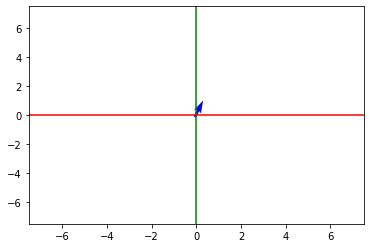

Go Forward pos (-0.06317231059074402, -0.12529464066028595) goal 0 0ang:
1.1014930956291995
ang robot:
1.1129999160766602
After:
1.1129999160766602


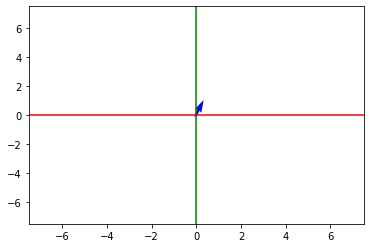

Go Forward pos (-0.047890834510326385, -0.09426148980855942) goal 0 0Next Planned step  0 / 321 3.6661414675272166 -4.340438219418542
ang:
0.8579410236477332
ang robot:
1.1143085956573486
After:
1.1143085956573486


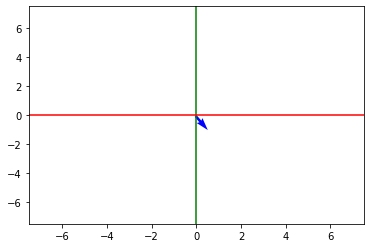

ang:
0.8599538814348364
ang robot:
1.1151399612426758
After:
1.1151399612426758


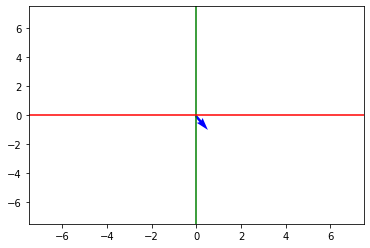

Turn 0.8599538814348364 pos (-0.026383956894278526, -0.0506579764187336) goal 3.6661414675272166 -4.340438219418542ang:
0.859998563697969
ang robot:
1.0917799472808838
After:
1.0917799472808838


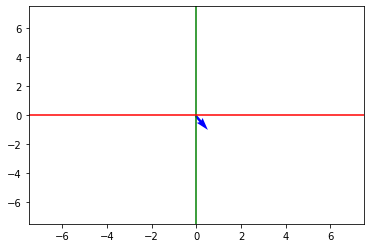

ang:
0.8598850946952871
ang robot:
1.0524237155914307
After:
1.0524237155914307


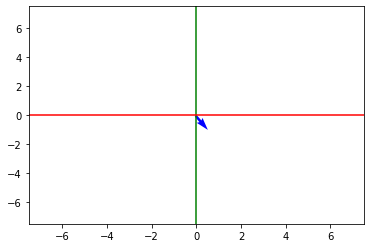

Turn 0.8598850946952871 pos (-0.029713723808526993, -0.049680039286613464) goal 3.6661414675272166 -4.340438219418542ang:
0.8595407420986622
ang robot:
0.970332145690918
After:
0.970332145690918


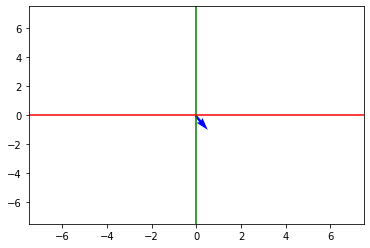

Go Forward pos (-0.033020228147506714, -0.04689225181937218) goal 3.6661414675272166 -4.340438219418542ang:
0.8614676632589255
ang robot:
0.8547778129577637
After:
0.8547778129577637


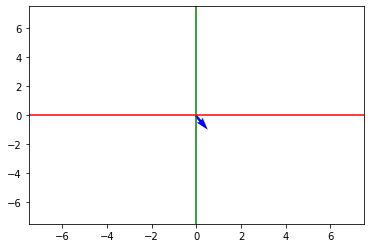

Go Forward pos (-0.021160615608096123, -0.025351041927933693) goal 3.6661414675272166 -4.340438219418542ang:
0.8673472048348637
ang robot:
0.7987473011016846
After:
0.7987473011016846


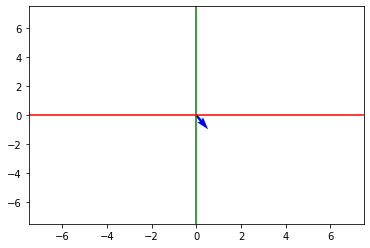

Go Forward pos (-0.0021262080408632755, -0.003685360075905919) goal 3.6661414675272166 -4.340438219418542ang:
0.873214888628413
ang robot:
0.8013114929199219
After:
0.8013114929199219


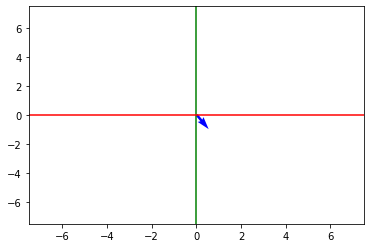

ang:
0.8763331918547935
ang robot:
0.8016940951347351
After:
0.8016940951347351


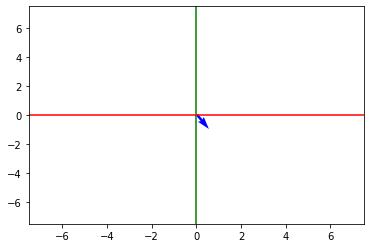

Turn -0.8763331918547935 pos (0.03132682666182518, 0.030481617897748947) goal 3.6661414675272166 -4.340438219418542ang:
0.8772115873671965
ang robot:
0.7793951034545898
After:
0.7793951034545898


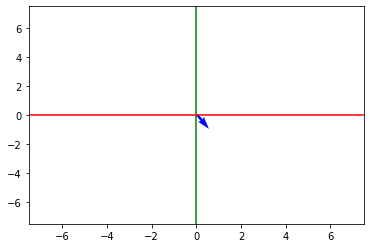

ang:
0.8771971770099601
ang robot:
0.7657187581062317
After:
0.7657187581062317


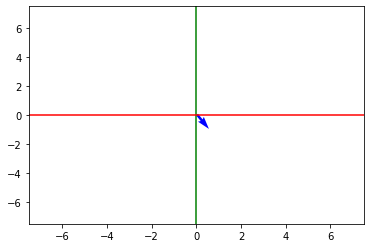

Turn -0.8771971770099601 pos (0.030211711302399635, 0.03215467557311058) goal 3.6661414675272166 -4.340438219418542ang:
0.8773191467298608
ang robot:
0.732554018497467
After:
0.732554018497467


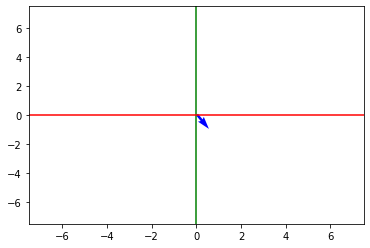

ang:
0.877612658425114
ang robot:
0.6891247630119324
After:
0.6891247630119324


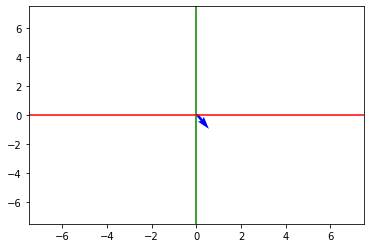

Turn -0.877612658425114 pos (0.03008001111447811, 0.03693445026874542) goal 3.6661414675272166 -4.340438219418542ang:
0.8777651761137862
ang robot:
0.6353545188903809
After:
0.6353545188903809


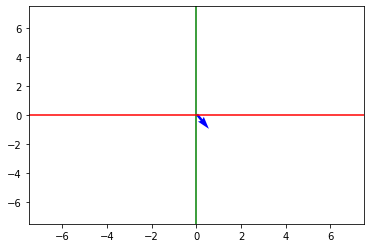

ang:
0.8780009935937119
ang robot:
0.5841816663742065
After:
0.5841816663742065


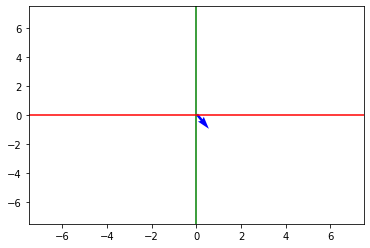

Turn -0.8780009935937119 pos (0.028966430574655533, 0.04221446067094803) goal 3.6661414675272166 -4.340438219418542ang:
0.8783582163322337
ang robot:
0.4976367652416229
After:
0.4976367652416229


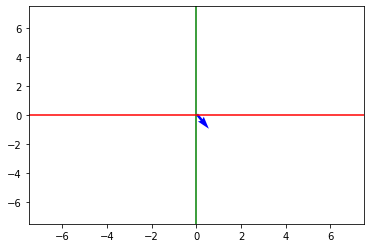

ang:
0.8785057583043758
ang robot:
0.47391587495803833
After:
0.47391587495803833


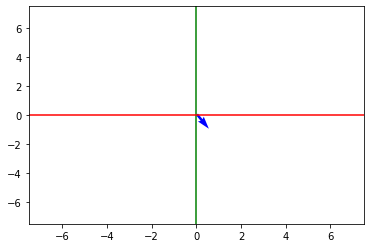

Turn -0.8785057583043758 pos (0.028731156140565872, 0.04733004420995712) goal 3.6661414675272166 -4.340438219418542ang:
0.8789753829702414
ang robot:
0.41358527541160583
After:
0.41358527541160583


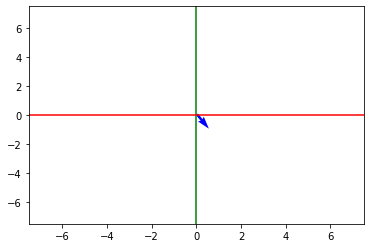

ang:
0.8791446284665922
ang robot:
0.38603636622428894
After:
0.38603636622428894


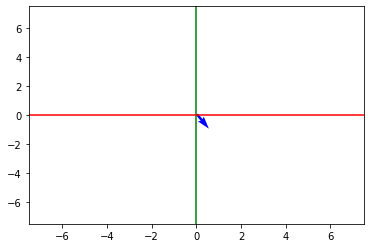

Turn -0.8791446284665922 pos (0.029952481389045715, 0.05320598557591438) goal 3.6661414675272166 -4.340438219418542ang:
0.8797965274649914
ang robot:
0.30197903513908386
After:
0.30197903513908386


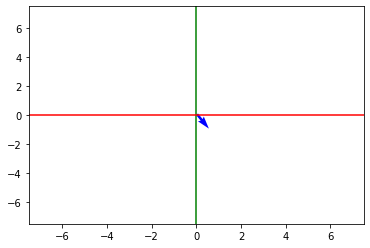

ang:
0.8801788237952183
ang robot:
0.2513211965560913
After:
0.2513211965560913


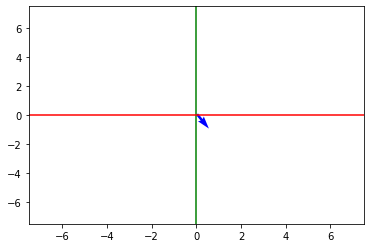

Turn -0.8801788237952183 pos (0.03175137937068939, 0.05886148661375046) goal 3.6661414675272166 -4.340438219418542ang:
0.880884084816872
ang robot:
0.1650625467300415
After:
0.1650625467300415


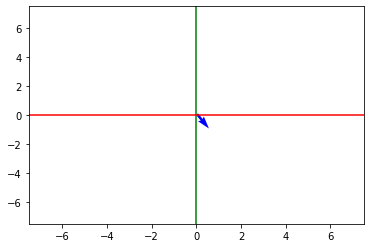

ang:
0.8811100561923905
ang robot:
0.1430896371603012
After:
0.1430896371603012


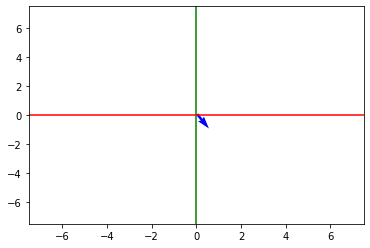

Turn -0.8811100561923905 pos (0.035128749907016754, 0.06438115239143372) goal 3.6661414675272166 -4.340438219418542ang:
0.8815363704272615
ang robot:
0.09240330755710602
After:
0.09240330755710602


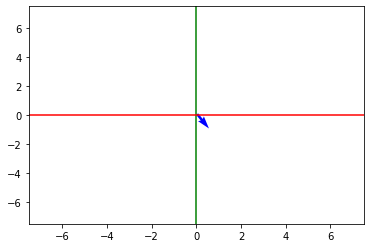

ang:
0.8819492557421644
ang robot:
0.043425604701042175
After:
0.043425604701042175


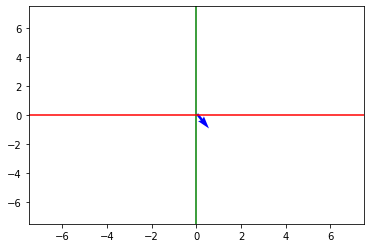

Turn -0.8819492557421644 pos (0.03670813515782356, 0.06880722939968109) goal 3.6661414675272166 -4.340438219418542ang:
0.8825023349788863
ang robot:
-0.017149295657873154
After:
-0.017149295657873154


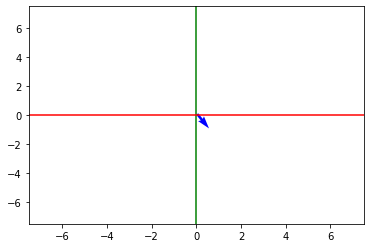

ang:
0.8829600227720842
ang robot:
-0.06903919577598572
After:
-0.06903919577598572


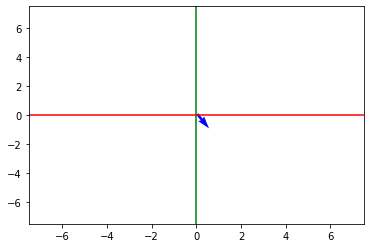

Turn -0.8829600227720842 pos (0.040253348648548126, 0.07370372116565704) goal 3.6661414675272166 -4.340438219418542ang:
0.8837530418846297
ang robot:
-0.1558237224817276
After:
-0.1558237224817276


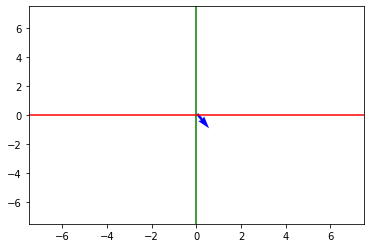

ang:
0.8842281699889015
ang robot:
-0.1979910284280777
After:
-0.1979910284280777


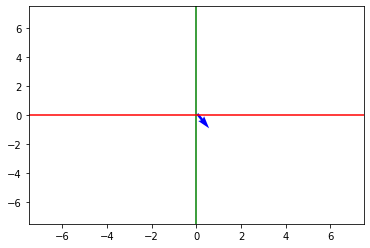

Turn -0.8842281699889015 pos (0.04565311223268509, 0.07830479741096497) goal 3.6661414675272166 -4.340438219418542ang:
0.8847989289304586
ang robot:
-0.26668450236320496
After:
-0.26668450236320496


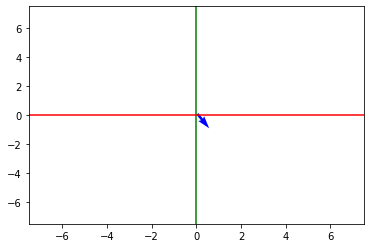

ang:
0.8850160427996658
ang robot:
-0.29033830761909485
After:
-0.29033830761909485


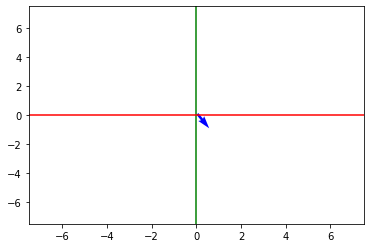

Turn -0.8850160427996658 pos (0.0491584837436676, 0.08214125782251358) goal 3.6661414675272166 -4.340438219418542ang:
0.8855238707798838
ang robot:
-0.3481782078742981
After:
-0.3481782078742981


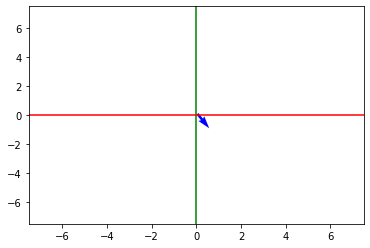

ang:
0.8857400690627654
ang robot:
-0.3810817003250122
After:
-0.3810817003250122


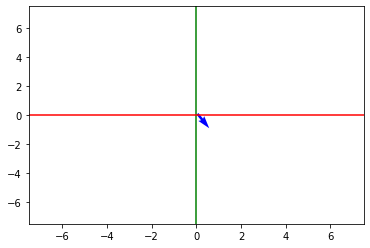

Turn -0.8857400690627654 pos (0.05023214966058731, 0.08523228019475937) goal 3.6661414675272166 -4.340438219418542ang:
0.8858229702034924
ang robot:
-0.39429283142089844
After:
-0.39429283142089844


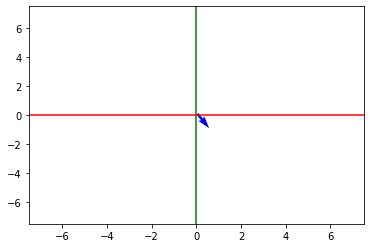

ang:
0.8861268284129459
ang robot:
-0.4369718134403229
After:
-0.4369718134403229


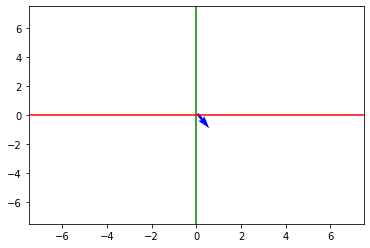

Turn -0.8861268284129459 pos (0.051657892763614655, 0.08775641024112701) goal 3.6661414675272166 -4.340438219418542ang:
0.886514238693861
ang robot:
-0.4887426495552063
After:
-0.4887426495552063


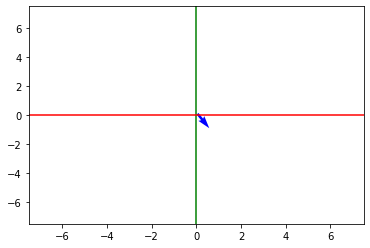

ang:
0.8869778114666268
ang robot:
-0.5405908823013306
After:
-0.5405908823013306


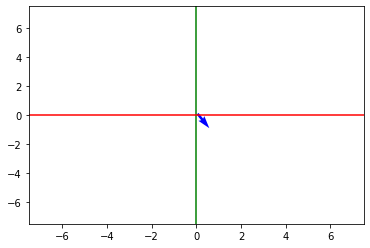

Turn -0.8869778114666268 pos (0.0561402253806591, 0.09067408740520477) goal 3.6661414675272166 -4.340438219418542ang:
0.887556398742927
ang robot:
-0.6023491621017456
After:
-0.6023491621017456


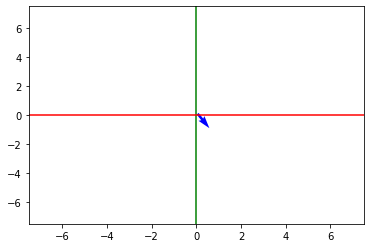

ang:
0.8877139159745315
ang robot:
-0.6227370500564575
After:
-0.6227370500564575


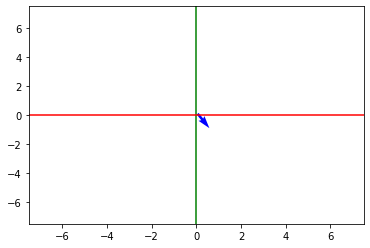

Turn -0.8877139159745315 pos (0.059238921850919724, 0.0928875282406807) goal 3.6661414675272166 -4.340438219418542ang:
0.8880979285634
ang robot:
-0.6730181574821472
After:
-0.6730181574821472


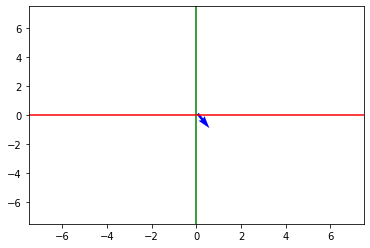

ang:
0.8885306183304738
ang robot:
-0.7242059111595154
After:
-0.7242059111595154


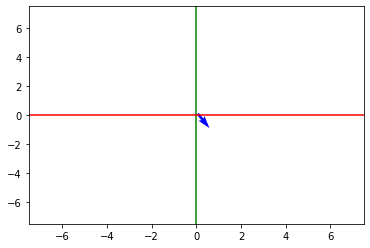

Turn -0.8885306183304738 pos (0.06366734206676483, 0.09512893110513687) goal 3.6661414675272166 -4.340438219418542ang:
0.8893651617279233
ang robot:
-0.8211436867713928
After:
-0.8211436867713928


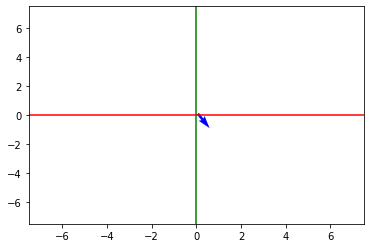

Go Forward pos (0.07057888805866241, 0.09563742578029633) goal 3.6661414675272166 -4.340438219418542ang:
0.8897794455100249
ang robot:
-0.8676971793174744
After:
-0.8676971793174744


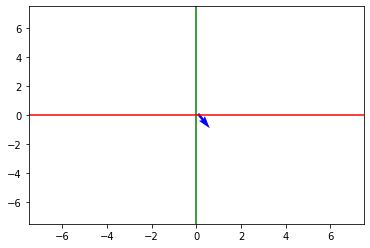

Go Forward pos (0.0883408784866333, 0.07534049451351166) goal 3.6661414675272166 -4.340438219418542ang:
0.8898556630473077
ang robot:
-0.8494744896888733
After:
-0.8494744896888733


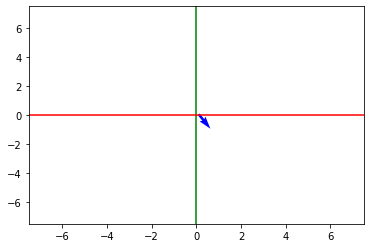

Go Forward pos (0.11726639419794083, 0.04083483666181564) goal 3.6661414675272166 -4.340438219418542ang:
0.8901624892988584
ang robot:
-0.8469637036323547
After:
-0.8469637036323547


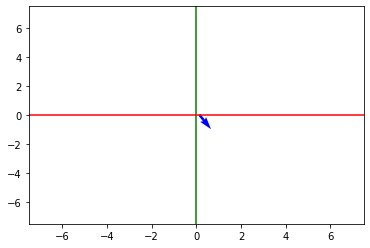

Go Forward pos (0.14906637370586395, 0.004694350995123386) goal 3.6661414675272166 -4.340438219418542ang:
0.8904726602341118
ang robot:
-0.8482173681259155
After:
-0.8482173681259155


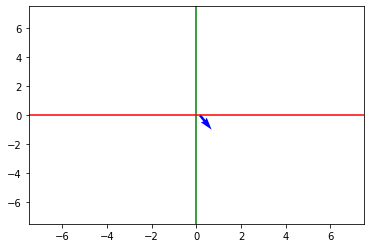

ang:
0.8906100666329018
ang robot:
-0.8482005596160889
After:
-0.8482005596160889


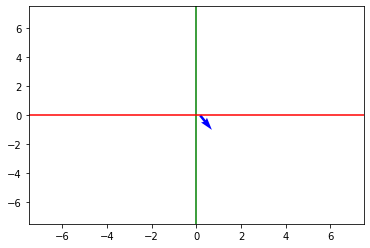

Turn 0.8906100666329018 pos (0.17214584350585938, -0.021368470042943954) goal 3.6661414675272166 -4.340438219418542ang:
0.8904434872956768
ang robot:
-0.8221659660339355
After:
-0.8221659660339355


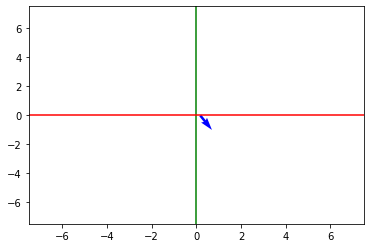

ang:
0.8902842927027792
ang robot:
-0.8014669418334961
After:
-0.8014669418334961


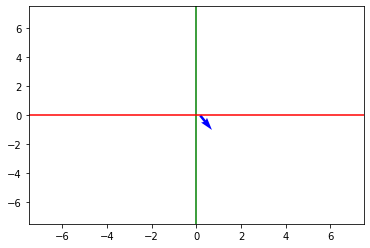

Turn 0.8902842927027792 pos (0.17324738204479218, -0.02800942398607731) goal 3.6661414675272166 -4.340438219418542ang:
0.8896346603153815
ang robot:
-0.7209454774856567
After:
-0.7209454774856567


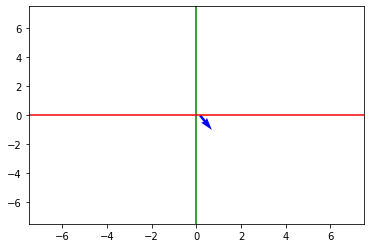

ang:
0.8892757297324805
ang robot:
-0.6698228120803833
After:
-0.6698228120803833


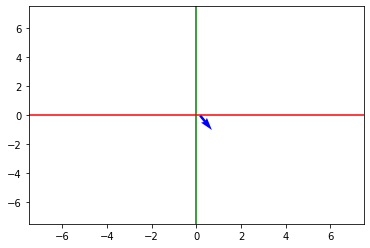

Turn 0.8892757297324805 pos (0.17046639323234558, -0.03244737163186073) goal 3.6661414675272166 -4.340438219418542ang:
0.8888717944660292
ang robot:
-0.6122667193412781
After:
-0.6122667193412781


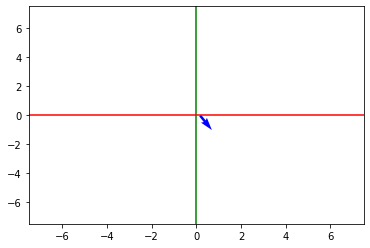

ang:
0.8887158342123033
ang robot:
-0.585863471031189
After:
-0.585863471031189


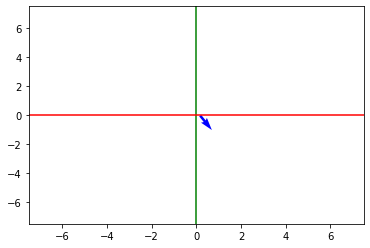

Turn 0.8887158342123033 pos (0.17042727768421173, -0.03787289559841156) goal 3.6661414675272166 -4.340438219418542ang:
0.8881144915168805
ang robot:
-0.4809826612472534
After:
-0.4809826612472534


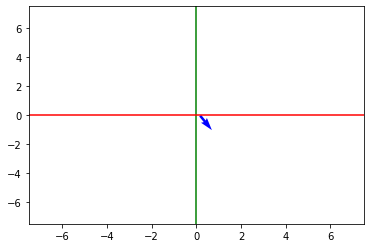

ang:
0.8880218641626502
ang robot:
-0.45815351605415344
After:
-0.45815351605415344


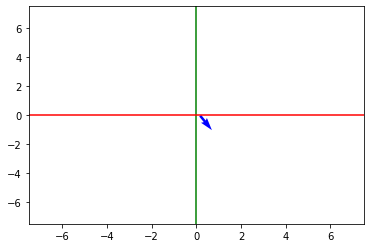

Turn 0.8880218641626502 pos (0.1716628074645996, -0.04373706877231598) goal 3.6661414675272166 -4.340438219418542ang:
0.8876778766008283
ang robot:
-0.37700772285461426
After:
-0.37700772285461426


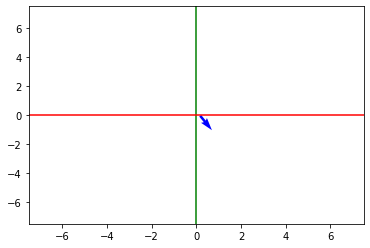

ang:
0.8876289523698826
ang robot:
-0.3551188111305237
After:
-0.3551188111305237


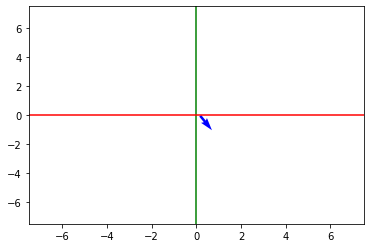

Turn 0.8876289523698826 pos (0.17432329058647156, -0.04979642853140831) goal 3.6661414675272166 -4.340438219418542ang:
0.8873544591703105
ang robot:
-0.2766611576080322
After:
-0.2766611576080322


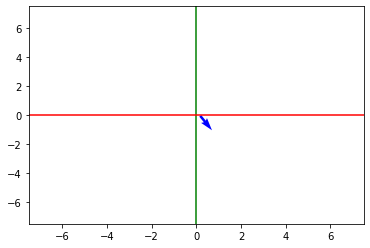

ang:
0.8872694173553826
ang robot:
-0.253230482339859
After:
-0.253230482339859


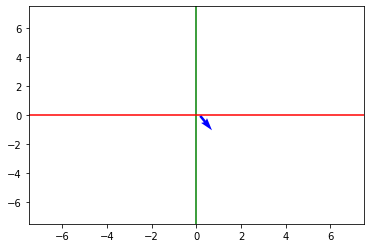

Turn 0.8872694173553826 pos (0.17568528652191162, -0.05499762296676636) goal 3.6661414675272166 -4.340438219418542ang:
0.8869936108267094
ang robot:
-0.1709764152765274
After:
-0.1709764152765274


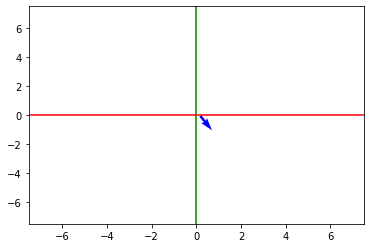

ang:
0.886980017304404
ang robot:
-0.14868593215942383
After:
-0.14868593215942383


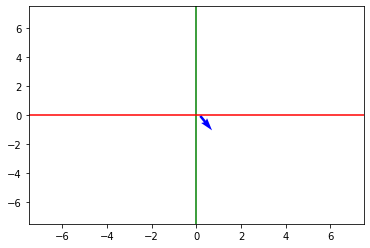

Turn 0.886980017304404 pos (0.1777370125055313, -0.05973292514681816) goal 3.6661414675272166 -4.340438219418542ang:
0.8868901670310229
ang robot:
-0.09481479972600937
After:
-0.09481479972600937


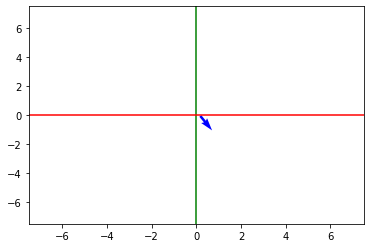

ang:
0.8867594452524782
ang robot:
-0.06452369689941406
After:
-0.06452369689941406


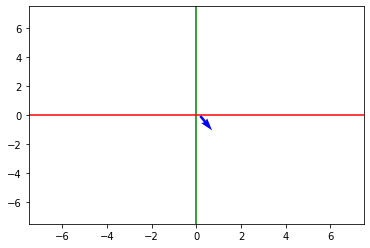

Turn 0.8867594452524782 pos (0.17857877910137177, -0.06308706104755402) goal 3.6661414675272166 -4.340438219418542ang:
0.8864933523920685
ang robot:
0.00041696205153129995
After:
0.00041696205153129995


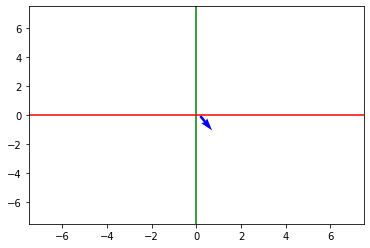

ang:
0.8864940851342776
ang robot:
0.02383945696055889
After:
0.02383945696055889


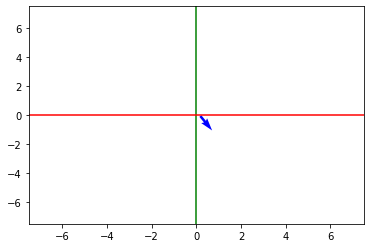

Turn 0.8864940851342776 pos (0.18142399191856384, -0.06767608970403671) goal 3.6661414675272166 -4.340438219418542ang:
0.8864436484088885
ang robot:
0.10468832403421402
After:
0.10468832403421402


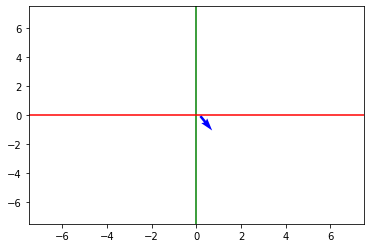

ang:
0.8864615531069436
ang robot:
0.12936967611312866
After:
0.12936967611312866


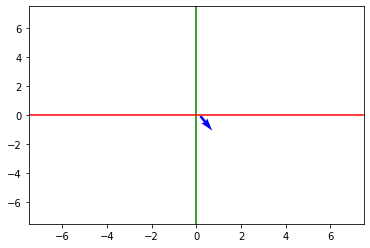

Turn 0.8864615531069436 pos (0.18490172922611237, -0.07210703939199448) goal 3.6661414675272166 -4.340438219418542ang:
0.8865039418835213
ang robot:
0.21523135900497437
After:
0.21523135900497437


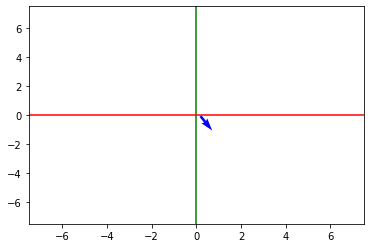

ang:
0.8865930281622478
ang robot:
0.24352137744426727
After:
0.24352137744426727


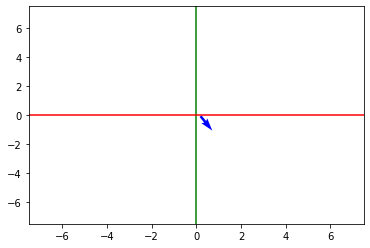

Turn 0.8865930281622478 pos (0.18983367085456848, -0.0768468827009201) goal 3.6661414675272166 -4.340438219418542ang:
0.8870349721142026
ang robot:
0.35226646065711975
After:
0.35226646065711975


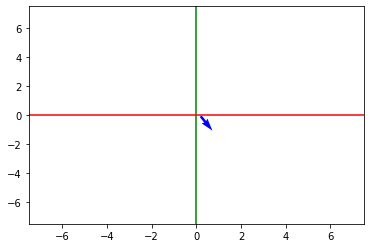

ang:
0.8871998503822737
ang robot:
0.3759205639362335
After:
0.3759205639362335


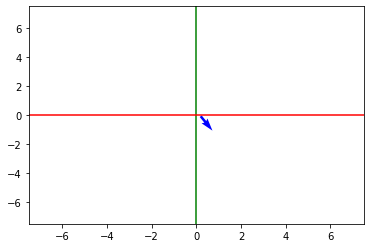

Turn 0.8871998503822737 pos (0.19646872580051422, -0.07961442321538925) goal 3.6661414675272166 -4.340438219418542ang:
0.8875302207841721
ang robot:
0.43338966369628906
After:
0.43338966369628906


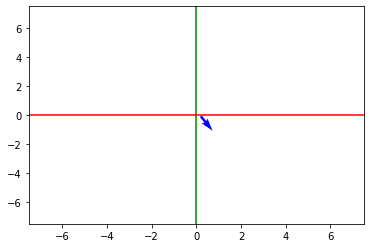

ang:
0.8877860862375138
ang robot:
0.48152461647987366
After:
0.48152461647987366


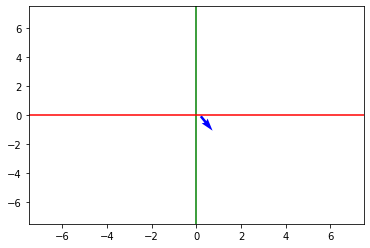

Turn 0.8877860862375138 pos (0.20234782993793488, -0.08190616965293884) goal 3.6661414675272166 -4.340438219418542ang:
0.8883347186865982
ang robot:
0.5646179914474487
After:
0.5646179914474487


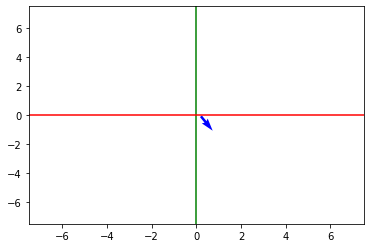

ang:
0.8884514972218673
ang robot:
0.5883495211601257
After:
0.5883495211601257


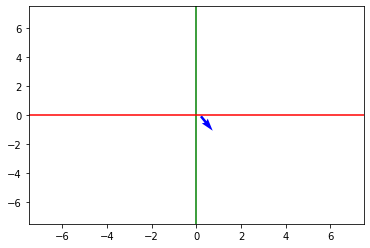

Turn 0.8884514972218673 pos (0.20831291377544403, -0.08388125151395798) goal 3.6661414675272166 -4.340438219418542ang:
0.8888539185145103
ang robot:
0.67035973072052
After:
0.67035973072052


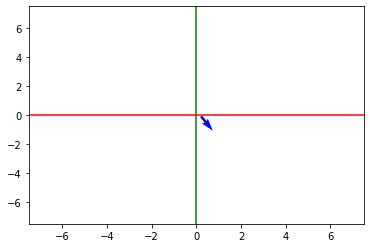

ang:
0.889040182815344
ang robot:
0.6923173069953918
After:
0.6923173069953918


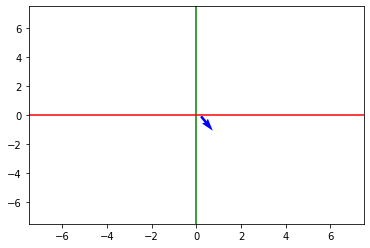

Turn 0.889040182815344 pos (0.21461264789104462, -0.0848524197936058) goal 3.6661414675272166 -4.340438219418542ang:
0.8895515247807795
ang robot:
0.7706282734870911
After:
0.7706282734870911


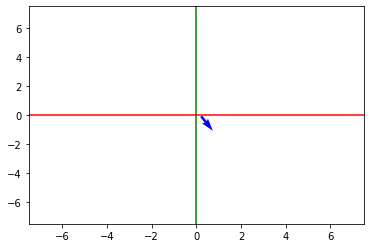

Go Forward pos (0.21973559260368347, -0.08683905005455017) goal 3.6661414675272166 -4.340438219418542ang:
0.8937951731356621
ang robot:
0.8630416393280029
After:
0.8630416393280029


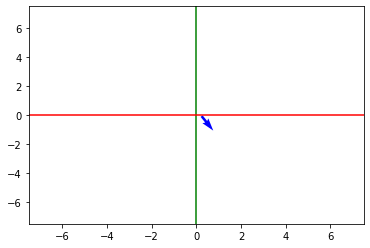

Go Forward pos (0.2406652718782425, -0.0655335932970047) goal 3.6661414675272166 -4.340438219418542ang:
0.9020290207887803
ang robot:
0.8508765697479248
After:
0.8508765697479248


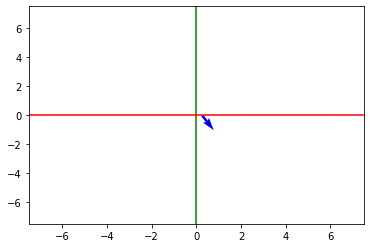

Go Forward pos (0.27690553665161133, -0.02323025092482567) goal 3.6661414675272166 -4.340438219418542ang:
0.9116852529560021
ang robot:
0.8502198457717896
After:
0.8502198457717896


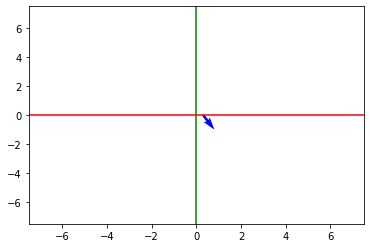

ang:
0.9131335211617246
ang robot:
0.8502961993217468
After:
0.8502961993217468


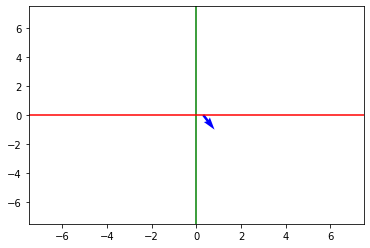

Turn -0.9131335211617246 pos (0.30891451239585876, 0.013246923685073853) goal 3.6661414675272166 -4.340438219418542ang:
0.9140081050616005
ang robot:
0.8071092367172241
After:
0.8071092367172241


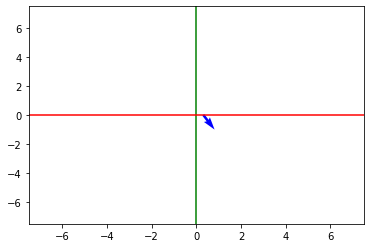

ang:
0.9139756787926113
ang robot:
0.787621259689331
After:
0.787621259689331


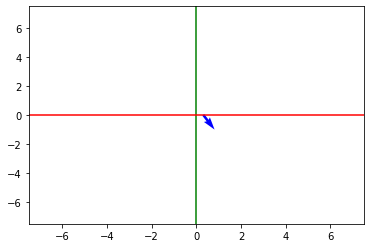

Turn -0.9139756787926113 pos (0.3067034184932709, 0.015777587890625) goal 3.6661414675272166 -4.340438219418542ang:
0.9138540087214964
ang robot:
0.7565547227859497
After:
0.7565547227859497


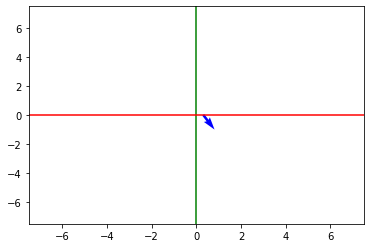

ang:
0.9141328193855495
ang robot:
0.7201346755027771
After:
0.7201346755027771


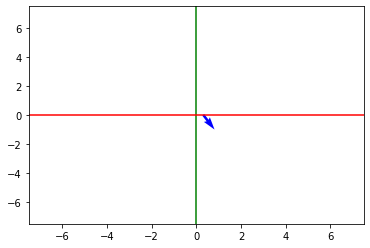

Turn -0.9141328193855495 pos (0.30621472001075745, 0.01926058903336525) goal 3.6661414675272166 -4.340438219418542ang:
0.9145444819157622
ang robot:
0.6479021310806274
After:
0.6479021310806274


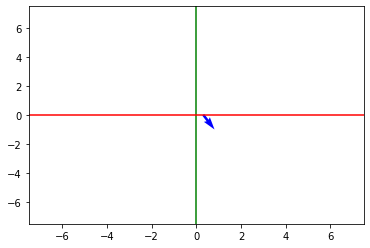

ang:
0.9146686802526828
ang robot:
0.6238555312156677
After:
0.6238555312156677


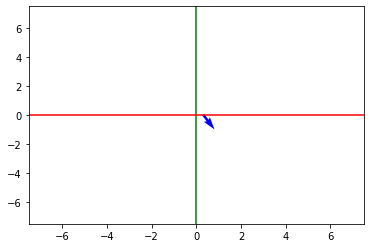

Turn -0.9146686802526828 pos (0.30586451292037964, 0.02466152049601078) goal 3.6661414675272166 -4.340438219418542ang:
0.9150183968208097
ang robot:
0.5394739508628845
After:
0.5394739508628845


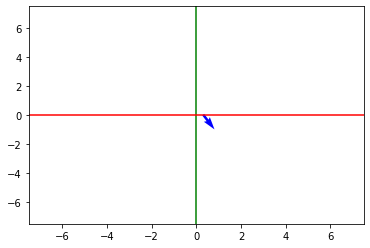

ang:
0.915300699363348
ang robot:
0.4999845027923584
After:
0.4999845027923584


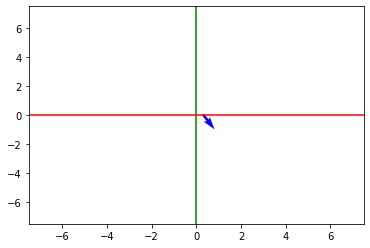

Turn -0.915300699363348 pos (0.30590564012527466, 0.030731284990906715) goal 3.6661414675272166 -4.340438219418542ang:
0.9156218435190859
ang robot:
0.42942577600479126
After:
0.42942577600479126


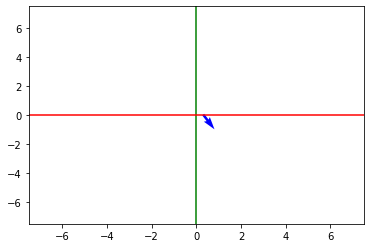

ang:
0.91598260068237
ang robot:
0.3901638686656952
After:
0.3901638686656952


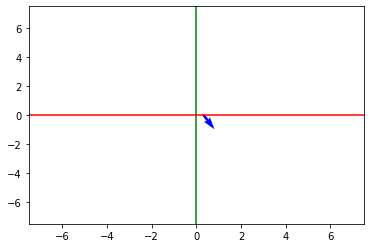

Turn -0.91598260068237 pos (0.3065342307090759, 0.03622337430715561) goal 3.6661414675272166 -4.340438219418542ang:
0.9163226149284607
ang robot:
0.32250621914863586
After:
0.32250621914863586


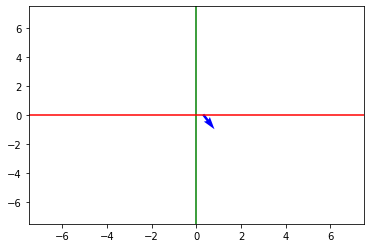

ang:
0.9165426921321346
ang robot:
0.2937626838684082
After:
0.2937626838684082


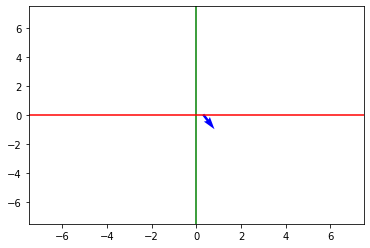

Turn -0.9165426921321346 pos (0.30667948722839355, 0.04154445603489876) goal 3.6661414675272166 -4.340438219418542ang:
0.9174547465067368
ang robot:
0.18274228274822235
After:
0.18274228274822235


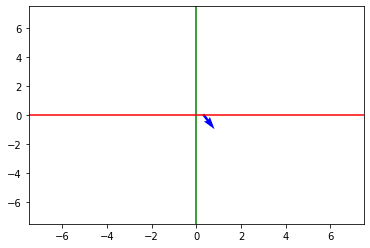

ang:
0.9176587803394208
ang robot:
0.15906023979187012
After:
0.15906023979187012


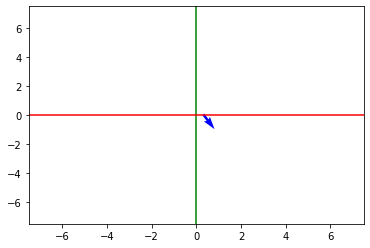

Turn -0.9176587803394208 pos (0.3095562756061554, 0.04785161465406418) goal 3.6661414675272166 -4.340438219418542ang:
0.9182327015955952
ang robot:
0.09986723959445953
After:
0.09986723959445953


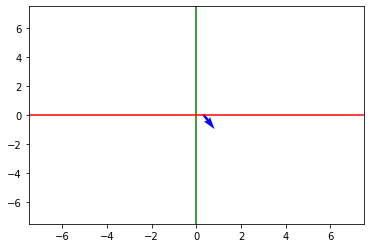

ang:
0.9186679672837675
ang robot:
0.048769593238830566
After:
0.048769593238830566


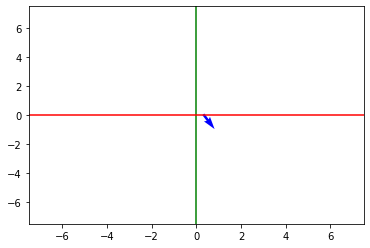

Turn -0.9186679672837675 pos (0.3131946325302124, 0.053229719400405884) goal 3.6661414675272166 -4.340438219418542ang:
0.9193045652348115
ang robot:
-0.027013108134269714
After:
-0.027013108134269714


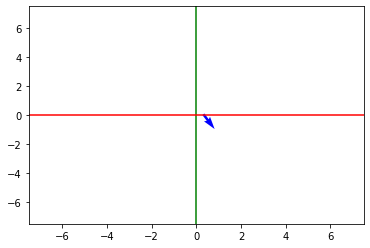

ang:
0.9198755872180673
ang robot:
-0.07974553853273392
After:
-0.07974553853273392


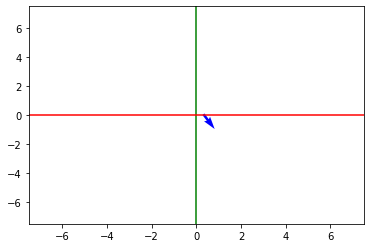

Turn -0.9198755872180673 pos (0.31721362471580505, 0.05863412097096443) goal 3.6661414675272166 -4.340438219418542ang:
0.920739024483826
ang robot:
-0.16455115377902985
After:
-0.16455115377902985


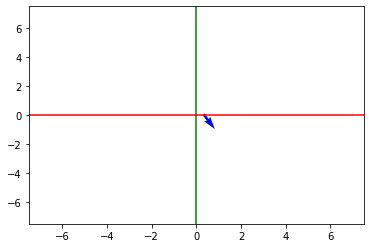

ang:
0.9210185960884028
ang robot:
-0.18803636729717255
After:
-0.18803636729717255


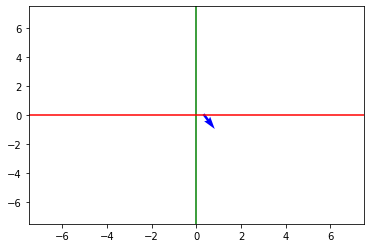

Turn -0.9210185960884028 pos (0.321990966796875, 0.06266103684902191) goal 3.6661414675272166 -4.340438219418542ang:
0.9220396157255045
ang robot:
-0.27746739983558655
After:
-0.27746739983558655


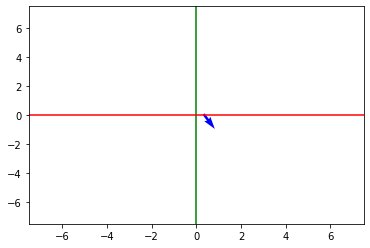

ang:
0.9225890368140197
ang robot:
-0.32995229959487915
After:
-0.32995229959487915


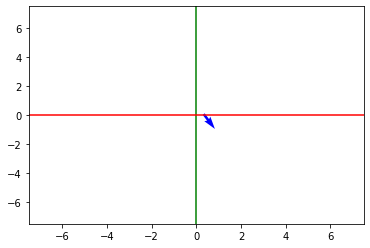

Turn -0.9225890368140197 pos (0.3292293846607208, 0.0671282485127449) goal 3.6661414675272166 -4.340438219418542ang:
0.9234867501674747
ang robot:
-0.4160754680633545
After:
-0.4160754680633545


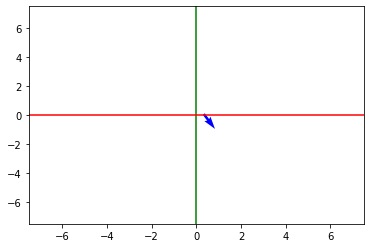

ang:
0.9240501164420987
ang robot:
-0.4673520028591156
After:
-0.4673520028591156


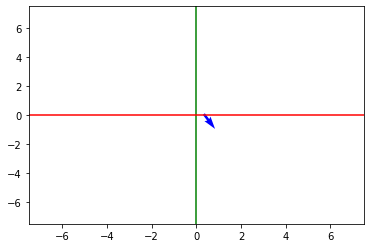

Turn -0.9240501164420987 pos (0.3369311988353729, 0.07035171985626221) goal 3.6661414675272166 -4.340438219418542ang:
0.9249712808777626
ang robot:
-0.5538071393966675
After:
-0.5538071393966675


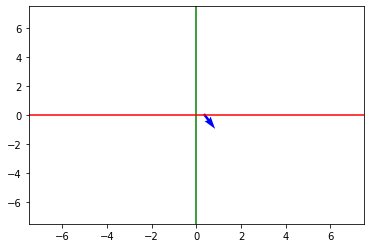

ang:
0.9254515185740977
ang robot:
-0.6044056415557861
After:
-0.6044056415557861


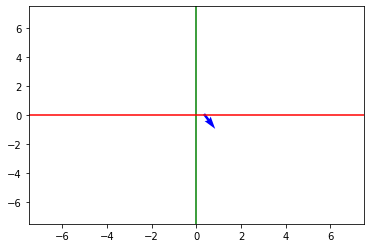

Turn -0.9254515185740977 pos (0.34440523386001587, 0.07288376986980438) goal 3.6661414675272166 -4.340438219418542ang:
0.9259234901102846
ang robot:
-0.6569238305091858
After:
-0.6569238305091858


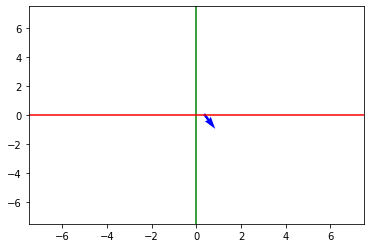

ang:
0.9263712788020375
ang robot:
-0.7065956592559814
After:
-0.7065956592559814


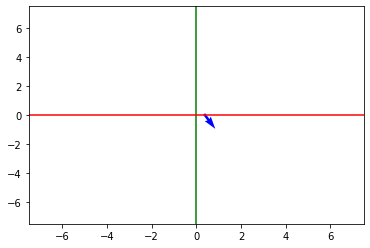

Turn -0.9263712788020375 pos (0.349354088306427, 0.07480888068675995) goal 3.6661414675272166 -4.340438219418542ang:
0.9269420199724177
ang robot:
-0.7682564854621887
After:
-0.7682564854621887


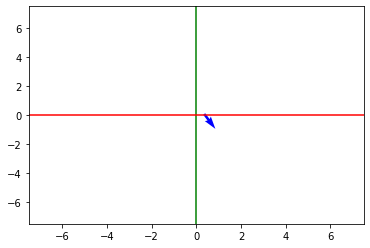

ang:
0.9272373203738787
ang robot:
-0.8033750653266907
After:
-0.8033750653266907


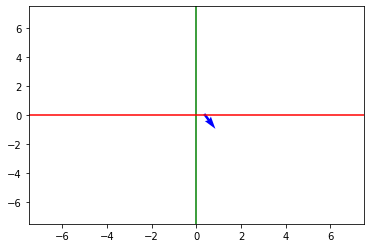

Turn -0.9272373203738787 pos (0.353895366191864, 0.07570623606443405) goal 3.6661414675272166 -4.340438219418542ang:
0.9277875828508241
ang robot:
-0.8708517551422119
After:
-0.8708517551422119


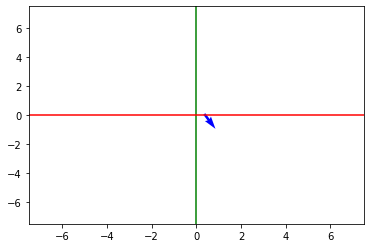

Go Forward pos (0.3588429093360901, 0.07690278440713882) goal 3.6661414675272166 -4.340438219418542ang:
0.9283152424133484
ang robot:
-0.9344915151596069
After:
-0.9344915151596069


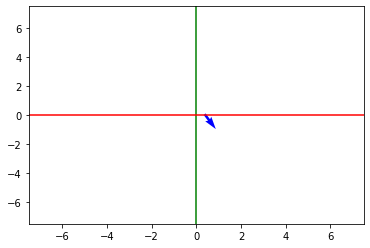

Go Forward pos (0.37928545475006104, 0.0510396733880043) goal 3.6661414675272166 -4.340438219418542ang:
0.9281964848329409
ang robot:
-0.9134095907211304
After:
-0.9134095907211304


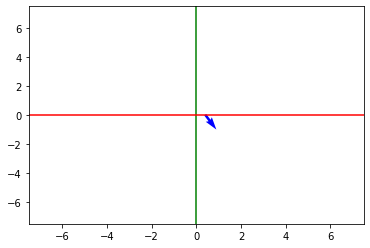

Go Forward pos (0.4075532853603363, 0.01292794942855835) goal 3.6661414675272166 -4.340438219418542ang:
0.9283345902838516
ang robot:
-0.9113967418670654
After:
-0.9113967418670654


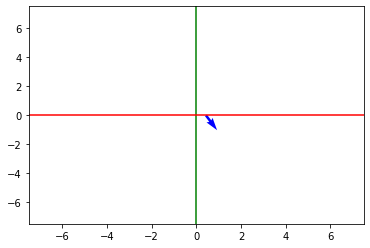

ang:
0.9283901058428526
ang robot:
-0.9113178253173828
After:
-0.9113178253173828


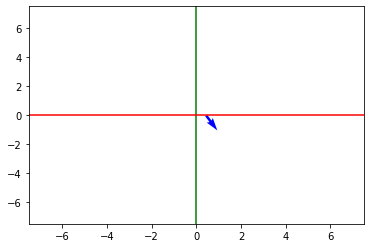

Turn 0.9283901058428526 pos (0.44288620352745056, -0.03282756730914116) goal 3.6661414675272166 -4.340438219418542ang:
0.9280472545265179
ang robot:
-0.8674452900886536
After:
-0.8674452900886536


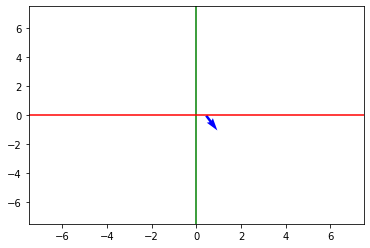

ang:
0.9278811130309335
ang robot:
-0.8474202752113342
After:
-0.8474202752113342


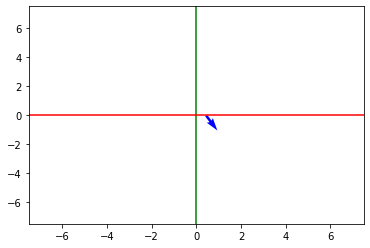

Turn 0.9278811130309335 pos (0.4406209886074066, -0.03549402207136154) goal 3.6661414675272166 -4.340438219418542ang:
0.9271966939627789
ang robot:
-0.7614160180091858
After:
-0.7614160180091858


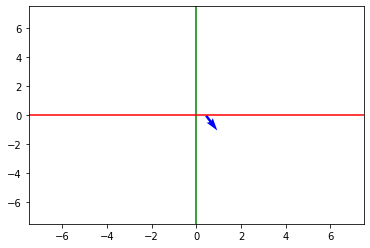

ang:
0.9270093193566156
ang robot:
-0.7346658110618591
After:
-0.7346658110618591


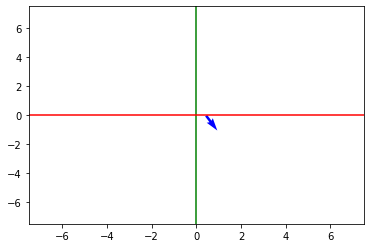

Turn 0.9270093193566156 pos (0.4381312429904938, -0.04166760668158531) goal 3.6661414675272166 -4.340438219418542ang:
0.9263657412809401
ang robot:
-0.6435426473617554
After:
-0.6435426473617554


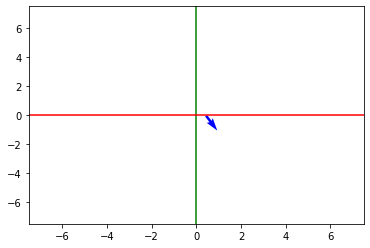

ang:
0.9261914406719013
ang robot:
-0.6156613826751709
After:
-0.6156613826751709


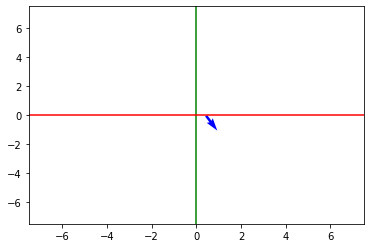

Turn 0.9261914406719013 pos (0.43779078125953674, -0.04764330014586449) goal 3.6661414675272166 -4.340438219418542ang:
0.9257453070120882
ang robot:
-0.5394833087921143
After:
-0.5394833087921143


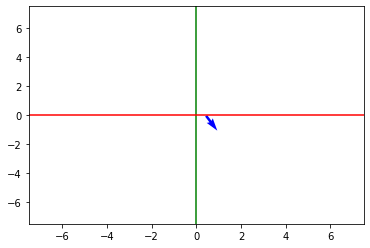

ang:
0.9255216918310037
ang robot:
-0.488972008228302
After:
-0.488972008228302


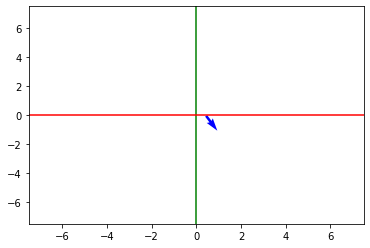

Turn 0.9255216918310037 pos (0.43913063406944275, -0.05372422933578491) goal 3.6661414675272166 -4.340438219418542ang:
0.9251520025880382
ang robot:
-0.4033486247062683
After:
-0.4033486247062683


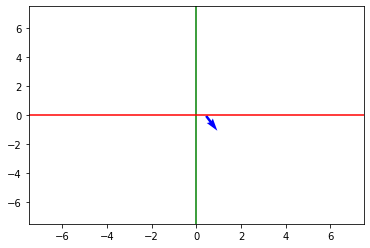

ang:
0.9250745313161123
ang robot:
-0.3795252740383148
After:
-0.3795252740383148


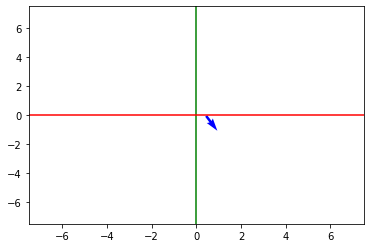

Turn 0.9250745313161123 pos (0.44120708107948303, -0.06007542461156845) goal 3.6661414675272166 -4.340438219418542ang:
0.9250090277216031
ang robot:
-0.34490296244621277
After:
-0.34490296244621277


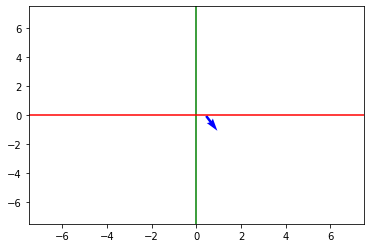

ang:
0.9248814761552245
ang robot:
-0.32496821880340576
After:
-0.32496821880340576


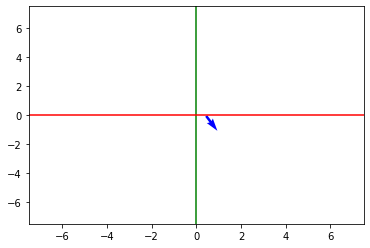

Turn 0.9248814761552245 pos (0.44063764810562134, -0.06251784414052963) goal 3.6661414675272166 -4.340438219418542ang:
0.9244201905834151
ang robot:
-0.25665462017059326
After:
-0.25665462017059326


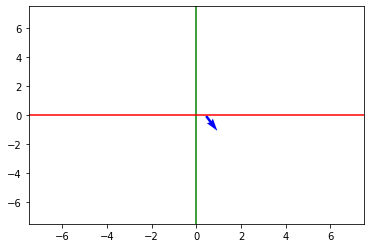

ang:
0.9243068994367852
ang robot:
-0.23749804496765137
After:
-0.23749804496765137


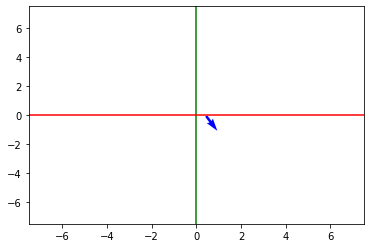

Turn 0.9243068994367852 pos (0.4399169981479645, -0.06594184786081314) goal 3.6661414675272166 -4.340438219418542ang:
0.9238665396529443
ang robot:
-0.1366356909275055
After:
-0.1366356909275055


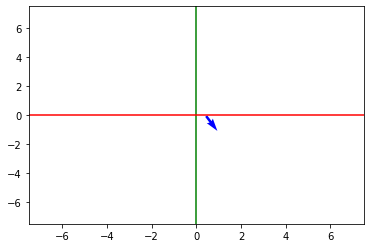

ang:
0.9238789553085103
ang robot:
-0.11353493481874466
After:
-0.11353493481874466


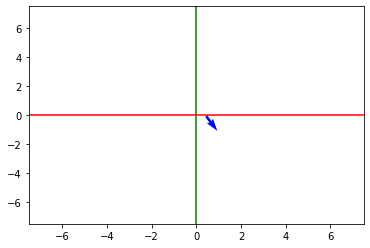

Turn 0.9238789553085103 pos (0.4433327317237854, -0.07228238880634308) goal 3.6661414675272166 -4.340438219418542ang:
0.9237828597502957
ang robot:
-0.033269189298152924
After:
-0.033269189298152924


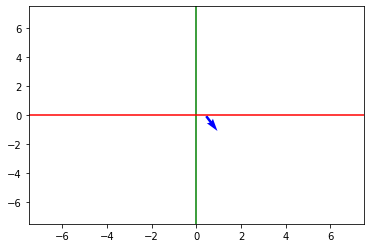

ang:
0.923823257303667
ang robot:
-0.01134976465255022
After:
-0.01134976465255022


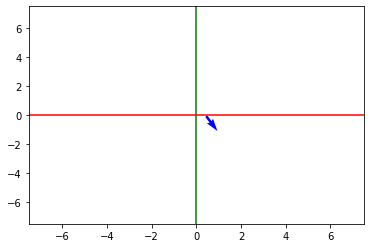

Turn 0.923823257303667 pos (0.4464879035949707, -0.07681018859148026) goal 3.6661414675272166 -4.340438219418542ang:
0.9238042675746331
ang robot:
0.06749504804611206
After:
0.06749504804611206


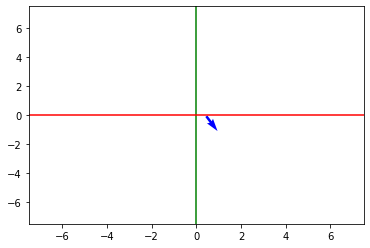

ang:
0.9238442227703886
ang robot:
0.09178411215543747
After:
0.09178411215543747


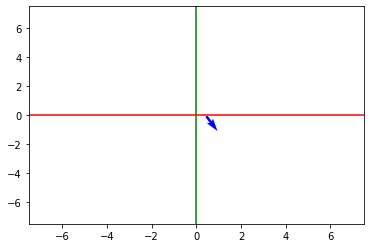

Turn 0.9238442227703886 pos (0.4491955637931824, -0.08107626438140869) goal 3.6661414675272166 -4.340438219418542ang:
0.923884977464211
ang robot:
0.17498359084129333
After:
0.17498359084129333


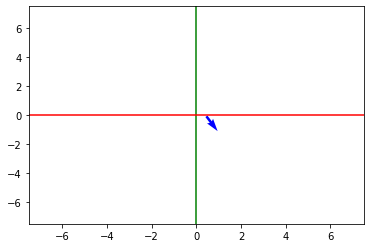

ang:
0.9239848880228958
ang robot:
0.19931922852993011
After:
0.19931922852993011


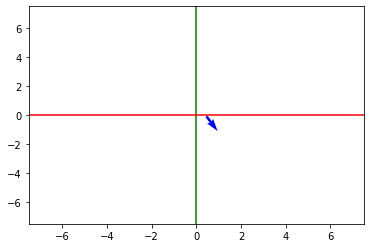

Turn 0.9239848880228958 pos (0.45359230041503906, -0.08517856150865555) goal 3.6661414675272166 -4.340438219418542ang:
0.9242008270007632
ang robot:
0.2571903169155121
After:
0.2571903169155121


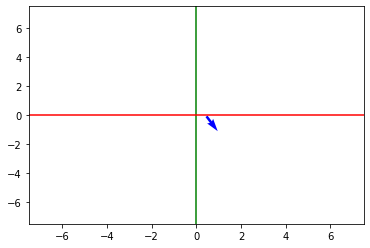

ang:
0.9241940617000501
ang robot:
0.2762334644794464
After:
0.2762334644794464


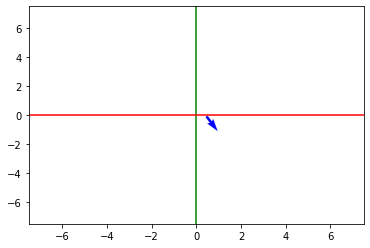

Turn 0.9241940617000501 pos (0.45617422461509705, -0.08782444894313812) goal 3.6661414675272166 -4.340438219418542ang:
0.9241347885001421
ang robot:
0.3481241464614868
After:
0.3481241464614868


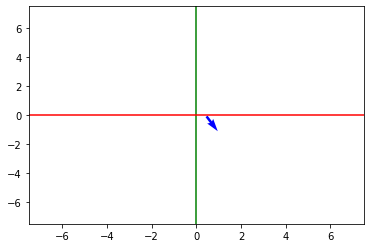

ang:
0.9242859030792978
ang robot:
0.4010392129421234
After:
0.4010392129421234


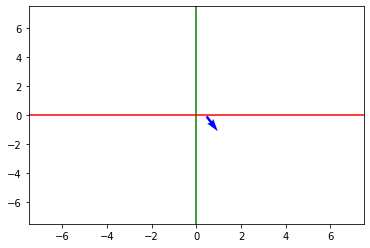

Turn 0.9242859030792978 pos (0.4615555703639984, -0.09215356409549713) goal 3.6661414675272166 -4.340438219418542ang:
0.9245264133808132
ang robot:
0.486506849527359
After:
0.486506849527359


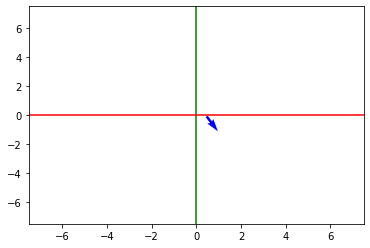

ang:
0.9246539172836035
ang robot:
0.5101500153541565
After:
0.5101500153541565


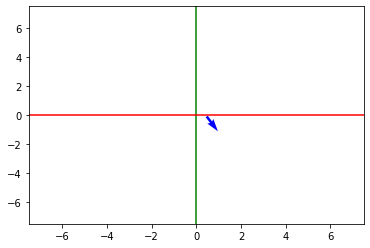

Turn 0.9246539172836035 pos (0.46555113792419434, -0.09513174742460251) goal 3.6661414675272166 -4.340438219418542ang:
0.9251982012429432
ang robot:
0.5953624844551086
After:
0.5953624844551086


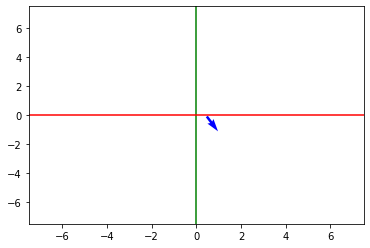

ang:
0.9255365661061911
ang robot:
0.6451217532157898
After:
0.6451217532157898


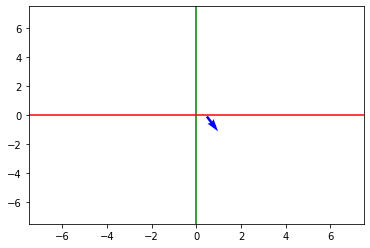

Turn 0.9255365661061911 pos (0.47328948974609375, -0.09707260876893997) goal 3.6661414675272166 -4.340438219418542ang:
0.9261100428883825
ang robot:
0.7053711414337158
After:
0.7053711414337158


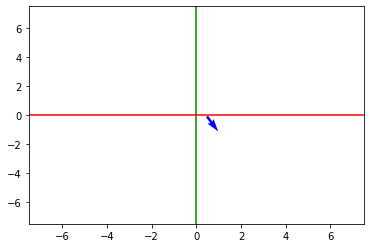

ang:
0.9264831590914401
ang robot:
0.7540875673294067
After:
0.7540875673294067


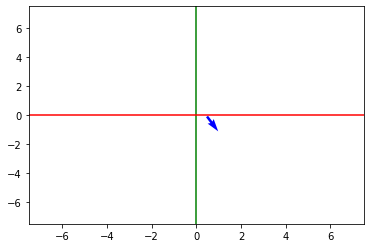

Turn 0.9264831590914401 pos (0.47982674837112427, -0.0977676585316658) goal 3.6661414675272166 -4.340438219418542ang:
0.9270190473029493
ang robot:
0.8336111903190613
After:
0.8336111903190613


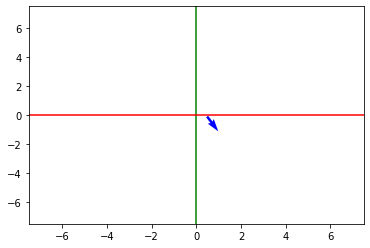

Go Forward pos (0.48437419533729553, -0.09865979105234146) goal 3.6661414675272166 -4.340438219418542ang:
0.9315027158017699
ang robot:
0.8938372731208801
After:
0.8938372731208801


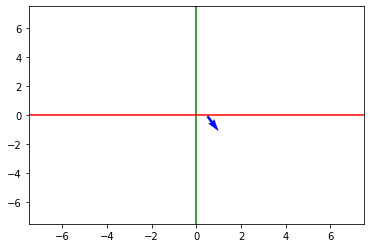

Go Forward pos (0.5053038001060486, -0.07551746070384979) goal 3.6661414675272166 -4.340438219418542ang:
0.9398214540324809
ang robot:
0.8757153749465942
After:
0.8757153749465942


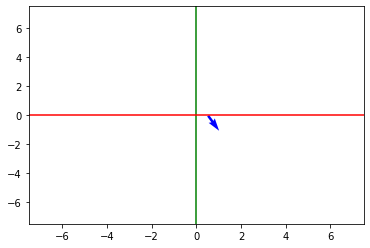

Go Forward pos (0.5348689556121826, -0.03858654946088791) goal 3.6661414675272166 -4.340438219418542ang:
0.94962338781349
ang robot:
0.8759620785713196
After:
0.8759620785713196


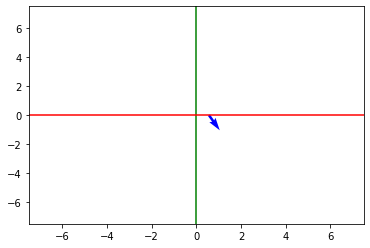

Go Forward pos (0.5683180689811707, 0.0015204503433778882) goal 3.6661414675272166 -4.340438219418542ang:
0.9558603031815891
ang robot:
0.8771041631698608
After:
0.8771041631698608


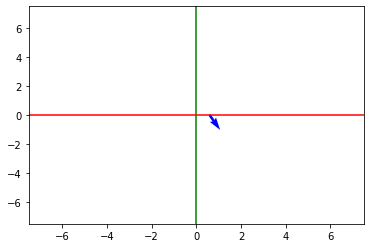

ang:
0.9590883781170053
ang robot:
0.8772756457328796
After:
0.8772756457328796


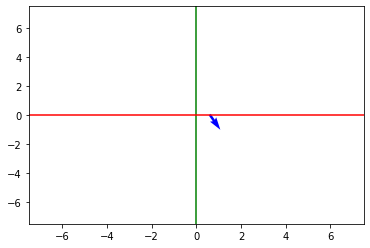

Turn -0.9590883781170053 pos (0.6000111699104309, 0.039460230618715286) goal 3.6661414675272166 -4.340438219418542ang:
0.960000262608928
ang robot:
0.8332101106643677
After:
0.8332101106643677


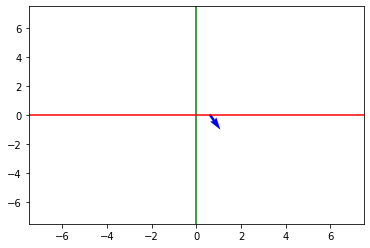

ang:
0.9599728183388094
ang robot:
0.8123782873153687
After:
0.8123782873153687


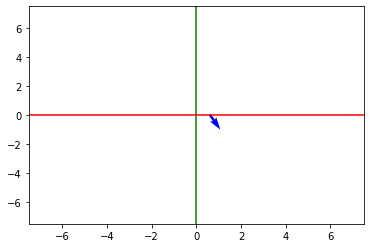

Turn -0.9599728183388094 pos (0.5973044633865356, 0.0417560413479805) goal 3.6661414675272166 -4.340438219418542ang:
0.9600353826434437
ang robot:
0.7325248122215271
After:
0.7325248122215271


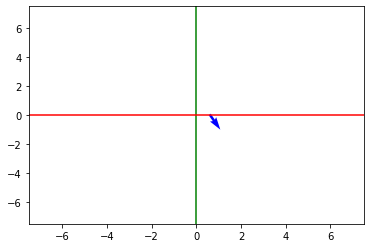

ang:
0.9601037523997742
ang robot:
0.7082394957542419
After:
0.7082394957542419


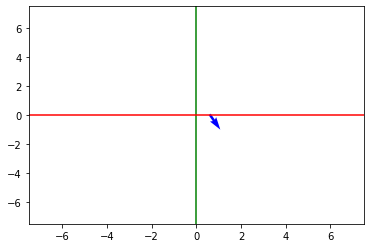

Turn -0.9601037523997742 pos (0.5952509641647339, 0.04661351814866066) goal 3.6661414675272166 -4.340438219418542ang:
0.9602082799842135
ang robot:
0.6485760807991028
After:
0.6485760807991028


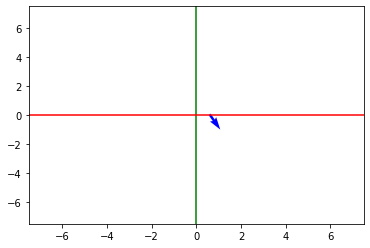

ang:
0.9602620336016952
ang robot:
0.6270688772201538
After:
0.6270688772201538


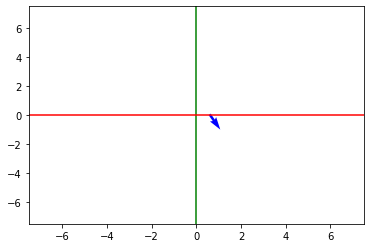

Turn -0.9602620336016952 pos (0.5943348407745361, 0.04993133991956711) goal 3.6661414675272166 -4.340438219418542ang:
0.9603563169649177
ang robot:
0.5733258128166199
After:
0.5733258128166199


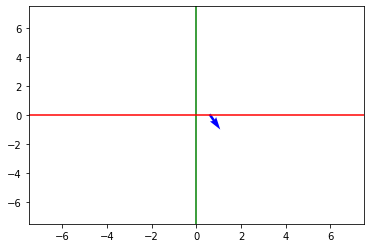

ang:
0.9603901019893283
ang robot:
0.552700400352478
After:
0.552700400352478


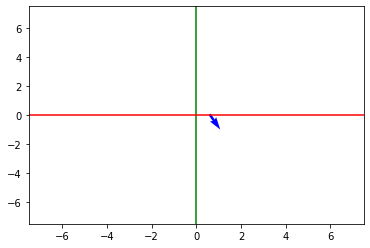

Turn -0.9603901019893283 pos (0.5930235385894775, 0.052933406084775925) goal 3.6661414675272166 -4.340438219418542ang:
0.9605513964746399
ang robot:
0.4771532416343689
After:
0.4771532416343689


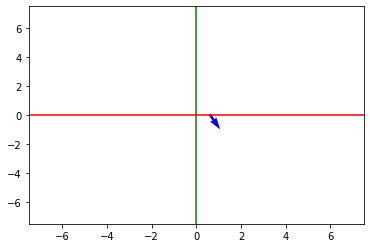

ang:
0.9609095604670278
ang robot:
0.42508038878440857
After:
0.42508038878440857


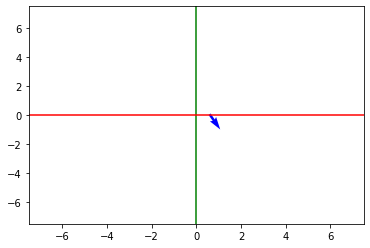

Turn -0.9609095604670278 pos (0.5929251909255981, 0.05934254452586174) goal 3.6661414675272166 -4.340438219418542ang:
0.961284560608335
ang robot:
0.3675164580345154
After:
0.3675164580345154


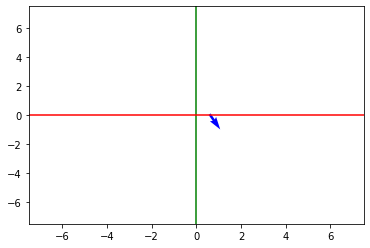

ang:
0.9616164058013542
ang robot:
0.3167145252227783
After:
0.3167145252227783


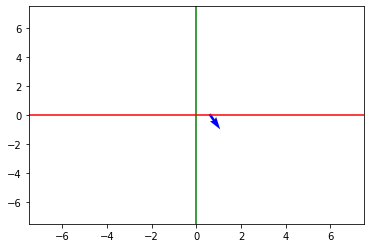

Turn -0.9616164058013542 pos (0.5937896370887756, 0.06477111577987671) goal 3.6661414675272166 -4.340438219418542ang:
0.9620075660135613
ang robot:
0.25937333703041077
After:
0.25937333703041077


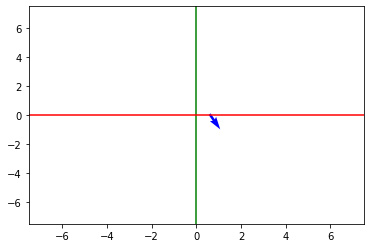

ang:
0.9620727685891736
ang robot:
0.23929008841514587
After:
0.23929008841514587


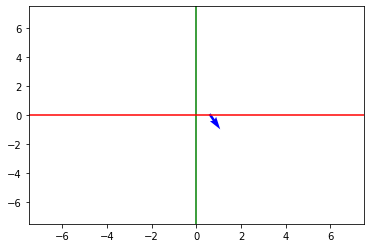

Turn -0.9620727685891736 pos (0.5935806035995483, 0.06812509149312973) goal 3.6661414675272166 -4.340438219418542ang:
0.9623415611526632
ang robot:
0.16511990129947662
After:
0.16511990129947662


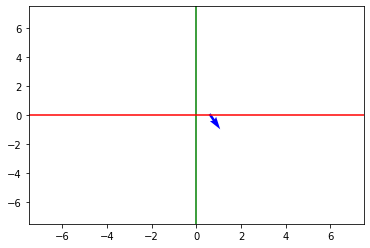

ang:
0.9627645612942899
ang robot:
0.11368599534034729
After:
0.11368599534034729


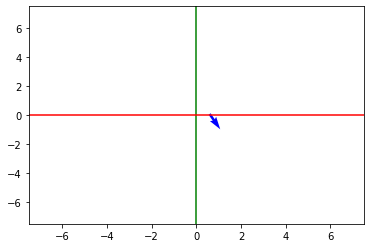

Turn -0.9627645612942899 pos (0.5949270129203796, 0.07404933869838715) goal 3.6661414675272166 -4.340438219418542ang:
0.9636885341858792
ang robot:
0.022090228274464607
After:
0.022090228274464607


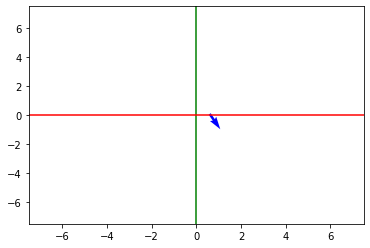

ang:
0.9641553164589816
ang robot:
-0.029796050861477852
After:
-0.029796050861477852


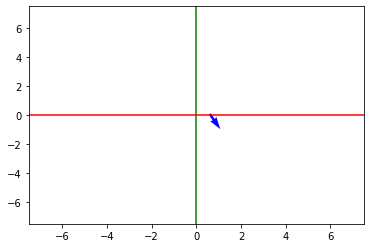

Turn -0.9641553164589816 pos (0.5994178056716919, 0.08056308329105377) goal 3.6661414675272166 -4.340438219418542ang:
0.9650346285523084
ang robot:
-0.11714111268520355
After:
-0.11714111268520355


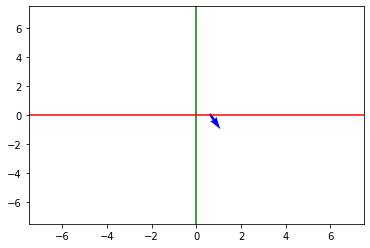

ang:
0.9655299889943132
ang robot:
-0.16843244433403015
After:
-0.16843244433403015


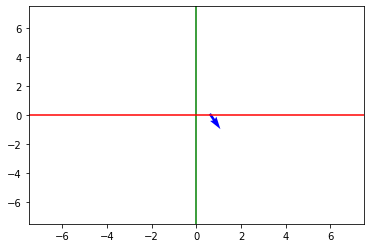

Turn -0.9655299889943132 pos (0.6046010255813599, 0.086212657392025) goal 3.6661414675272166 -4.340438219418542ang:
0.965987131456884
ang robot:
-0.19023463129997253
After:
-0.19023463129997253


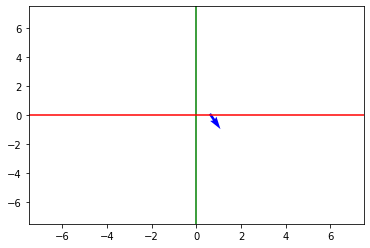

ang:
0.9662463265415056
ang robot:
-0.21733897924423218
After:
-0.21733897924423218


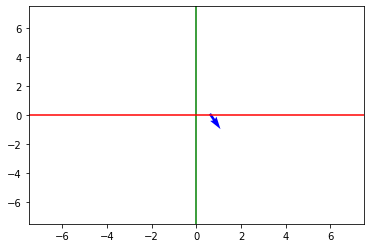

Turn -0.9662463265415056 pos (0.6076456904411316, 0.08738850802183151) goal 3.6661414675272166 -4.340438219418542ang:
0.966747043434785
ang robot:
-0.2836197316646576
After:
-0.2836197316646576


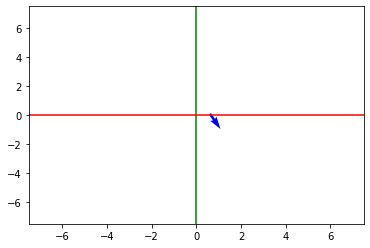

ang:
0.9672198347953797
ang robot:
-0.3248724639415741
After:
-0.3248724639415741


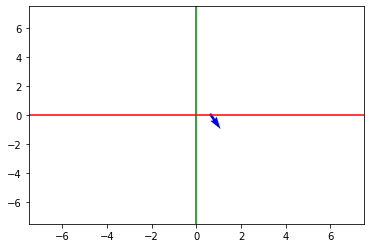

Turn -0.9672198347953797 pos (0.6119012236595154, 0.09117452800273895) goal 3.6661414675272166 -4.340438219418542ang:
0.9678848498807902
ang robot:
-0.39770424365997314
After:
-0.39770424365997314


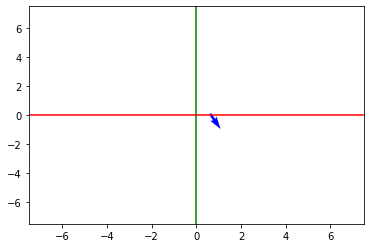

ang:
0.968149179821688
ang robot:
-0.4204949736595154
After:
-0.4204949736595154


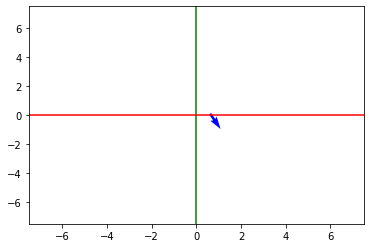

Turn -0.968149179821688 pos (0.6162359118461609, 0.09425902366638184) goal 3.6661414675272166 -4.340438219418542ang:
0.9687134078828948
ang robot:
-0.4744458496570587
After:
-0.4744458496570587


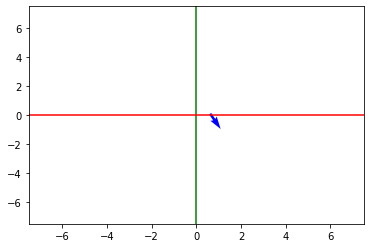

ang:
0.9688612454472424
ang robot:
-0.49404826760292053
After:
-0.49404826760292053


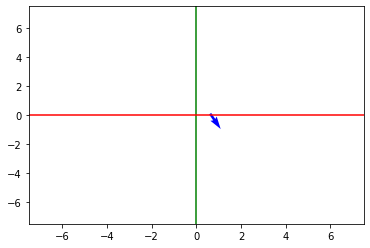

Turn -0.9688612454472424 pos (0.6184712648391724, 0.09661956131458282) goal 3.6661414675272166 -4.340438219418542ang:
0.969457342995756
ang robot:
-0.5697391629219055
After:
-0.5697391629219055


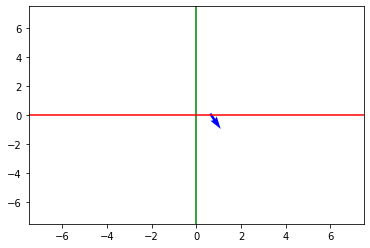

ang:
0.9697519340138928
ang robot:
-0.599308967590332
After:
-0.599308967590332


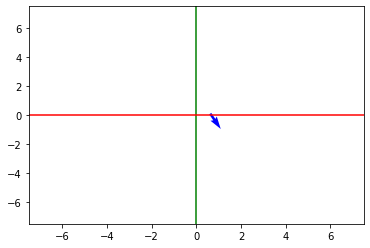

Turn -0.9697519340138928 pos (0.6245745420455933, 0.09982054680585861) goal 3.6661414675272166 -4.340438219418542ang:
0.9708138301198068
ang robot:
-0.6966694593429565
After:
-0.6966694593429565


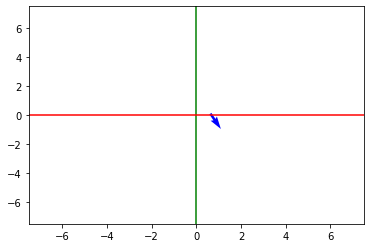

ang:
0.9710722704399074
ang robot:
-0.7251920700073242
After:
-0.7251920700073242


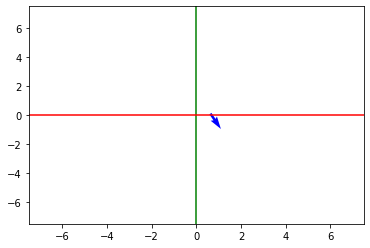

Turn -0.9710722704399074 pos (0.6317982077598572, 0.10084021091461182) goal 3.6661414675272166 -4.340438219418542ang:
0.9720689146152186
ang robot:
-0.8357242345809937
After:
-0.8357242345809937


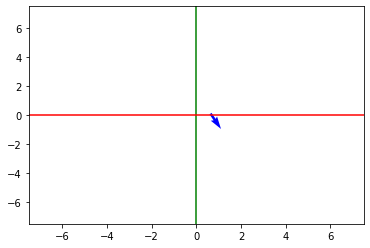

ang:
0.972284290543843
ang robot:
-0.8598610758781433
After:
-0.8598610758781433


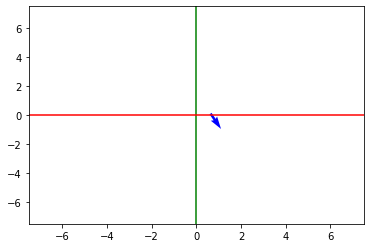

Turn -0.972284290543843 pos (0.6383311152458191, 0.10136661678552628) goal 3.6661414675272166 -4.340438219418542ang:
0.9730121902613924
ang robot:
-0.9442505240440369
After:
-0.9442505240440369


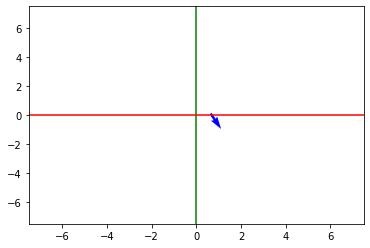

Go Forward pos (0.6422234773635864, 0.10257004201412201) goal 3.6661414675272166 -4.340438219418542ang:
0.9735016039762774
ang robot:
-1.0201307535171509
After:
-1.0201307535171509


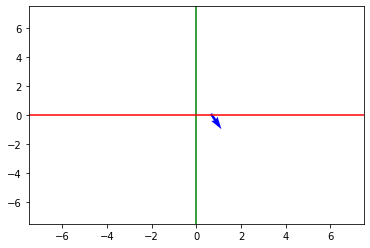

Go Forward pos (0.6617078185081482, 0.07581324875354767) goal 3.6661414675272166 -4.340438219418542ang:
0.9731179024987866
ang robot:
-1.0132414102554321
After:
-1.0132414102554321


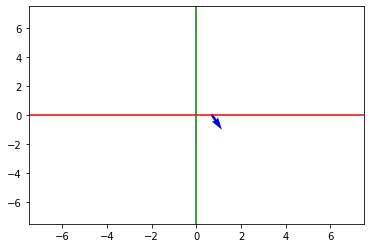

Go Forward pos (0.6807860136032104, 0.04445184767246246) goal 3.6661414675272166 -4.340438219418542ang:
0.9728952840587349
ang robot:
-1.012822151184082
After:
-1.012822151184082


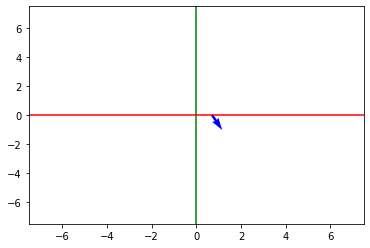

Go Forward pos (0.6963343620300293, 0.019526438787579536) goal 3.6661414675272166 -4.340438219418542ang:
0.9725536751218606
ang robot:
-1.0106302499771118
After:
-1.0106302499771118


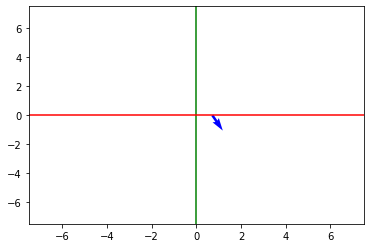

ang:
0.9724927928650752
ang robot:
-1.0105417966842651
After:
-1.0105417966842651


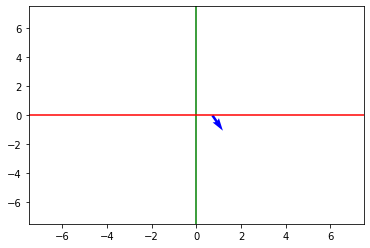

Turn 0.9724927928650752 pos (0.7218979597091675, -0.021472344174981117) goal 3.6661414675272166 -4.340438219418542ang:
0.9720748123933329
ang robot:
-0.9659160375595093
After:
-0.9659160375595093


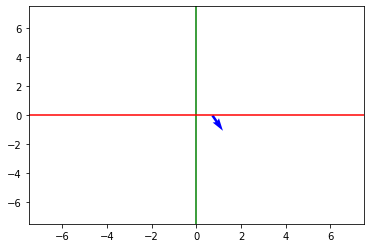

ang:
0.9716608765888761
ang robot:
-0.9168466925621033
After:
-0.9168466925621033


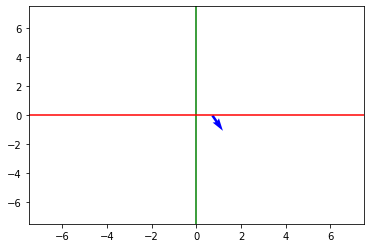

Turn 0.9716608765888761 pos (0.7190709710121155, -0.025920415297150612) goal 3.6661414675272166 -4.340438219418542ang:
0.9711820176940765
ang robot:
-0.85763019323349
After:
-0.85763019323349


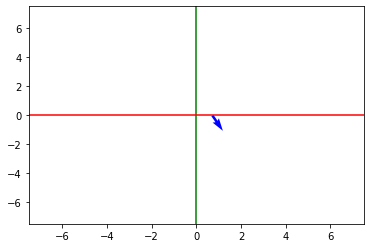

ang:
0.970985054432832
ang robot:
-0.8314130306243896
After:
-0.8314130306243896


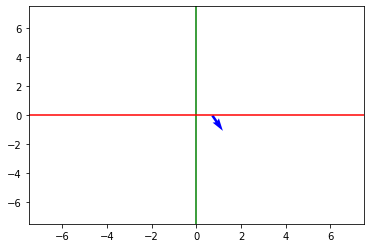

Turn 0.970985054432832 pos (0.717388927936554, -0.030986323952674866) goal 3.6661414675272166 -4.340438219418542ang:
0.9704129571815245
ang robot:
-0.7547942399978638
After:
-0.7547942399978638


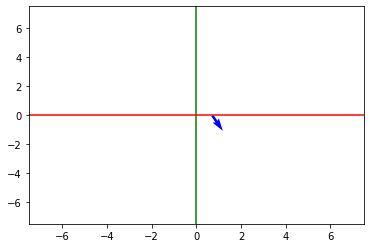

ang:
0.970258220566059
ang robot:
-0.7338158488273621
After:
-0.7338158488273621


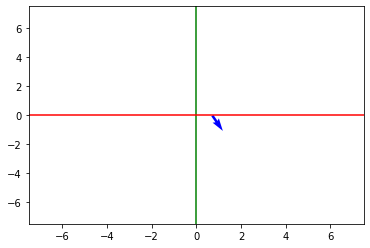

Turn 0.970258220566059 pos (0.7164584994316101, -0.034733738750219345) goal 3.6661414675272166 -4.340438219418542ang:
0.9698846407216074
ang robot:
-0.6832970380783081
After:
-0.6832970380783081


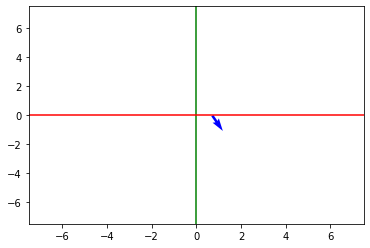

ang:
0.9695852500063981
ang robot:
-0.6342366933822632
After:
-0.6342366933822632


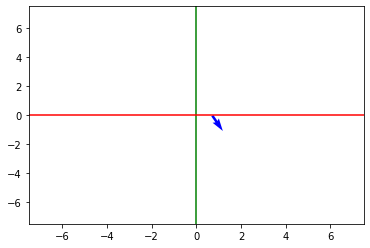

Turn 0.9695852500063981 pos (0.7161087989807129, -0.040007736533880234) goal 3.6661414675272166 -4.340438219418542ang:
0.9692930931792109
ang robot:
-0.5760871767997742
After:
-0.5760871767997742


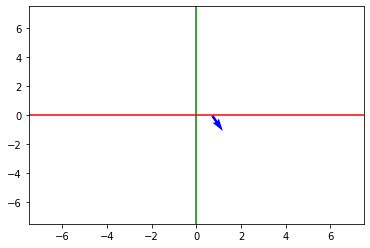

ang:
0.9690153923841565
ang robot:
-0.5219016075134277
After:
-0.5219016075134277


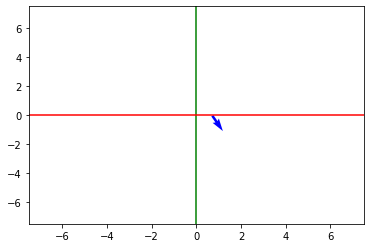

Turn 0.9690153923841565 pos (0.7170141935348511, -0.04661060869693756) goal 3.6661414675272166 -4.340438219418542ang:
0.9687175045797373
ang robot:
-0.4240964651107788
After:
-0.4240964651107788


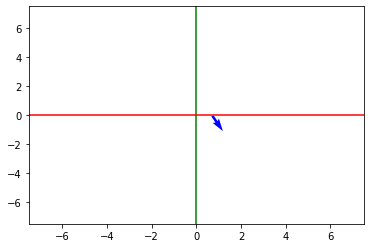

ang:
0.9684830648503562
ang robot:
-0.36885273456573486
After:
-0.36885273456573486


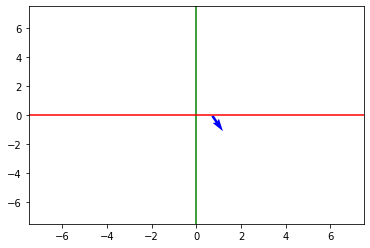

Turn 0.9684830648503562 pos (0.7196829915046692, -0.0553470142185688) goal 3.6661414675272166 -4.340438219418542ang:
0.9683432806958665
ang robot:
-0.3015490174293518
After:
-0.3015490174293518


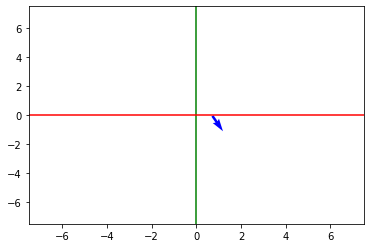

ang:
0.9682769815620794
ang robot:
-0.24902012944221497
After:
-0.24902012944221497


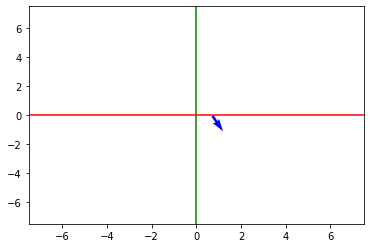

Turn 0.9682769815620794 pos (0.7235860824584961, -0.06202339008450508) goal 3.6661414675272166 -4.340438219418542ang:
0.9683655302711244
ang robot:
-0.15666231513023376
After:
-0.15666231513023376


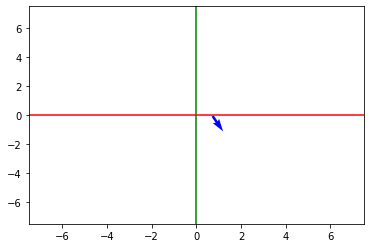

ang:
0.9683466869203019
ang robot:
-0.13127751648426056
After:
-0.13127751648426056


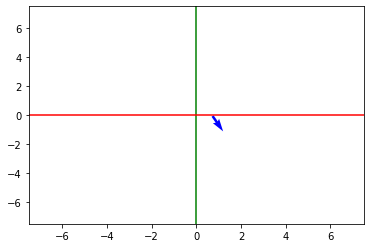

Turn 0.9683466869203019 pos (0.7281794548034668, -0.06824186444282532) goal 3.6661414675272166 -4.340438219418542ang:
0.9683032315960364
ang robot:
-0.07332868874073029
After:
-0.07332868874073029


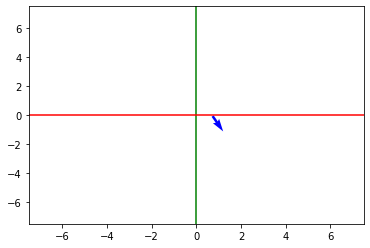

ang:
0.9682658960338287
ang robot:
-0.04761346057057381
After:
-0.04761346057057381


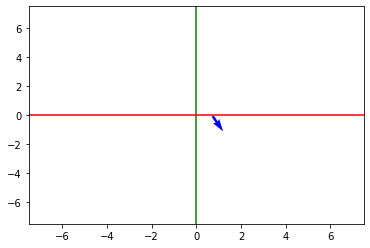

Turn 0.9682658960338287 pos (0.7308982610702515, -0.07307209074497223) goal 3.6661414675272166 -4.340438219418542ang:
0.968236952293074
ang robot:
0.0548052079975605
After:
0.0548052079975605


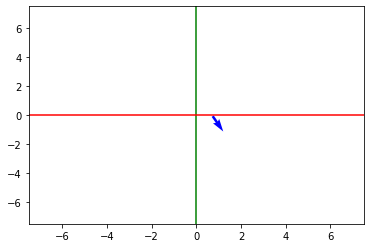

ang:
0.9682956479811173
ang robot:
0.07744648307561874
After:
0.07744648307561874


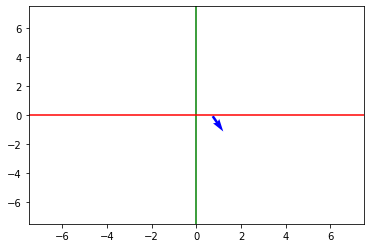

Turn 0.9682956479811173 pos (0.7346686124801636, -0.0774567648768425) goal 3.6661414675272166 -4.340438219418542ang:
0.9686230698625676
ang robot:
0.16349266469478607
After:
0.16349266469478607


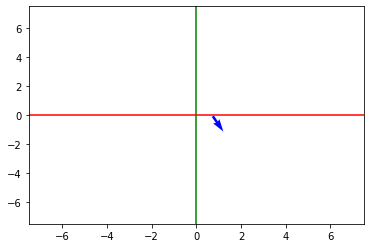

ang:
0.9686918200110642
ang robot:
0.1860024333000183
After:
0.1860024333000183


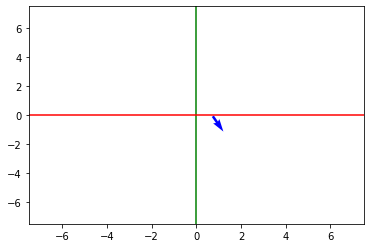

Turn 0.9686918200110642 pos (0.7399412393569946, -0.08152647316455841) goal 3.6661414675272166 -4.340438219418542ang:
0.9689232830534351
ang robot:
0.24108628928661346
After:
0.24108628928661346


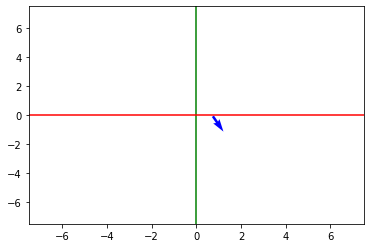

ang:
0.9689145438739606
ang robot:
0.2612345218658447
After:
0.2612345218658447


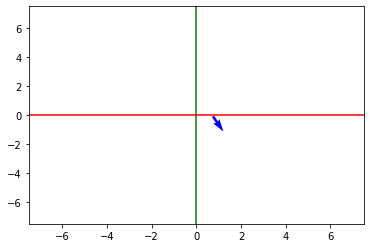

Turn 0.9689145438739606 pos (0.7427140474319458, -0.0842895358800888) goal 3.6661414675272166 -4.340438219418542ang:
0.9688538829850493
ang robot:
0.3093608617782593
After:
0.3093608617782593


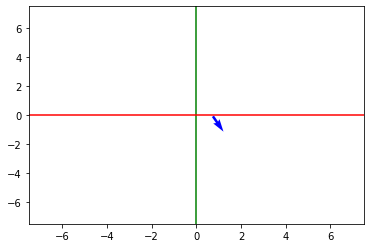

ang:
0.9689307006589704
ang robot:
0.33431825041770935
After:
0.33431825041770935


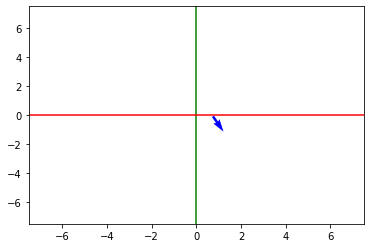

Turn 0.9689307006589704 pos (0.7474249005317688, -0.08734790980815887) goal 3.6661414675272166 -4.340438219418542ang:
0.9693896641744276
ang robot:
0.43786942958831787
After:
0.43786942958831787


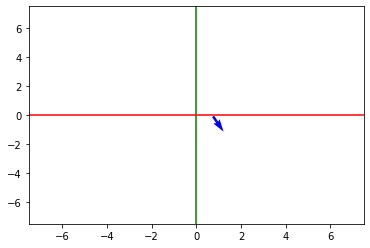

ang:
0.9694831323650636
ang robot:
0.46158257126808167
After:
0.46158257126808167


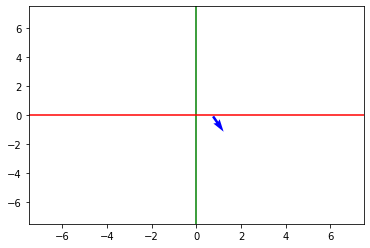

Turn 0.9694831323650636 pos (0.7517656087875366, -0.09041959047317505) goal 3.6661414675272166 -4.340438219418542ang:
0.9697013759794251
ang robot:
0.5168477296829224
After:
0.5168477296829224


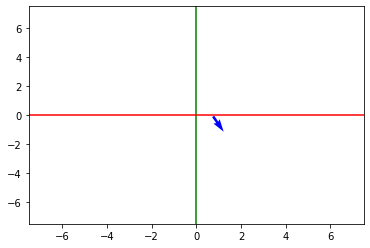

ang:
0.9697989089256607
ang robot:
0.5428901314735413
After:
0.5428901314735413


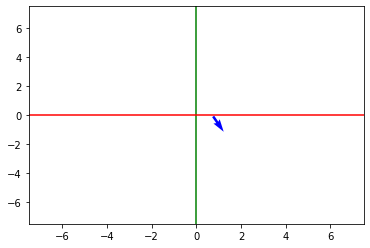

Turn 0.9697989089256607 pos (0.7574894428253174, -0.09235238283872604) goal 3.6661414675272166 -4.340438219418542ang:
0.9706568319024119
ang robot:
0.6506476402282715
After:
0.6506476402282715


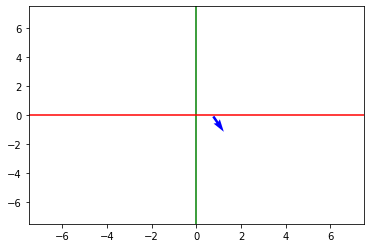

ang:
0.9708670862970507
ang robot:
0.6767030358314514
After:
0.6767030358314514


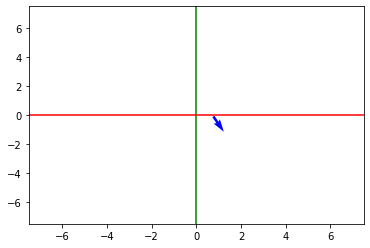

Turn 0.9708670862970507 pos (0.7641991376876831, -0.0941816121339798) goal 3.6661414675272166 -4.340438219418542ang:
0.9719061706446559
ang robot:
0.783631443977356
After:
0.783631443977356


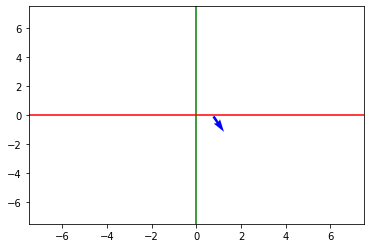

ang:
0.9723264496135604
ang robot:
0.8326648473739624
After:
0.8326648473739624


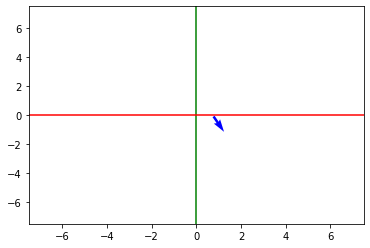

Turn 0.9723264496135604 pos (0.7720432877540588, -0.0947052389383316) goal 3.6661414675272166 -4.340438219418542ang:
0.9727402743053692
ang robot:
0.8857583403587341
After:
0.8857583403587341


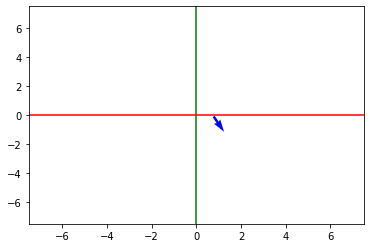

Go Forward pos (0.7752720713615417, -0.09547890722751617) goal 3.6661414675272166 -4.340438219418542ang:
0.9756506563225982
ang robot:
0.9714527130126953
After:
0.9714527130126953


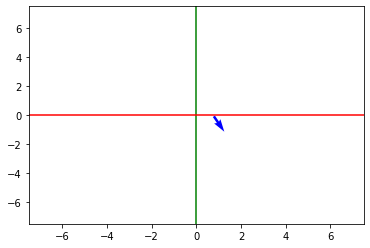

Go Forward pos (0.7951326370239258, -0.07157286256551743) goal 3.6661414675272166 -4.340438219418542ang:
0.9854432067015765
ang robot:
0.9635385870933533
After:
0.9635385870933533


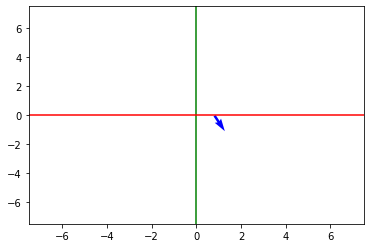

Go Forward pos (0.8205393552780151, -0.033772774040699005) goal 3.6661414675272166 -4.340438219418542ang:
0.9925351936564241
ang robot:
0.9629355072975159
After:
0.9629355072975159


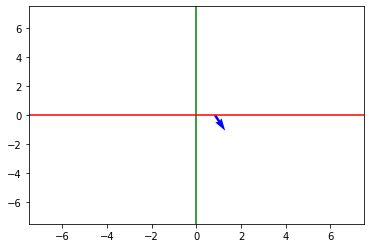

Go Forward pos (0.8430730700492859, -0.0013645309954881668) goal 3.6661414675272166 -4.340438219418542ang:
0.9995910482750783
ang robot:
0.9629762768745422
After:
0.9629762768745422


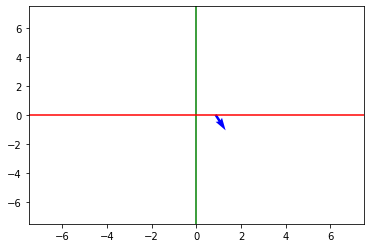

ang:
1.0010324504994073
ang robot:
0.9631689786911011
After:
0.9631689786911011


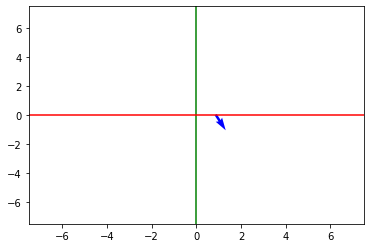

Turn -1.0010324504994073 pos (0.8681161999702454, 0.03463149443268776) goal 3.6661414675272166 -4.340438219418542ang:
1.0018730880483606
ang robot:
0.9192882776260376
After:
0.9192882776260376


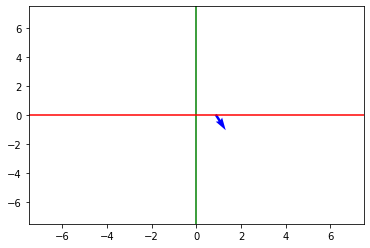

ang:
1.0018807516315287
ang robot:
0.8683810234069824
After:
0.8683810234069824


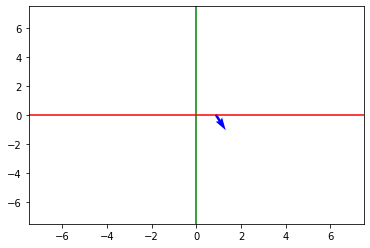

Turn -1.0018807516315287 pos (0.8651828765869141, 0.03904452547430992) goal 3.6661414675272166 -4.340438219418542ang:
1.001765703242526
ang robot:
0.7805458307266235
After:
0.7805458307266235


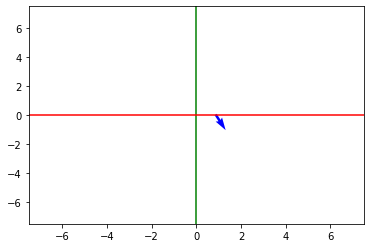

ang:
1.001809698994815
ang robot:
0.7563527822494507
After:
0.7563527822494507


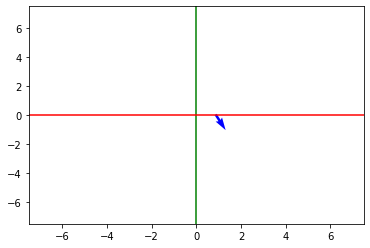

Turn -1.001809698994815 pos (0.8626013994216919, 0.04330772906541824) goal 3.6661414675272166 -4.340438219418542ang:
1.0019148373855638
ang robot:
0.671622097492218
After:
0.671622097492218


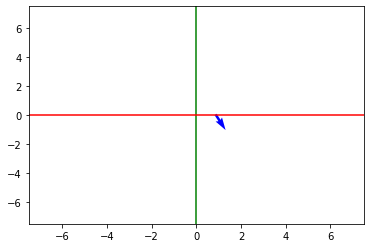

ang:
1.002017703673251
ang robot:
0.6478751301765442
After:
0.6478751301765442


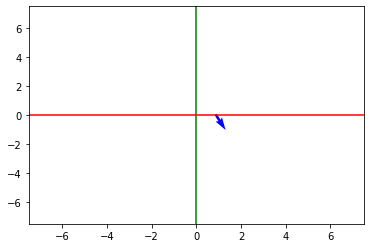

Turn -1.002017703673251 pos (0.8611999750137329, 0.04832269623875618) goal 3.6661414675272166 -4.340438219418542ang:
1.0021849209208262
ang robot:
0.591562032699585
After:
0.591562032699585


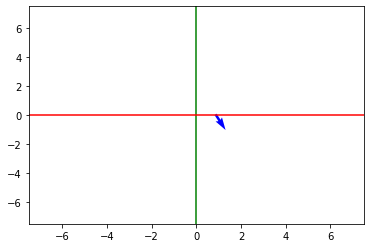

ang:
1.0024693545883943
ang robot:
0.5402695536613464
After:
0.5402695536613464


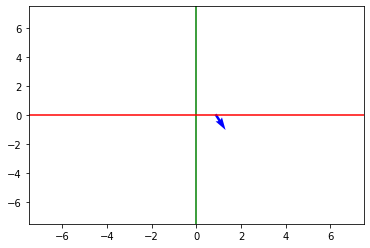

Turn -1.0024693545883943 pos (0.861405074596405, 0.0544348768889904) goal 3.6661414675272166 -4.340438219418542ang:
1.002818985958413
ang robot:
0.4815724194049835
After:
0.4815724194049835


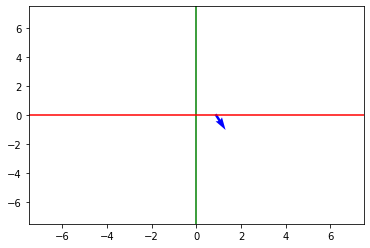

ang:
1.0031063107309166
ang robot:
0.4312810003757477
After:
0.4312810003757477


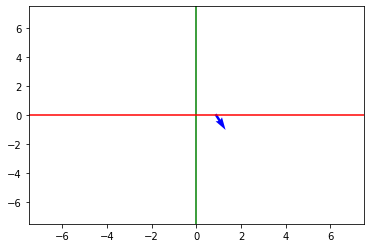

Turn -1.0031063107309166 pos (0.8613364100456238, 0.0594215914607048) goal 3.6661414675272166 -4.340438219418542ang:
1.0038574574007122
ang robot:
0.3420400321483612
After:
0.3420400321483612


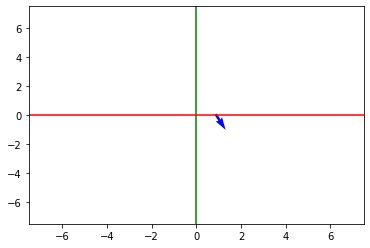

ang:
1.0043670987931939
ang robot:
0.2916901707649231
After:
0.2916901707649231


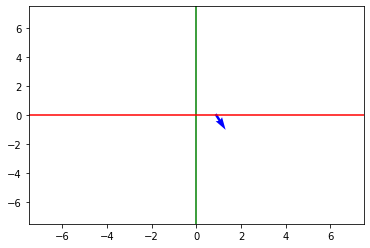

Turn -1.0043670987931939 pos (0.8646259307861328, 0.06715385615825653) goal 3.6661414675272166 -4.340438219418542ang:
1.0052747219493137
ang robot:
0.20335032045841217
After:
0.20335032045841217


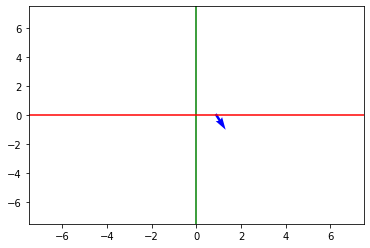

ang:
1.005667482710963
ang robot:
0.14957143366336823
After:
0.14957143366336823


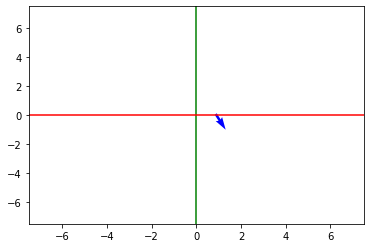

Turn -1.005667482710963 pos (0.867449164390564, 0.07431025058031082) goal 3.6661414675272166 -4.340438219418542ang:
1.0063689351920533
ang robot:
0.059507664293050766
After:
0.059507664293050766


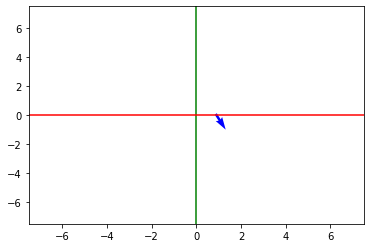

ang:
1.0065521299193805
ang robot:
0.034323934465646744
After:
0.034323934465646744


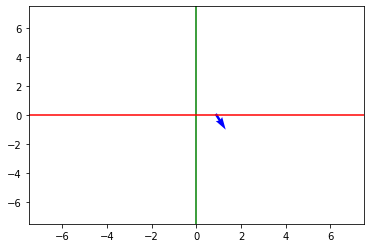

Turn -1.0065521299193805 pos (0.8702114820480347, 0.07990776002407074) goal 3.6661414675272166 -4.340438219418542ang:
1.0069612855965098
ang robot:
-0.024839891120791435
After:
-0.024839891120791435


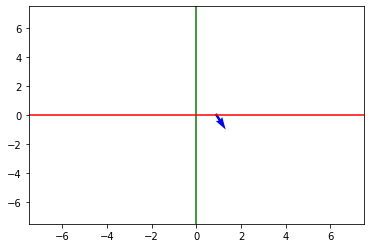

ang:
1.0073871439294064
ang robot:
-0.07469464838504791
After:
-0.07469464838504791


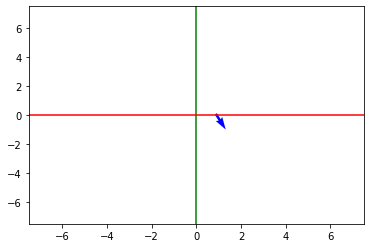

Turn -1.0073871439294064 pos (0.8722366094589233, 0.08428241312503815) goal 3.6661414675272166 -4.340438219418542ang:
1.0080576063950362
ang robot:
-0.15630711615085602
After:
-0.15630711615085602


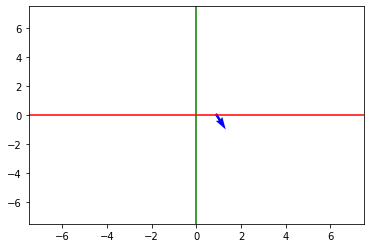

ang:
1.0083050788032832
ang robot:
-0.17983797192573547
After:
-0.17983797192573547


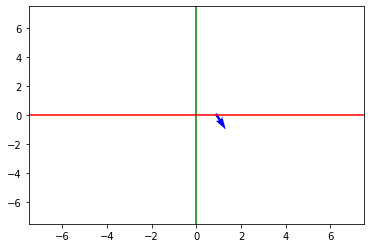

Turn -1.0083050788032832 pos (0.8752604722976685, 0.08850979804992676) goal 3.6661414675272166 -4.340438219418542ang:
1.0088272014481243
ang robot:
-0.23526716232299805
After:
-0.23526716232299805


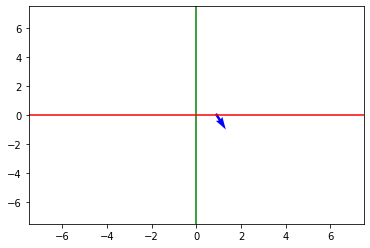

ang:
1.0092754746161197
ang robot:
-0.28520143032073975
After:
-0.28520143032073975


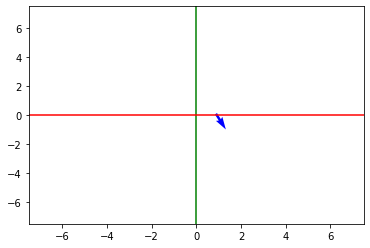

Turn -1.0092754746161197 pos (0.8795787692070007, 0.09250686317682266) goal 3.6661414675272166 -4.340438219418542ang:
1.010054398180845
ang robot:
-0.36988893151283264
After:
-0.36988893151283264


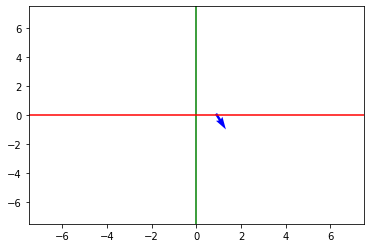

ang:
1.0103240844371943
ang robot:
-0.39385998249053955
After:
-0.39385998249053955


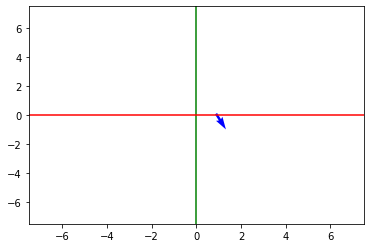

Turn -1.0103240844371943 pos (0.8839435577392578, 0.09588251262903214) goal 3.6661414675272166 -4.340438219418542ang:
1.0111724122907244
ang robot:
-0.47689539194107056
After:
-0.47689539194107056


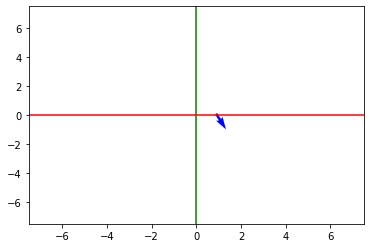

ang:
1.0116205484754384
ang robot:
-0.5129672884941101
After:
-0.5129672884941101


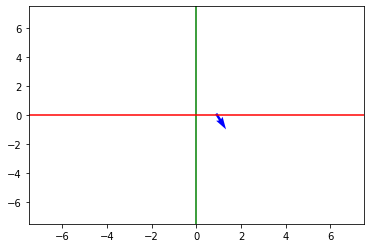

Turn -1.0116205484754384 pos (0.8889970779418945, 0.09835639595985413) goal 3.6661414675272166 -4.340438219418542ang:
1.0122708970714778
ang robot:
-0.5809958577156067
After:
-0.5809958577156067


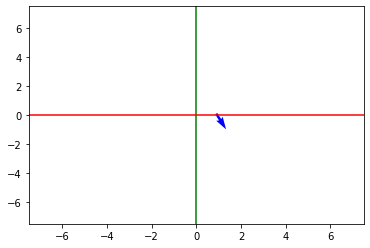

ang:
1.0125212588843373
ang robot:
-0.6055372953414917
After:
-0.6055372953414917


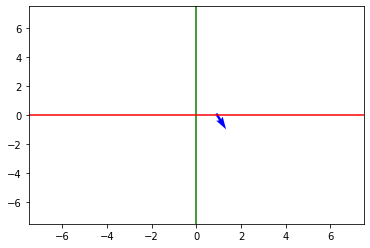

Turn -1.0125212588843373 pos (0.8941410183906555, 0.100730299949646) goal 3.6661414675272166 -4.340438219418542ang:
1.0133267529953764
ang robot:
-0.6909163594245911
After:
-0.6909163594245911


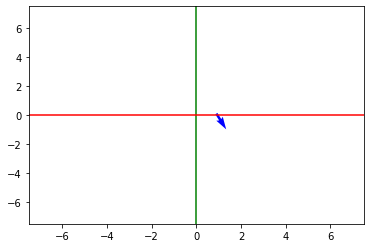

ang:
1.013564355469989
ang robot:
-0.7144898176193237
After:
-0.7144898176193237


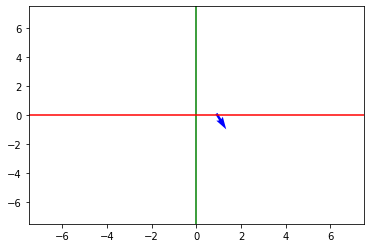

Turn -1.013564355469989 pos (0.8984652757644653, 0.10295550525188446) goal 3.6661414675272166 -4.340438219418542ang:
1.0140919341156915
ang robot:
-0.7696234583854675
After:
-0.7696234583854675


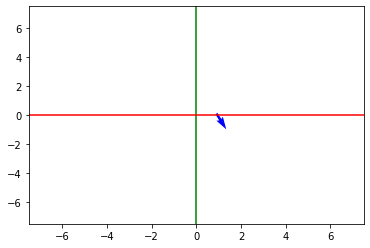

ang:
1.0142493185485797
ang robot:
-0.7892798185348511
After:
-0.7892798185348511


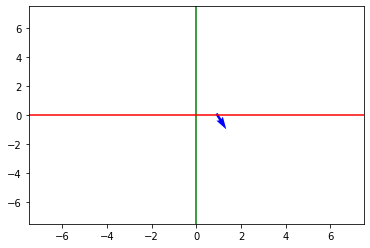

Turn -1.0142493185485797 pos (0.9010331034660339, 0.10484888404607773) goal 3.6661414675272166 -4.340438219418542ang:
1.0146539090043685
ang robot:
-0.8392348885536194
After:
-0.8392348885536194


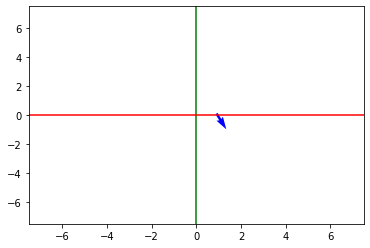

ang:
1.014887210492967
ang robot:
-0.8659120202064514
After:
-0.8659120202064514


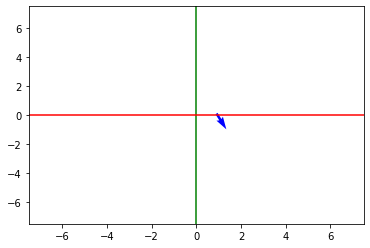

Turn -1.014887210492967 pos (0.905997633934021, 0.1061553806066513) goal 3.6661414675272166 -4.340438219418542ang:
1.015740305926928
ang robot:
-0.9563444256782532
After:
-0.9563444256782532


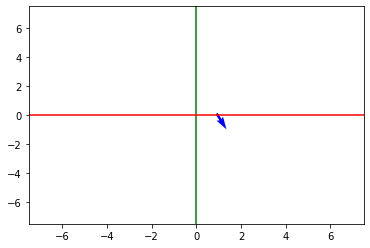

Go Forward pos (0.9120231866836548, 0.10532130300998688) goal 3.6661414675272166 -4.340438219418542ang:
1.0164731039625643
ang robot:
-1.055845856666565
After:
-1.055845856666565


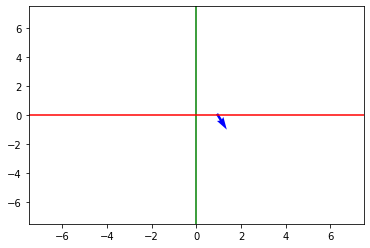

Go Forward pos (0.9293240308761597, 0.07991693168878555) goal 3.6661414675272166 -4.340438219418542ang:
1.0161010622277384
ang robot:
-1.0472933053970337
After:
-1.0472933053970337


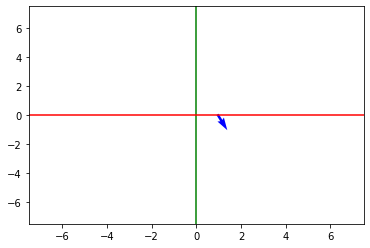

Go Forward pos (0.9514102935791016, 0.04059528186917305) goal 3.6661414675272166 -4.340438219418542ang:
1.0159204748833193
ang robot:
-1.0459187030792236
After:
-1.0459187030792236


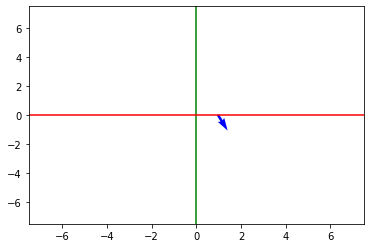

Go Forward pos (0.9710206985473633, 0.006653561256825924) goal 3.6661414675272166 -4.340438219418542ang:
1.0156023073141478
ang robot:
-1.0451337099075317
After:
-1.0451337099075317


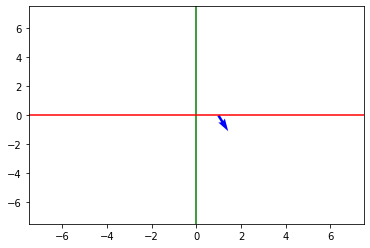

ang:
1.0154972460995693
ang robot:
-1.045079231262207
After:
-1.045079231262207


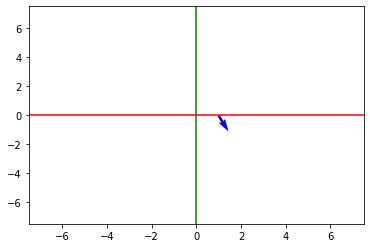

Turn 1.0154972460995693 pos (1.000024437904358, -0.04337966814637184) goal 3.6661414675272166 -4.340438219418542ang:
1.015078780526937
ang robot:
-1.0007113218307495
After:
-1.0007113218307495


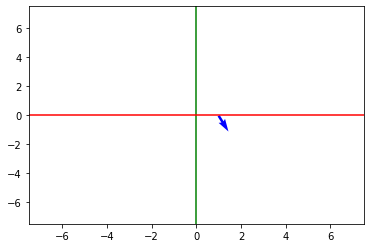

ang:
1.014654792755346
ang robot:
-0.9517451524734497
After:
-0.9517451524734497


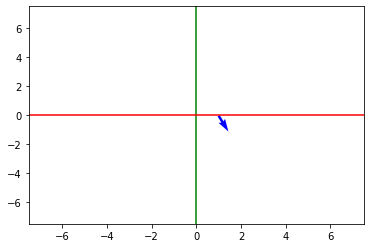

Turn 1.014654792755346 pos (0.9970391392707825, -0.047770239412784576) goal 3.6661414675272166 -4.340438219418542ang:
1.0138479118673485
ang robot:
-0.8582719564437866
After:
-0.8582719564437866


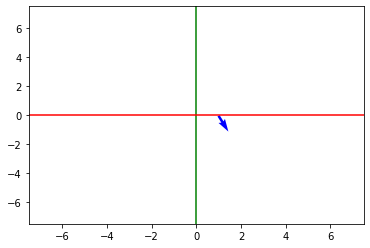

ang:
1.0134821469732445
ang robot:
-0.8075631260871887
After:
-0.8075631260871887


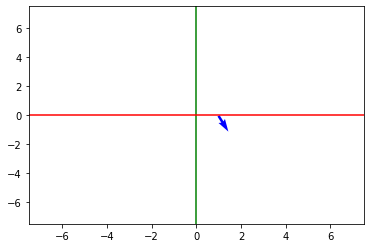

Turn 1.0134821469732445 pos (0.9940773844718933, -0.053817324340343475) goal 3.6661414675272166 -4.340438219418542ang:
1.0130742465998261
ang robot:
-0.7468887567520142
After:
-0.7468887567520142


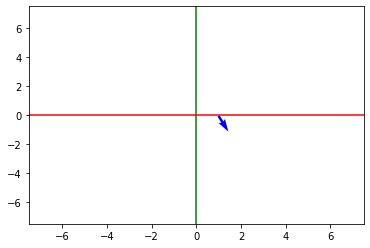

ang:
1.0128401904793258
ang robot:
-0.7104971408843994
After:
-0.7104971408843994


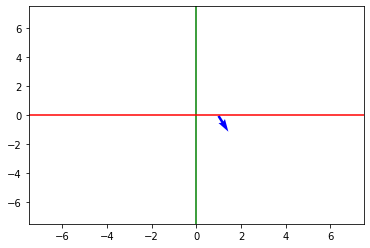

Turn 1.0128401904793258 pos (0.9939775466918945, -0.05895435810089111) goal 3.6661414675272166 -4.340438219418542ang:
1.012565071059919
ang robot:
-0.6716292500495911
After:
-0.6716292500495911


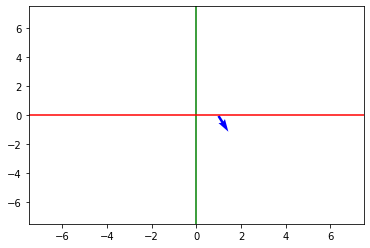

ang:
1.012415426100713
ang robot:
-0.6522696614265442
After:
-0.6522696614265442


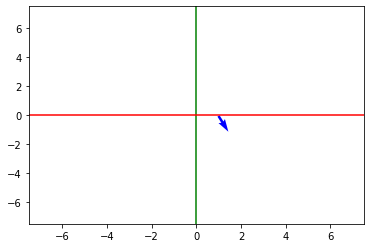

Turn 1.012415426100713 pos (0.992678165435791, -0.06156681105494499) goal 3.6661414675272166 -4.340438219418542ang:
1.0118646419989459
ang robot:
-0.576973021030426
After:
-0.576973021030426


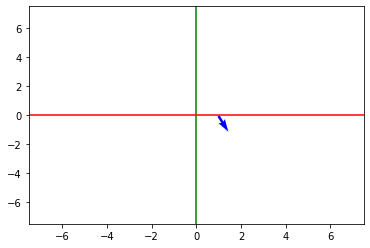

ang:
1.0117468395631561
ang robot:
-0.5530709028244019
After:
-0.5530709028244019


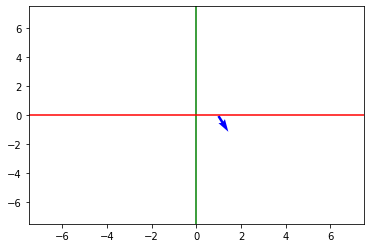

Turn 1.0117468395631561 pos (0.9921665191650391, -0.06668785959482193) goal 3.6661414675272166 -4.340438219418542ang:
1.0113377411284845
ang robot:
-0.47113925218582153
After:
-0.47113925218582153


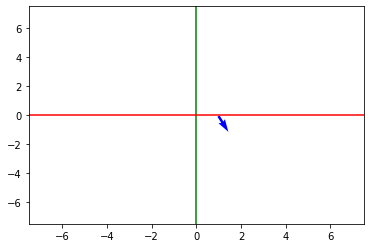

ang:
1.0112515764841212
ang robot:
-0.4465228021144867
After:
-0.4465228021144867


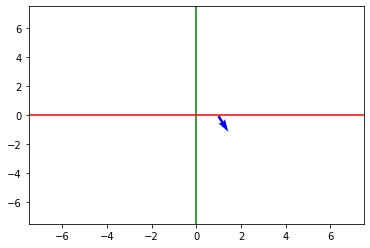

Turn 1.0112515764841212 pos (0.9936050176620483, -0.07306484878063202) goal 3.6661414675272166 -4.340438219418542ang:
1.0109200453510072
ang robot:
-0.36258363723754883
After:
-0.36258363723754883


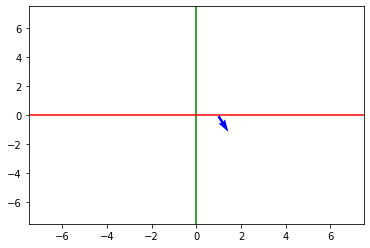

ang:
1.0109240436708935
ang robot:
-0.3245474100112915
After:
-0.3245474100112915


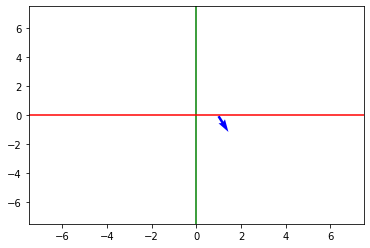

Turn 1.0109240436708935 pos (0.9954527616500854, -0.07871480286121368) goal 3.6661414675272166 -4.340438219418542ang:
1.0107083699616435
ang robot:
-0.25357189774513245
After:
-0.25357189774513245


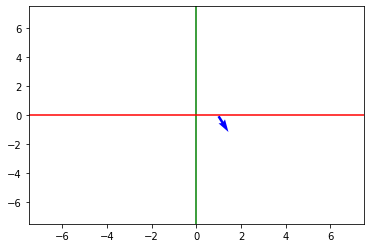

ang:
1.0107269124585883
ang robot:
-0.2292787730693817
After:
-0.2292787730693817


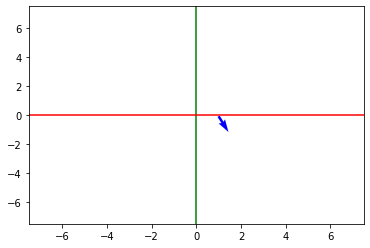

Turn 1.0107269124585883 pos (0.9976608157157898, -0.08396311849355698) goal 3.6661414675272166 -4.340438219418542ang:
1.0107335587563349
ang robot:
-0.1710127592086792
After:
-0.1710127592086792


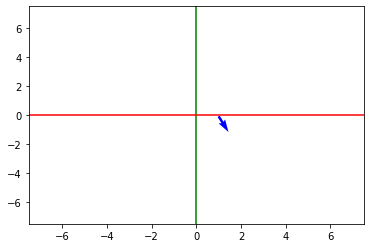

ang:
1.0106750837020542
ang robot:
-0.12178822606801987
After:
-0.12178822606801987


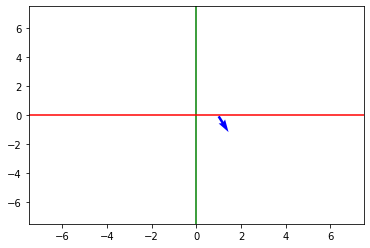

Turn 1.0106750837020542 pos (1.0005220174789429, -0.08923053741455078) goal 3.6661414675272166 -4.340438219418542ang:
1.01079733588407
ang robot:
-0.037935905158519745
After:
-0.037935905158519745


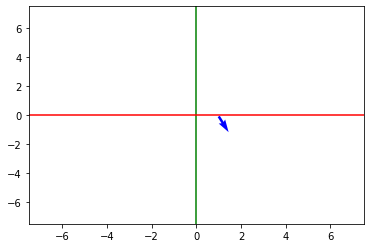

ang:
1.0110032279323062
ang robot:
-0.002251907717436552
After:
-0.002251907717436552


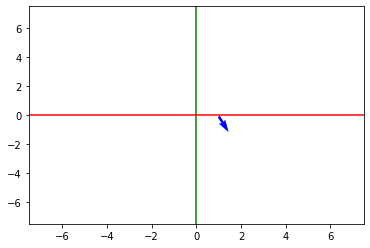

Turn 1.0110032279323062 pos (1.0059316158294678, -0.09432463347911835) goal 3.6661414675272166 -4.340438219418542ang:
1.0110225287854306
ang robot:
0.03852248564362526
After:
0.03852248564362526


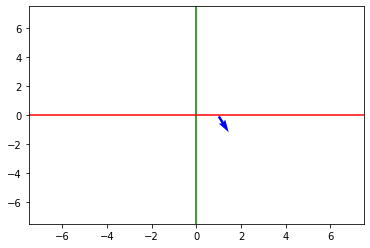

ang:
1.0110066254198113
ang robot:
0.05767872557044029
After:
0.05767872557044029


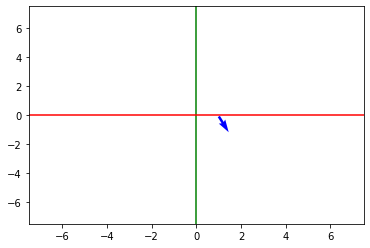

Turn 1.0110066254198113 pos (1.0073288679122925, -0.0972333773970604) goal 3.6661414675272166 -4.340438219418542ang:
1.0109388358228226
ang robot:
0.1048002690076828
After:
0.1048002690076828


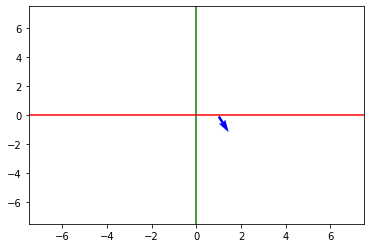

ang:
1.0110494203845088
ang robot:
0.15487204492092133
After:
0.15487204492092133


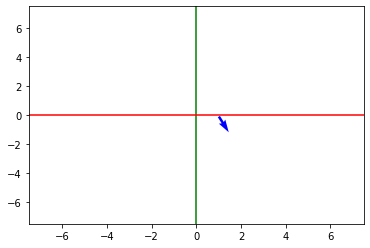

Turn 1.0110494203845088 pos (1.0105836391448975, -0.1013316959142685) goal 3.6661414675272166 -4.340438219418542ang:
1.0114395026598193
ang robot:
0.21946585178375244
After:
0.21946585178375244


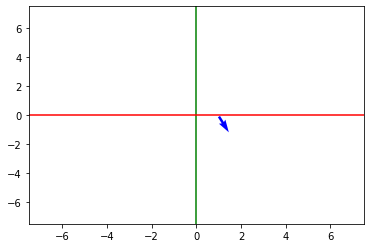

ang:
1.0115039881135903
ang robot:
0.24771606922149658
After:
0.24771606922149658


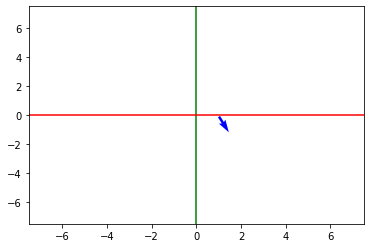

Turn 1.0115039881135903 pos (1.0165817737579346, -0.10527651011943817) goal 3.6661414675272166 -4.340438219418542ang:
1.0122753236440238
ang robot:
0.3655036985874176
After:
0.3655036985874176


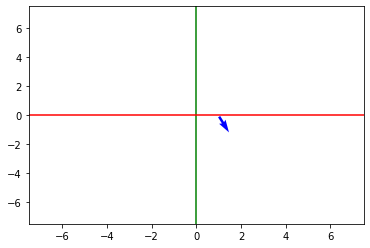

ang:
1.012425101197015
ang robot:
0.38806289434432983
After:
0.38806289434432983


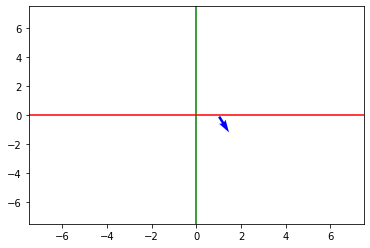

Turn 1.012425101197015 pos (1.023292064666748, -0.10822312533855438) goal 3.6661414675272166 -4.340438219418542ang:
1.0130179993668822
ang robot:
0.470806747674942
After:
0.470806747674942


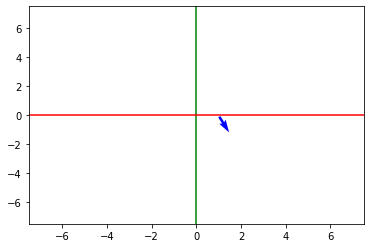

ang:
1.0133865377801323
ang robot:
0.5194798111915588
After:
0.5194798111915588


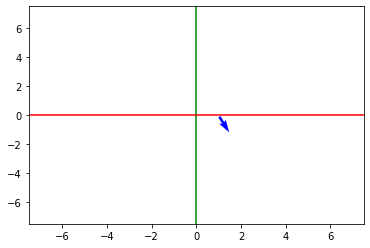

Turn 1.0133865377801323 pos (1.0307013988494873, -0.11090712249279022) goal 3.6661414675272166 -4.340438219418542ang:
1.0138569573725549
ang robot:
0.5753281116485596
After:
0.5753281116485596


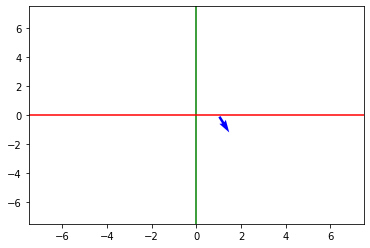

ang:
1.0140264958833862
ang robot:
0.6017991900444031
After:
0.6017991900444031


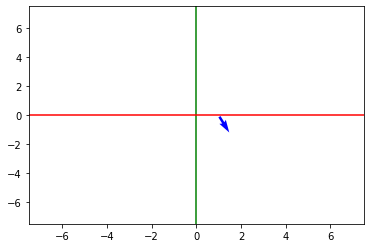

Turn 1.0140264958833862 pos (1.0366867780685425, -0.1124773845076561) goal 3.6661414675272166 -4.340438219418542ang:
1.014841677509371
ang robot:
0.7062280178070068
After:
0.7062280178070068


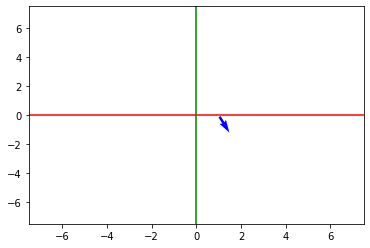

ang:
1.0150114896707703
ang robot:
0.7289015054702759
After:
0.7289015054702759


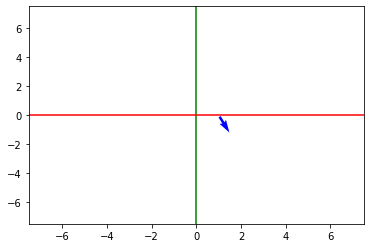

Turn 1.0150114896707703 pos (1.0426536798477173, -0.11384449154138565) goal 3.6661414675272166 -4.340438219418542ang:
1.0155833075564078
ang robot:
0.8071078062057495
After:
0.8071078062057495


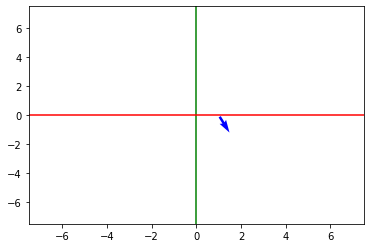

ang:
1.015865170364558
ang robot:
0.8299127817153931
After:
0.8299127817153931


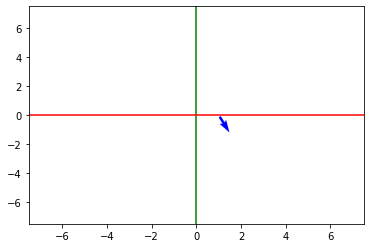

Turn 1.015865170364558 pos (1.048701524734497, -0.11396601051092148) goal 3.6661414675272166 -4.340438219418542ang:
1.01647688247757
ang robot:
0.886663019657135
After:
0.886663019657135


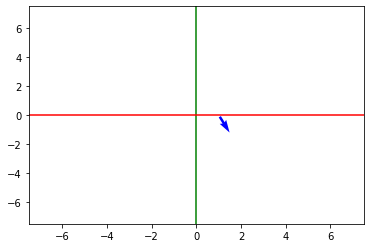

Go Forward pos (1.0528041124343872, -0.11496909707784653) goal 3.6661414675272166 -4.340438219418542ang:
1.0211027963781218
ang robot:
0.9731073379516602
After:
0.9731073379516602


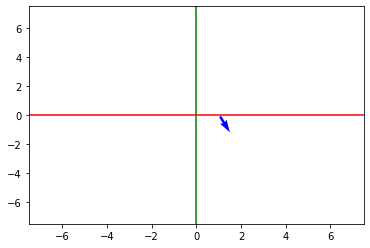

Go Forward pos (1.07134211063385, -0.09089776128530502) goal 3.6661414675272166 -4.340438219418542ang:
1.0294386840157146
ang robot:
0.9565483331680298
After:
0.9565483331680298


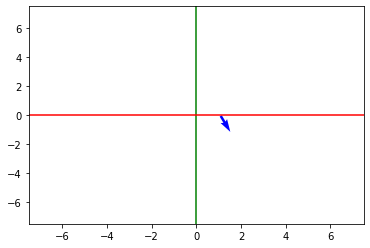

Go Forward pos (1.0969632863998413, -0.053105276077985764) goal 3.6661414675272166 -4.340438219418542ang:
1.0348773871132761
ang robot:
0.955675482749939
After:
0.955675482749939


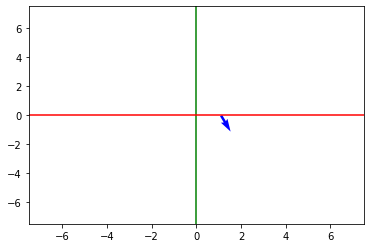

Go Forward pos (1.1197130680084229, -0.020818164572119713) goal 3.6661414675272166 -4.340438219418542ang:
1.0429084291307522
ang robot:
0.9576051831245422
After:
0.9576051831245422


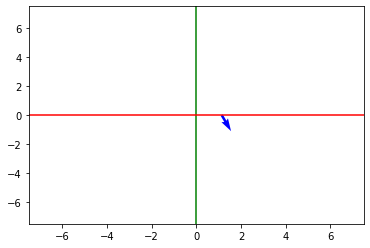

ang:
1.0461388345232545
ang robot:
0.957801878452301
After:
0.957801878452301


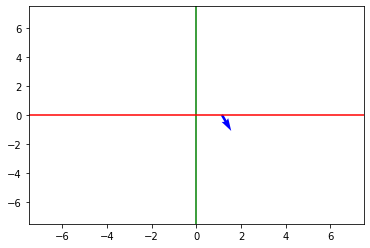

Turn -1.0461388345232545 pos (1.1477539539337158, 0.01879531890153885) goal 3.6661414675272166 -4.340438219418542ang:
1.0470363317408906
ang robot:
0.9336175322532654
After:
0.9336175322532654


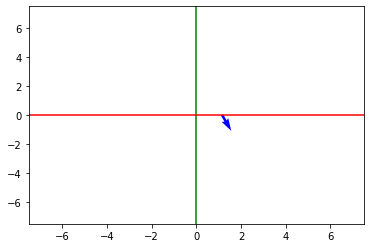

ang:
1.0470026908623915
ang robot:
0.918927788734436
After:
0.918927788734436


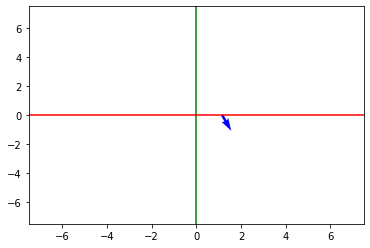

Turn -1.0470026908623915 pos (1.1463863849639893, 0.02070668153464794) goal 3.6661414675272166 -4.340438219418542ang:
1.0470796646148086
ang robot:
0.8802699446678162
After:
0.8802699446678162


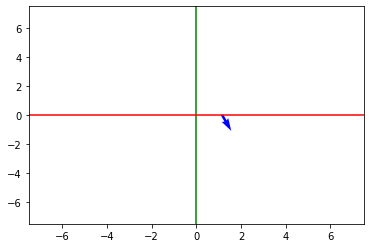

ang:
1.0472358574015534
ang robot:
0.8333016037940979
After:
0.8333016037940979


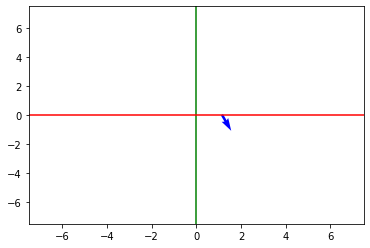

Turn -1.0472358574015534 pos (1.1453444957733154, 0.02576625905930996) goal 3.6661414675272166 -4.340438219418542ang:
1.0472127273462646
ang robot:
0.7743900418281555
After:
0.7743900418281555


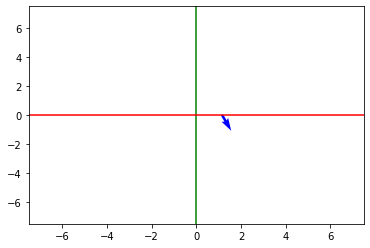

ang:
1.047367382934248
ang robot:
0.7250707745552063
After:
0.7250707745552063


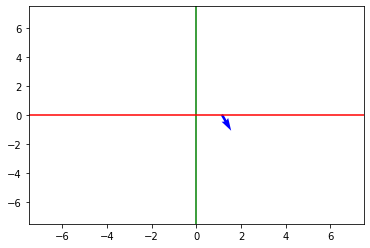

Turn -1.047367382934248 pos (1.1437665224075317, 0.030687037855386734) goal 3.6661414675272166 -4.340438219418542ang:
1.0475680160907133
ang robot:
0.6451425552368164
After:
0.6451425552368164


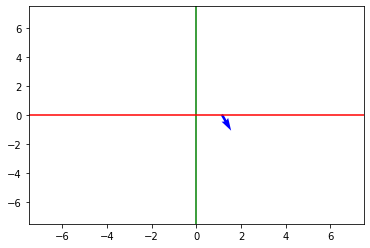

ang:
1.0477699955033142
ang robot:
0.6074177622795105
After:
0.6074177622795105


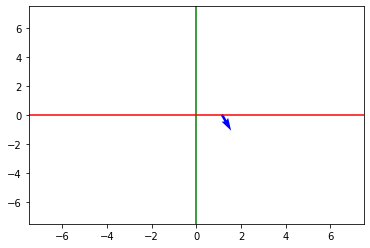

Turn -1.0477699955033142 pos (1.1431324481964111, 0.036193568259477615) goal 3.6661414675272166 -4.340438219418542ang:
1.0478494592179253
ang robot:
0.566278874874115
After:
0.566278874874115


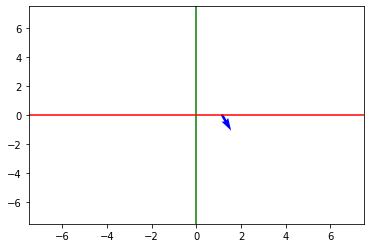

ang:
1.0481267299407984
ang robot:
0.5169961452484131
After:
0.5169961452484131


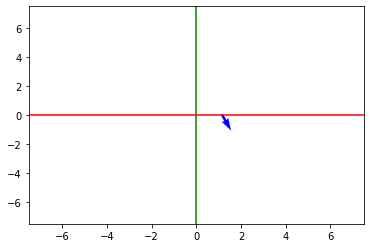

Turn -1.0481267299407984 pos (1.1429060697555542, 0.04117206484079361) goal 3.6661414675272166 -4.340438219418542ang:
1.0487301833578853
ang robot:
0.45369043946266174
After:
0.45369043946266174


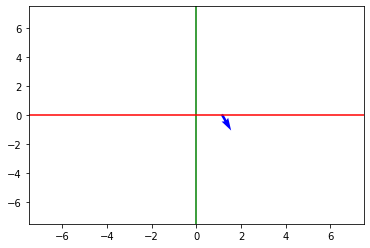

ang:
1.0490323928251821
ang robot:
0.4025253355503082
After:
0.4025253355503082


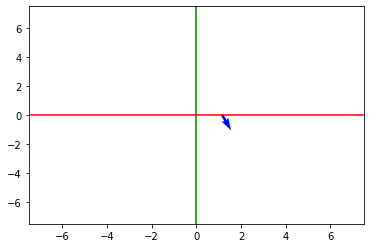

Turn -1.0490323928251821 pos (1.1443564891815186, 0.047472286969423294) goal 3.6661414675272166 -4.340438219418542ang:
1.0497348868521263
ang robot:
0.3114675283432007
After:
0.3114675283432007


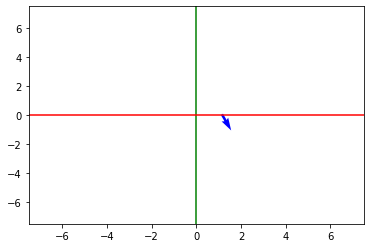

ang:
1.0499227737199053
ang robot:
0.28688758611679077
After:
0.28688758611679077


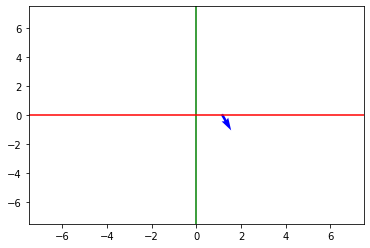

Turn -1.0499227737199053 pos (1.146691918373108, 0.05403660610318184) goal 3.6661414675272166 -4.340438219418542ang:
1.050310583452109
ang robot:
0.22855427861213684
After:
0.22855427861213684


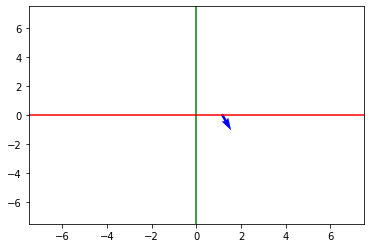

ang:
1.0507007037777056
ang robot:
0.17874957621097565
After:
0.17874957621097565


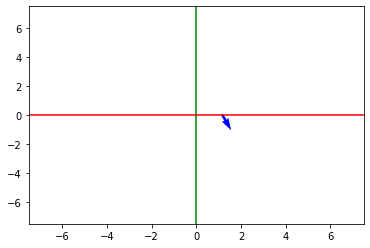

Turn -1.0507007037777056 pos (1.148034930229187, 0.05881660431623459) goal 3.6661414675272166 -4.340438219418542ang:
1.0512194013480025
ang robot:
0.119717538356781
After:
0.119717538356781


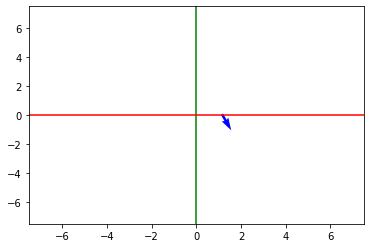

ang:
1.0516345717824116
ang robot:
0.06865120679140091
After:
0.06865120679140091


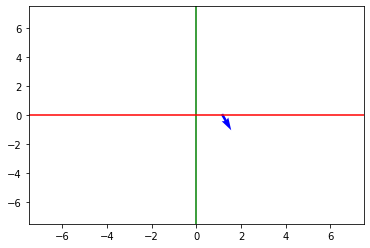

Turn -1.0516345717824116 pos (1.1505423784255981, 0.06398498266935349) goal 3.6661414675272166 -4.340438219418542ang:
1.0526642880123736
ang robot:
-0.022447848692536354
After:
-0.022447848692536354


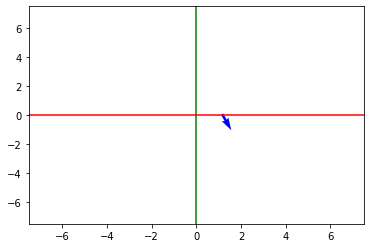

ang:
1.0531829972804931
ang robot:
-0.058141712099313736
After:
-0.058141712099313736


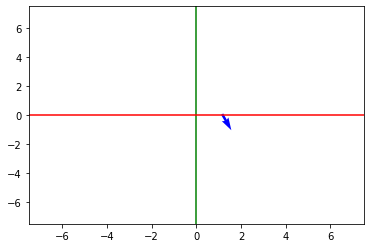

Turn -1.0531829972804931 pos (1.1562092304229736, 0.06907365471124649) goal 3.6661414675272166 -4.340438219418542ang:
1.053751985685379
ang robot:
-0.12623238563537598
After:
-0.12623238563537598


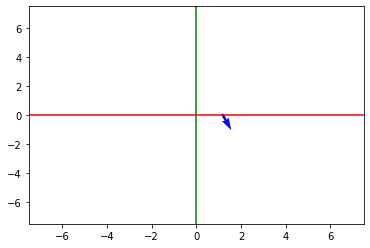

ang:
1.054054948029055
ang robot:
-0.15143707394599915
After:
-0.15143707394599915


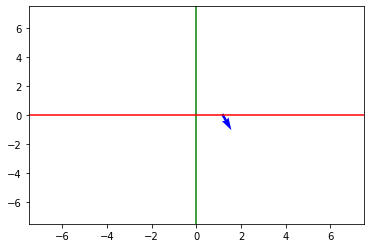

Turn -1.054054948029055 pos (1.159554123878479, 0.07329615205526352) goal 3.6661414675272166 -4.340438219418542ang:
1.0547292841025573
ang robot:
-0.2132052630186081
After:
-0.2132052630186081


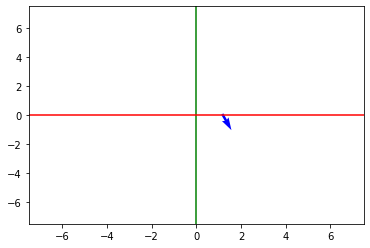

ang:
1.0549539520559708
ang robot:
-0.24038995802402496
After:
-0.24038995802402496


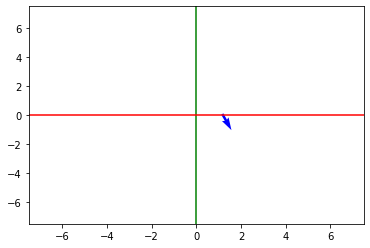

Turn -1.0549539520559708 pos (1.16348397731781, 0.07737544178962708) goal 3.6661414675272166 -4.340438219418542ang:
1.0562015601043862
ang robot:
-0.3515240252017975
After:
-0.3515240252017975


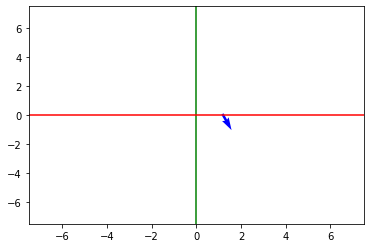

ang:
1.056460618129864
ang robot:
-0.37449148297309875
After:
-0.37449148297309875


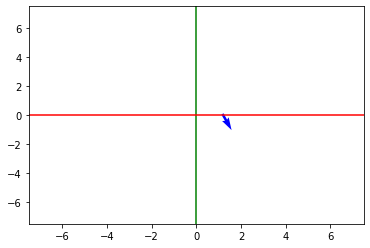

Turn -1.056460618129864 pos (1.1690361499786377, 0.08061926811933517) goal 3.6661414675272166 -4.340438219418542ang:
1.0570069560342688
ang robot:
-0.42926672101020813
After:
-0.42926672101020813


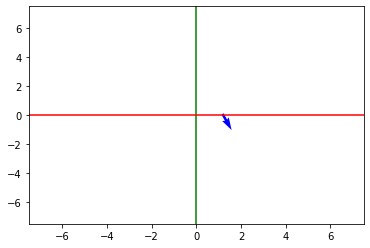

ang:
1.0574952408641882
ang robot:
-0.48071035742759705
After:
-0.48071035742759705


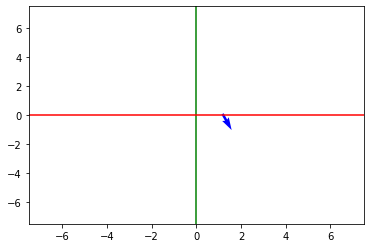

Turn -1.0574952408641882 pos (1.1731537580490112, 0.08399222046136856) goal 3.6661414675272166 -4.340438219418542

In [ ]:
mr.start(200)

In [ ]:
reso = 0.4
room_countour = mr.point_cloud.get_room_countour()
px, py = planning(room_countour[0], room_countour[1], reso)
#planning_animation(room_countour[0], room_countour[1], reso)

Start _GotoGoal Subsumption Behavior_ without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

## Conclusion: ##

__Video URL:__ http://youtube.com